In [20]:
import zipfile
import pathlib
import os

zip_path = "BCIT Mind Wandering.zip"   # ← replace with your uploaded filename

extract_to = str(pathlib.Path(zip_path).with_suffix(''))
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Extracted to:", extract_to)


Extracted to: BCIT Mind Wandering


In [21]:
# Run in a notebook cell (prefix with !)
!pip install mne pyedflib pandas joblib pyarrow tqdm


DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will

In [22]:
import os
import pathlib
import zipfile
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import mne
from scipy import signal
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Change this to your BCIT dataset root
DATA_ROOT = "BCIT Mind Wandering"   # or full path "/home/jovyan/.../BCIT Mind Wandering"
OUT_ROOT = "features_output_bcit"
os.makedirs(OUT_ROOT, exist_ok=True)


In [23]:
def find_bcit_runs(root):
    root = pathlib.Path(root)
    runs = []
    for path in root.rglob("*.set"):
        run = {}
        run['eeg'] = str(path)
        parent = path.parent
        # look for channels.tsv in same folder or one level up
        ch = list(parent.glob("*channels*.tsv"))
        if not ch:
            ch = list(parent.parent.glob("*channels*.tsv"))
        run['channels_tsv'] = str(ch[0]) if ch else None
        # look for events.tsv following BIDS pattern
        ev = list(parent.glob("*events*.tsv"))
        if not ev:
            ev = list(parent.parent.glob("*events*.tsv"))
        run['events_tsv'] = str(ev[0]) if ev else None
        runs.append(run)
    return runs

runs = find_bcit_runs(DATA_ROOT)
print(f"Found {len(runs)} runs. Example:\n", runs[:2])


Found 33 runs. Example:
 [{'eeg': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set', 'channels_tsv': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_channels.tsv', 'events_tsv': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv'}, {'eeg': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg.set', 'channels_tsv': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_channels.tsv', 'events_tsv': 'BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv'}]


In [25]:
def apply_channels_tsv(raw, channels_tsv):
    """
    channels_tsv: BIDS channels.tsv with at least 'name' column and optionally 'x','y','z' or 'loc' info.
    This function tries to set channel names and a montage if 3D coords are present.
    """
    try:
        df = pd.read_csv(channels_tsv, sep='\t')
    except Exception as e:
        print("Could not read channels.tsv:", e)
        return raw

    # Rename channels if 'name' col exists
    if 'name' in df.columns:
        # Build mapping for any present channels
        names = df['name'].tolist()
        # If number matches, set channel names
        if len(names) == len(raw.ch_names):
            raw.rename_channels({old: new for old, new in zip(raw.ch_names, names)})
        else:
            # Try matching by subset
            # no-op unless exact match: avoid accidental renames
            pass

    # Try create montage if x,y,z present
    if all(c in df.columns for c in ('x','y','z')):
        pos = {}
        for _, row in df.iterrows():
            chname = row['name']
            pos[chname] = np.array([row['x'], row['y'], row['z']])
        # build standard montage
        try:
            montage = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='head')
            raw.set_montage(montage, match_case=False, on_missing='ignore')
        except Exception as e:
            print("Montage creation failed:", e)
    return raw


In [26]:
def load_events_for_run(raw, events_tsv):
    """
    Return MNE-style events array (n_events x 3) and event_id dict.
    events_tsv expected to have columns: onset (in seconds), duration (opt), trial_type (label)
    """
    if events_tsv and os.path.exists(events_tsv):
        df = pd.read_csv(events_tsv, sep='\t')
        # BIDS usually has 'onset' (seconds) and 'trial_type' or 'value'
        if 'onset' in df.columns:
            onsets = df['onset'].values.astype(float)
            # label column heuristics
            label_col = None
            for c in ('trial_type', 'value', 'condition', 'stim_type', 'event'):
                if c in df.columns:
                    label_col = c
                    break
            if label_col is None:
                labels = np.ones(len(onsets), dtype=int)
            else:
                labels = df[label_col].values
            # map labels to ints
            unique_labels = {lab: i+1 for i, lab in enumerate(np.unique(labels))}
            samples = (onsets * raw.info['sfreq']).astype(int)
            events = np.array([[s, 0, unique_labels[l]] for s, l in zip(samples, labels)])
            return events, unique_labels
    # fallback: use annotations from raw (if any)
    try:
        annot = raw.annotations
        if len(annot) > 0:
            # MNE convenience
            events, event_id = mne.events_from_annotations(raw)
            return events, event_id
    except Exception:
        pass
    # No events found
    return None, None


In [27]:
def bandpower(psd_freqs, psd_vals, fmin, fmax):
    mask = (psd_freqs >= fmin) & (psd_freqs <= fmax)
    if not np.any(mask):
        return 0.0
    return np.trapz(psd_vals[mask], psd_freqs[mask])

from scipy.stats import skew, kurtosis
def epoch_to_features(epoch_data, sfreq):
    feats = {}
    bands = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}
    n_ch, n_t = epoch_data.shape
    freqs, psd = signal.welch(epoch_data, fs=sfreq, nperseg=min(256, n_t))
    if psd.ndim == 1:
        psd = psd[np.newaxis,:]
    for ch in range(n_ch):
        d = epoch_data[ch]
        feats[f"ch{ch}_mean"] = float(np.mean(d))
        feats[f"ch{ch}_std"] = float(np.std(d))
        feats[f"ch{ch}_skew"] = float(skew(d))
        feats[f"ch{ch}_kurtosis"] = float(kurtosis(d))
        diff1 = np.diff(d)
        diff2 = np.diff(diff1) if len(diff1)>0 else np.array([0.])
        var0 = np.var(d)
        var1 = np.var(diff1) if len(diff1)>0 else 0.0
        var2 = np.var(diff2) if len(diff2)>0 else 0.0
        activity = float(var0)
        mobility = float(np.sqrt(var1/var0)) if var0>0 else 0.0
        complexity = float(np.sqrt(var2/var1)/mobility) if (var1>0 and mobility>0) else 0.0
        feats[f"ch{ch}_hjorth_activity"] = activity
        feats[f"ch{ch}_hjorth_mobility"] = mobility
        feats[f"ch{ch}_hjorth_complexity"] = complexity
        for bname,(fmin,fmax) in bands.items():
            bp = bandpower(freqs, psd[ch], fmin, fmax)
            feats[f"ch{ch}_bp_{bname}"] = float(bp)
    return feats


In [28]:
def process_set_run(eeg_path, channels_tsv=None, events_tsv=None, out_dir=OUT_ROOT,
                    l_freq=0.5, h_freq=45, resample_sfreq=128, tmin=-0.2, tmax=0.8):
    eeg_path = str(eeg_path)
    basename = pathlib.Path(eeg_path).stem
    try:
        raw = mne.io.read_raw_eeglab(eeg_path, preload=True, verbose=False)
    except Exception as e:
        print(f"Failed to read {eeg_path}: {e}")
        return None
    # apply channels metadata if present
    if channels_tsv and os.path.exists(channels_tsv):
        raw = apply_channels_tsv(raw, channels_tsv)
    # pick EEG channels only
    picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False, ecg=False)
    if len(picks)==0:
        picks = None
    raw.load_data()
    try:
        raw.filter(l_freq, h_freq, picks=picks, fir_design='firwin', verbose=False)
    except Exception as e:
        print("Filter failed:", e)
    if resample_sfreq:
        try:
            raw.resample(resample_sfreq, npad='auto')
        except Exception as e:
            print("Resample failed:", e)

    # load events (BIDS events.tsv preferred)
    events, event_id = load_events_for_run(raw, events_tsv)
    if events is None or len(events)==0:
        print(f"No events for {basename}. Creating sliding-window epochs (fallback).")
        # create sliding windows: e.g., 1s windows with 0.5s overlap
        win_s = 1.0
        step_s = 0.5
        n_samples = raw.n_times
        sfreq = raw.info['sfreq']
        window_samples = int(win_s * sfreq)
        step_samples = int(step_s * sfreq)
        starts = np.arange(0, max(1, n_samples-window_samples+1), step_samples)
        rows = []
        for i, start in enumerate(starts):
            stop = start + window_samples
            data = raw.get_data(picks=picks, start=start, stop=stop)
            feats = epoch_to_features(data, sfreq)
            feats.update({'run': basename, 'epoch_idx': i, 'event': np.nan})
            rows.append(feats)
        if rows:
            df = pd.DataFrame(rows)
            out_path = os.path.join(out_dir, f"{basename}_features.parquet")
            df.to_parquet(out_path, index=False)
            return out_path
        else:
            return None

    # else we have events -> epoch
    events = events[events[:,0].argsort()]
    try:
        epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax,
                            baseline=None, picks=picks, preload=True, verbose=False)
    except Exception as e:
        print("Epoching failed:", e)
        return None

    rows = []
    sfreq = raw.info['sfreq']
    data = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
    for i, ep in enumerate(data):
        feats = epoch_to_features(ep, sfreq)
        feats.update({'run': basename, 'epoch_idx': i, 'event': int(epochs.events[i,2])})
        rows.append(feats)

    if not rows:
        return None

    df = pd.DataFrame(rows)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{basename}_features.parquet")
    df.to_parquet(out_path, index=False)
    return out_path


In [31]:
# prints a readable tree of the HDF5 file internals
import h5py, json, os, textwrap, pathlib

set_path = "BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set"
assert os.path.exists(set_path), f"File not found: {set_path}"

def print_h5_tree(fp):
    with h5py.File(fp, "r") as hf:
        entries = []
        def visitor(name, obj):
            kind = "Group" if isinstance(obj, h5py.Group) else "Dataset"
            shape = getattr(obj, "shape", None)
            dtype = getattr(obj, "dtype", None)
            entries.append((name, kind, shape, str(dtype)))
        hf.visititems(visitor)
    # pretty print
    for name, kind, shape, dtype in entries:
        print(f"{kind:7}  {name:60}  shape={shape}  dtype={dtype}")

print(f"Inspecting: {set_path}\n")
print_h5_tree(set_path)


Inspecting: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set

Group    #refs#                                                        shape=None  dtype=None
Dataset  #refs#/0                                                      shape=(3, 1)  dtype=uint16
Dataset  #refs#/00                                                     shape=(1, 1)  dtype=float64
Dataset  #refs#/00b                                                    shape=(4, 1)  dtype=uint16
Dataset  #refs#/00c                                                    shape=(1, 1)  dtype=float64
Dataset  #refs#/01                                                     shape=(1, 1)  dtype=float64
Dataset  #refs#/01b                                                    shape=(4, 1)  dtype=uint16
Dataset  #refs#/01c                                                    shape=(1, 1)  dtype=float64
Dataset  #refs#/01d                                                    shape=(4, 1)  dtype=ui

In [32]:
# attempts several heuristics to find EEG data and metadata inside HDF5 .set
import h5py, numpy as np, os, json
import mne, pathlib

set_path = "BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set"
out_debug = "h5_debug_sub01_run1.json"

def try_build_raw_from_h5(path):
    debug = {"file": path, "candidates": [], "used": None, "errors": []}
    with h5py.File(path, "r") as hf:
        # list top keys
        debug["top_keys"] = list(hf.keys())
        # gather all numeric 2D datasets
        def collect(name, obj):
            try:
                if isinstance(obj, h5py.Dataset) and obj.ndim == 2 and np.issubdtype(obj.dtype, np.number):
                    debug["candidates"].append({
                        "name": name,
                        "shape": obj.shape,
                        "dtype": str(obj.dtype)
                    })
            except Exception as e:
                debug["errors"].append(f"collect_err {name}: {repr(e)}")
        hf.visititems(collect)

        # Try common locations/names for data and metadata
        # Common EEGLAB v7.3: '/EEG/data' or '/#refs#/datasets/...' etc.
        candidate_paths = [
            "/EEG/data",
            "EEG/data",
            "/data",
            "data"
        ]
        found = None
        for cp in candidate_paths:
            if cp in hf:
                try:
                    ds = hf[cp]
                    arr = np.array(ds)
                    found = (cp, arr)
                    debug["found_by_common_path"] = cp
                    break
                except Exception as e:
                    debug["errors"].append(f"read_common_path_{cp}: {repr(e)}")
        # If not found, search the collected candidates heuristically
        if found is None and debug["candidates"]:
            # choose candidate where one dim <= 512 (channels) and other dim > 100 (time)
            for c in debug["candidates"]:
                a_shape = c["shape"]
                if (a_shape[0] <= 512 and a_shape[1] > 100) or (a_shape[1] <= 512 and a_shape[0] > 100):
                    try:
                        arr = np.array(hf[c["name"]])
                        found = (c["name"], arr)
                        debug["found_by_heuristic"] = c["name"]
                        break
                    except Exception as e:
                        debug["errors"].append(f"read_heur_{c['name']}: {repr(e)}")
        if found is None:
            debug["errors"].append("No suitable numeric 2D dataset found by heuristics.")
            return None, debug

        name, data = found
        # ensure channels x times
        ch_dim, time_dim = data.shape
        # heuristic: if first dim > 2000 it's likely time axis -> transpose
        if ch_dim > 2000 and time_dim < 1024:
            data = data.T
            ch_dim, time_dim = data.shape
            debug["transposed"] = True
        debug["used_dataset"] = name
        debug["used_shape"] = (ch_dim, time_dim)

        # try to find sampling rate
        sfreq = None
        # common places
        for key in ("EEG/srate","EEG/samples","EEG/samplingrate","EEG/sfreq","srate"):
            try:
                if key in hf:
                    val = np.array(hf[key]).squeeze()
                    sfreq = float(val)
                    debug["found_sfreq_key"] = key
                    break
            except Exception as e:
                debug["errors"].append(f"sfreq_key_err_{key}: {repr(e)}")
        # try attributes of EEG group
        if sfreq is None and "EEG" in hf:
            try:
                for k,v in hf['EEG'].attrs.items():
                    if 'rate' in k.lower() or 'srate' in k.lower() or 'sfreq' in k.lower():
                        sfreq = float(v)
                        debug["found_sfreq_attr"] = k
                        break
            except Exception:
                pass
        if sfreq is None:
            sfreq = 250.0
            debug["sfreq_defaulted"] = sfreq

        # try to find channel names (strings)
        ch_names = None
        # search for any dataset with string dtype or ascii bytes
        def find_strings(group):
            for k in group.keys():
                obj = group[k]
                if isinstance(obj, h5py.Dataset) and obj.dtype.kind in ('S','U'):
                    try:
                        arr = [a.decode('utf-8') if isinstance(a, bytes) else str(a) for a in obj[:]]
                        if len(arr) == ch_dim:
                            return arr, f"{k} in group"
                    except Exception:
                        pass
                if isinstance(obj, h5py.Group):
                    res = find_strings(obj)
                    if res:
                        return res
            return None
        try:
            res = find_strings(hf)
            if res:
                ch_names, where = res
                debug["found_ch_names_where"] = where
        except Exception as e:
            debug["errors"].append(f"find_strings_err: {repr(e)}")

        if ch_names is None:
            ch_names = [f"EEG{i+1}" for i in range(ch_dim)]
            debug["ch_names_defaulted"] = len(ch_names)

        # Build RawArray
        try:
            import mne
            info = mne.create_info(ch_names, sfreq, ch_types='eeg')
            raw = mne.io.RawArray(np.array(data, dtype=float), info)
            debug["raw_built"] = True
            debug["nchan"] = raw.info['nchan']
            debug["sfreq"] = raw.info['sfreq']
            debug["ch_names_preview"] = raw.ch_names[:10]
            return raw, debug
        except Exception as e:
            debug["errors"].append(f"raw_build_err: {repr(e)}")
            return None, debug

if __name__ == "__main__":
    raw, dbg = try_build_raw_from_h5(set_path)
    # save debug for inspection
    with open(out_debug, "w") as f:
        json.dump(dbg, f, indent=2)
    print("Debug saved to", out_debug)
    if raw is None:
        print("Auto-loader failed. Debug summary:")
        print(dbg)
    else:
        print("Auto-loader succeeded. Raw info:")
        print(raw)


Creating RawArray with float64 data, n_channels=74, n_times=1888256
    Range : 0 ... 1888255 =      0.000 ...  1843.999 secs
Ready.
Debug saved to h5_debug_sub01_run1.json
Auto-loader succeeded. Raw info:
<RawArray | 74 x 1888256 (1844.0 s), ~1.04 GiB, data loaded>


In [33]:
# feature utilities (re-run if you restarted kernel)
import os, pathlib, gc, json
import numpy as np, pandas as pd
from scipy import signal
from scipy.stats import skew, kurtosis

def bandpower(psd_freqs, psd_vals, fmin, fmax):
    mask = (psd_freqs >= fmin) & (psd_freqs <= fmax)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(psd_vals[mask], psd_freqs[mask]))

def epoch_to_features(epoch_data, sfreq):
    """
    epoch_data: np.array shape (n_channels, n_times)
    returns dict of features (channel-wise flattened names)
    """
    feats = {}
    bands = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}
    n_ch, n_t = epoch_data.shape
    freqs, psd = signal.welch(epoch_data, fs=sfreq, nperseg=min(256, n_t))
    if psd.ndim == 1:
        psd = psd[np.newaxis,:]
    for ch in range(n_ch):
        d = epoch_data[ch].astype(float)
        feats[f"ch{ch}_mean"] = float(np.mean(d))
        feats[f"ch{ch}_std"] = float(np.std(d))
        feats[f"ch{ch}_skew"] = float(skew(d))
        feats[f"ch{ch}_kurtosis"] = float(kurtosis(d))
        diff1 = np.diff(d) if d.size>1 else np.array([0.])
        diff2 = np.diff(diff1) if diff1.size>1 else np.array([0.])
        var0 = float(np.var(d))
        var1 = float(np.var(diff1)) if diff1.size>0 else 0.0
        var2 = float(np.var(diff2)) if diff2.size>0 else 0.0
        activity = var0
        mobility = float(np.sqrt(var1/var0)) if var0>0 else 0.0
        complexity = float(np.sqrt(var2/var1)/mobility) if (var1>0 and mobility>0) else 0.0
        feats[f"ch{ch}_hjorth_activity"] = activity
        feats[f"ch{ch}_hjorth_mobility"] = mobility
        feats[f"ch{ch}_hjorth_complexity"] = complexity
        for bname,(fmin,fmax) in bands.items():
            bp = bandpower(freqs, psd[ch], fmin, fmax)
            feats[f"ch{ch}_bp_{bname}"] = bp
    return feats


In [34]:
# events loader (BIDS style)
import os, numpy as np, pandas as pd

def load_events_from_tsv(events_tsv, raw):
    """
    returns events array (n x 3) and event_id dict, or (None, None)
    expects onset in seconds (BIDS) and trial_type or value label
    """
    if not events_tsv or not os.path.exists(events_tsv):
        return None, None
    df = pd.read_csv(events_tsv, sep='\t')
    if 'onset' not in df.columns:
        # maybe 'sample' or 'time'—try common names
        for c in ('sample','time','timestamp','start'):
            if c in df.columns:
                df = df.rename(columns={c:'onset'})
                break
    if 'onset' not in df.columns:
        # can't interpret
        return None, None
    onsets = df['onset'].astype(float).values
    label_col = None
    for c in ('trial_type','value','condition','event','label'):
        if c in df.columns:
            label_col = c
            break
    if label_col is None:
        labels = np.ones(len(onsets), dtype=int)
    else:
        labels = df[label_col].values
    unique_labels = {lab:int(i+1) for i,lab in enumerate(np.unique(labels))}
    samples = (onsets * raw.info['sfreq']).astype(int)
    events = np.array([[int(s), 0, unique_labels[l]] for s,l in zip(samples, labels)], dtype=int)
    return events, unique_labels


In [35]:
# This function accepts either an mne Raw object (raw) OR a path to a .set (h5) for auto-loading.
# It saves per-run features as parquet under out_dir.
import os, pathlib, gc, mne

def process_raw_run(raw_or_path, events_tsv=None, out_dir="features_output_bcit",
                    l_freq=0.5, h_freq=45, resample_sfreq=128, tmin=-0.2, tmax=0.8,
                    run_name=None, sliding_win=(1.0, 0.5)):
    os.makedirs(out_dir, exist_ok=True)
    # if path, load using the loader you already used (reuse try_build_raw_from_h5)
    if isinstance(raw_or_path, str):
        # try to reuse earlier helper if exists
        try:
            raw = read_eeglab_set_any(raw_or_path, verbose=False)
        except Exception:
            raw = mne.io.read_raw_eeglab(raw_or_path, preload=True, verbose=False)
    else:
        raw = raw_or_path  # assume mne Raw

    if raw is None:
        print("No raw provided/loaded.")
        return None

    if run_name is None:
        run_name = pathlib.Path(raw.filenames[0]).stem if hasattr(raw, 'filenames') else f"run_{np.random.randint(1e6)}"

    # pick eeg channels
    picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False, ecg=False)
    if len(picks) == 0:
        picks = None

    # Preprocess: filter then resample (do resample after filter)
    try:
        raw.load_data()
    except Exception:
        pass
    try:
        raw.filter(l_freq, h_freq, picks=picks, fir_design='firwin', verbose=False)
    except Exception as e:
        print("Filter error:", e)
    if resample_sfreq:
        try:
            raw.resample(resample_sfreq, npad='auto')
        except Exception as e:
            print("Resample error:", e)

    # Events: try BIDS events.tsv first
    events, event_id = load_events_from_tsv(events_tsv, raw) if events_tsv else (None, None)
    out_basename = run_name + "_features.parquet"
    out_path = os.path.join(out_dir, out_basename)

    rows = []
    sfreq = raw.info['sfreq']

    if events is None or len(events)==0:
        # sliding window fallback
        win_s, step_s = sliding_win
        n_samples = raw.n_times
        w = int(win_s * sfreq)
        step = int(step_s * sfreq)
        starts = np.arange(0, max(1, n_samples-w+1), step)
        for i, start in enumerate(starts):
            stop = start + w
            data = raw.get_data(picks=picks, start=int(start), stop=int(stop))
            feats = epoch_to_features(data, sfreq)
            feats.update({"run": run_name, "epoch_idx": i, "event": np.nan})
            rows.append(feats)
    else:
        # epoch using MNE
        events_sorted = events[events[:,0].argsort()]
        try:
            epochs = mne.Epochs(raw, events_sorted, event_id=None, tmin=tmin, tmax=tmax,
                                baseline=None, picks=picks, preload=True, verbose=False)
        except Exception as e:
            print("Epoching failed, falling back to sliding windows. Error:", e)
            # fallback windows like above
            n_samples = raw.n_times
            win_s, step_s = sliding_win
            w = int(win_s * sfreq)
            step = int(step_s * sfreq)
            starts = np.arange(0, max(1, n_samples-w+1), step)
            for i, start in enumerate(starts):
                stop = start + w
                data = raw.get_data(picks=picks, start=int(start), stop=int(stop))
                feats = epoch_to_features(data, sfreq)
                feats.update({"run": run_name, "epoch_idx": i, "event": np.nan})
                rows.append(feats)
        else:
            data = epochs.get_data()
            for i, ep in enumerate(data):
                feats = epoch_to_features(ep, sfreq)
                feats.update({"run": run_name, "epoch_idx": i, "event": int(epochs.events[i,2])})
                rows.append(feats)

    if not rows:
        print("No epochs/rows created.")
        return None

    df = pd.DataFrame(rows)
    df.to_parquet(out_path, index=False)
    print("Saved features:", out_path)

    # free memory
    try:
        del raw
    except Exception:
        pass
    gc.collect()
    return out_path


In [39]:
# Paste & run this cell to handle duplicate events before epoching

import numpy as np
import pandas as pd
import mne

def inspect_event_duplicates(events):
    """
    events: numpy array shape (n_events, 3) from your loader
    returns a DataFrame summarizing duplicates
    """
    if events is None or len(events)==0:
        return None
    df = pd.DataFrame(events, columns=['sample','zero','event'])
    dup = df[df.duplicated(subset=['sample'], keep=False)].sort_values('sample')
    if dup.empty:
        print("No duplicate event samples detected.")
        return None
    else:
        counts = dup.groupby('sample').size().sort_values(ascending=False)
        print(f"Found {len(counts)} sample indices with duplicate events. Example (sample -> count):")
        print(counts.head(10))
        return dup

def deduplicate_events(events, strategy='drop'):
    """
    Ensure event sample indices are unique.
    - strategy='drop': keep first occurrence for each sample (drops others)
    - strategy='offset': keep all occurrences, add +1, +2, ... samples to later duplicates
    Returns: new_events (numpy array)
    """
    if events is None or len(events)==0:
        return events
    # work on a copy sorted by sample, keep order for stable behavior
    ev = events.copy()
    order = np.argsort(ev[:,0], kind='stable')
    ev = ev[order]
    samples = ev[:,0].astype(int)
    unique_samples, first_idx, counts = np.unique(samples, return_index=True, return_counts=True)
    # if no duplicates, return original (but restore original order)
    if counts.max() == 1:
        return events
    if strategy == 'drop':
        # keep only first occurrence of each sample (in sorted order)
        keep_mask = np.ones(len(ev), dtype=bool)
        dup_mask = (np.concatenate(([True], samples[1:] != samples[:-1]))==False)  # True for non-first in run?
        # simpler: mark where sample repeats (not first)
        is_first = np.concatenate(([True], samples[1:] != samples[:-1]))
        keep_mask = is_first
        new_ev_sorted = ev[keep_mask]
        # restore original sort by sample? we can return sorted
        return new_ev_sorted
    elif strategy == 'offset':
        # we will increment later duplicates by +1, +2,... samples
        new_samples = samples.copy()
        i = 0
        while i < len(new_samples):
            j = i + 1
            # find run of equal samples starting at i
            while j < len(new_samples) and new_samples[j] == new_samples[i]:
                j += 1
            run_len = j - i
            if run_len > 1:
                # offset subsequent ones by +1, +2, ...
                for k in range(1, run_len):
                    new_samples[i + k] = new_samples[i] + k
                # ensure offsets do not exceed recording length — user should check raw.n_times
            i = j
        ev[:,0] = new_samples
        return ev
    else:
        raise ValueError("strategy must be 'drop' or 'offset'")

# Example usage: modify your `process_raw_run` call prior to epoching
# Suppose you loaded events earlier into `events` variable.
# Uncomment one of the strategies below.

# strategy = 'drop'    # safer: drop extra events that share sample index
# strategy = 'offset'  # keep all events, slightly shift duplicates by +1 sample

def prepare_events_for_epochs(events, strategy='drop', raw=None):
    """
    Wrapper: inspects duplicates, applies chosen strategy, returns cleaned events.
    If strategy='offset' and raw provided, we ensure offsets don't exceed raw.n_times.
    """
    if events is None or len(events)==0:
        return events
    print("Inspecting events for duplicates...")
    dup_df = inspect_event_duplicates(events)
    if dup_df is None:
        print("No duplicates found — no changes made.")
        return events
    print(f"Applying strategy: {strategy}")
    new_events = deduplicate_events(events, strategy=strategy)
    # If offset strategy used, ensure sample indices remain within recording bounds
    if strategy == 'offset' and raw is not None:
        max_sample = int(raw.n_times - 1)
        if new_events[:,0].max() > max_sample:
            # clip to max, but this might collapse uniqueness again — instead shift earlier duplicates backward if possible
            overflow_idx = np.where(new_events[:,0] > max_sample)[0]
            print("Warning: some offset events exceed recording length. Clipping to max sample index.")
            new_events[overflow_idx,0] = max_sample
            # After clipping, duplicates could reappear; as a final safety, drop duplicates now
            new_events = deduplicate_events(new_events, strategy='drop')
    # ensure dtype is int
    new_events[:,0] = new_events[:,0].astype(int)
    # return sorted (by sample) events
    new_events = new_events[new_events[:,0].argsort()]
    print("New event count:", len(new_events))
    return new_events

# If you want the code to automatically patch process_raw_run, here's a small snippet:
# (call this right before epoching in your process_raw_run)
#
# events_clean = prepare_events_for_epochs(events, strategy='offset', raw=raw)
# try:
#     epochs = mne.Epochs(raw, events_clean, event_id=None, tmin=tmin, tmax=tmax, baseline=None, picks=picks, preload=True)
# except Exception as e:
#     print("Epoching failed even after deduplication:", e)


In [40]:
events, event_id = load_events_from_tsv(
    "BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv",
    raw
)
print(events)


[[   706      0     21]
 [   706      0      5]
 [   706      0      7]
 ...
 [235922      0      6]
 [235922      0      8]
 [235922      0     22]]


In [41]:
events_clean = prepare_events_for_epochs(events, strategy='drop', raw=raw)
print("Cleaned events:")
print(events_clean[:10])


Inspecting events for duplicates...
Found 84 sample indices with duplicate events. Example (sample -> count):
sample
706       6
186955    3
235922    3
157370    2
154634    2
152773    2
151834    2
148774    2
148666    2
146460    2
dtype: int64
Applying strategy: drop
New event count: 1368
Cleaned events:
[[ 706    0   21]
 [ 734    0   15]
 [1566    0   16]
 [1764    0    1]
 [1877    0   28]
 [1884    0    2]
 [2471    0   25]
 [2934    0    3]
 [3029    0   27]
 [3035    0   28]]


In [42]:
# Create epochs from the cleaned events, extract features per epoch, save as parquet.
# Assumes these names exist in your notebook:
#   raw, events_clean, epoch_to_features
# If not, re-run the loader and dedupe steps first.

import os, pathlib, gc
import numpy as np
import pandas as pd
import mne

OUT_DIR = "features_output_bcit"
os.makedirs(OUT_DIR, exist_ok=True)
RUN_NAME = "sub-01_run-1"   # change if needed
TMIN, TMAX = -0.2, 0.8      # epoch window (s)
BASELINE = None             # or (None, 0) if you want baseline correction

print("Raw info:", raw)
print("Events_clean shape:", events_clean.shape)

# Step 1: ensure events_clean sorted and int dtype
events_clean = events_clean[events_clean[:,0].argsort()]
events_clean[:,0] = events_clean[:,0].astype(int)

# Step 2: try epochs (with a safety try/except)
try:
    print("Creating epochs with", len(events_clean), "events ...")
    epochs = mne.Epochs(raw, events_clean, event_id=None, tmin=TMIN, tmax=TMAX,
                        baseline=BASELINE, preload=True, verbose=False)
    print("Epochs created:", epochs)
except Exception as e:
    print("Epoch creation failed:", e)
    print("Falling back to sliding windows (1s windows, 0.5s step).")
    # sliding window fallback
    sfreq = raw.info['sfreq']
    win_s, step_s = 1.0, 0.5
    w = int(win_s * sfreq)
    step = int(step_s * sfreq)
    n_samples = raw.n_times
    starts = np.arange(0, max(1, n_samples-w+1), step)
    rows = []
    for i, start in enumerate(starts):
        stop = start + w
        data = raw.get_data(picks=None, start=int(start), stop=int(stop))
        feats = epoch_to_features(data, raw.info['sfreq'])
        feats.update({"run": RUN_NAME, "epoch_idx": i, "event": np.nan})
        rows.append(feats)
    if rows:
        df = pd.DataFrame(rows)
        out_path = os.path.join(OUT_DIR, f"{RUN_NAME}_features.parquet")
        df.to_parquet(out_path, index=False)
        print("Saved (sliding windows) features to:", out_path)
    else:
        print("No sliding-window epochs created.")
    # free memory and exit
    try:
        del raw
    except:
        pass
    gc.collect()
    raise SystemExit("Done (used fallback).")

# Step 3: extract features for each epoch (if we reached here, epochs exist)
data = epochs.get_data()  # (n_epochs, n_channels, n_times)
sfreq = raw.info['sfreq']
rows = []
print("Extracting features from", data.shape[0], "epochs ...")
for i, ep in enumerate(data):
    feats = epoch_to_features(ep, sfreq)
    feats.update({"run": RUN_NAME, "epoch_idx": i, "event": int(epochs.events[i,2])})
    rows.append(feats)
    # optional: print progress every 200 epochs
    if (i+1) % 200 == 0:
        print(f"  processed {i+1}/{data.shape[0]} epochs")

# Step 4: save to parquet
if rows:
    df = pd.DataFrame(rows)
    out_path = os.path.join(OUT_DIR, f"{RUN_NAME}_features.parquet")
    df.to_parquet(out_path, index=False)
    print("Saved features to:", out_path)
else:
    print("No features were extracted (empty rows).")

# Step 5: clean up raw/epochs to free memory
try:
    epochs.close()
except:
    pass
try:
    del epochs, raw
except:
    pass
gc.collect()
print("Done. You can load the parquet with: pd.read_parquet('%s')" % out_path)


Raw info: <RawArray | 74 x 236032 (1844.0 s), ~133.3 MiB, data loaded>
Events_clean shape: (1368, 3)
Creating epochs with 1368 events ...
Epochs created: <Epochs | 1368 events (all good), -0.203 – 0.797 s (baseline off), ~99.7 MiB, data loaded,
 '1': 95
 '2': 93
 '3': 85
 '4': 81
 '6': 1
 '9': 12
 '10': 12
 '11': 11
 '12': 11
 '13': 10
 and 18 more events ...>
Extracting features from 1368 epochs ...
  processed 200/1368 epochs
  processed 400/1368 epochs
  processed 600/1368 epochs
  processed 800/1368 epochs
  processed 1000/1368 epochs
  processed 1200/1368 epochs
Saved features to: features_output_bcit/sub-01_run-1_features.parquet
Done. You can load the parquet with: pd.read_parquet('features_output_bcit/sub-01_run-1_features.parquet')


In [43]:
# Edit these two paths before running
DATA_ROOT = "BCIT Mind Wandering"   # path to the BCIT dataset root
OUT_ROOT = "features_output_bcit"   # where parquet files will be written

# Safety knobs
RESAMPLE_SFREQ = 128      # target resample freq (Hz). Set None to keep original
EPOCH_TMIN, EPOCH_TMAX = -0.2, 0.8
DUP_STRATEGY = 'drop'     # 'drop' or 'offset' (choose how to handle duplicate event samples)
SLIDING_WIN = (1.0, 0.5)  # (window_s, step_s) fallback if no events or epoching fails
N_JOBS = 1                # keep 1 to avoid memory thrashing; increase only if you have lots of RAM

# Imports
import os, pathlib, gc, json, warnings
from joblib import Parallel, delayed
from tqdm import tqdm

import numpy as np
import pandas as pd
import mne
import h5py
import scipy
from scipy import signal
from scipy.stats import skew, kurtosis

os.makedirs(OUT_ROOT, exist_ok=True)
warnings.filterwarnings("ignore")


In [44]:
# This is the auto-loader that attempts mne.read_raw_eeglab, scipy.loadmat (non-v7.3),
# and finally h5py heuristics for v7.3 HDF5 .set files.
def read_eeglab_set_any(path, verbose=False):
    path = str(path)
    # 1) try MNE native
    try:
        raw = mne.io.read_raw_eeglab(path, preload=True, verbose=False)
        if verbose: print("Loaded with mne.read_raw_eeglab")
        return raw
    except Exception as e:
        if verbose: print("mne.read_raw_eeglab failed:", e)

    # 2) try scipy.loadmat (non-v7.3)
    try:
        import scipy.io
        mat = scipy.io.loadmat(path, struct_as_record=False, squeeze_me=True)
        if 'EEG' in mat:
            EEG = mat['EEG']
            data = getattr(EEG, 'data', None)
            srate = getattr(EEG, 'srate', None)
            chanlocs = getattr(EEG, 'chanlocs', None)
            if data is not None:
                data = np.array(data)
                # ensure shape channels x times
                if data.shape[0] > data.shape[1]:
                    data = data.T if data.shape[1] < 1024 else data
                ch_names = None
                if chanlocs is not None:
                    try:
                        ch_names = [getattr(c, 'labels') for c in np.atleast_1d(chanlocs)]
                    except Exception:
                        ch_names = None
                if ch_names is None:
                    ch_names = [f"EEG{i+1}" for i in range(data.shape[0])]
                if srate is None:
                    srate = 250.0
                info = mne.create_info(ch_names, float(srate), ch_types='eeg')
                raw = mne.io.RawArray(data.astype(float), info)
                if verbose: print("Loaded with scipy.loadmat")
                return raw
    except NotImplementedError:
        if verbose: print("scipy.loadmat cannot read (likely v7.3).")
    except Exception as e:
        if verbose: print("scipy.loadmat failed:", e)

    # 3) h5py heuristic for v7.3 .set
    def _recursive_find_numeric2d(hf):
        found = []
        def visit(name, obj):
            try:
                if isinstance(obj, h5py.Dataset) and obj.ndim == 2 and np.issubdtype(obj.dtype, np.number):
                    found.append((name, obj.shape))
            except Exception:
                pass
        hf.visititems(visit)
        return found

    try:
        with h5py.File(path, 'r') as hf:
            # common path /EEG/data
            if 'EEG' in hf and 'data' in hf['EEG']:
                ds = hf['EEG']['data']
                data = np.array(ds)
            else:
                # search for numeric 2D dataset heuristically
                candidates = _recursive_find_numeric2d(hf)
                # prefer candidates where one dim <= 512 (channels) and the other > 100 (time)
                sel = None
                for name, shape in candidates:
                    a0,a1 = shape
                    if (a0 <= 512 and a1 > 100) or (a1 <= 512 and a0 > 100):
                        sel = name; break
                if sel is None and candidates:
                    sel = candidates[0][0]
                if sel is None:
                    raise RuntimeError("No suitable numeric 2D dataset found in HDF5 .set")
                data = np.array(hf[sel])
            # make channels x times
            ch_dim, time_dim = data.shape
            if ch_dim > 2000 and time_dim < 1024:
                data = data.T
                ch_dim, time_dim = data.shape
            # try to find sfreq
            sfreq = None
            for key in ('EEG/srate','EEG/sfreq','srate','sfreq','samplingrate'):
                try:
                    if key in hf:
                        sfreq = float(np.array(hf[key]).squeeze())
                        break
                except Exception:
                    pass
            if sfreq is None and 'EEG' in hf:
                # try attributes
                try:
                    for k,v in hf['EEG'].attrs.items():
                        if 'rate' in k.lower() or 'srate' in k.lower() or 'sfreq' in k.lower():
                            sfreq = float(v); break
                except Exception:
                    pass
            if sfreq is None:
                sfreq = 250.0
            # try to find channel names (string datasets)
            def find_strings(group):
                for name in group:
                    obj = group[name]
                    if isinstance(obj, h5py.Dataset) and obj.dtype.kind in ('S','U'):
                        try:
                            arr = [a.decode('utf-8') if isinstance(a, bytes) else str(a) for a in obj[:]]
                            if len(arr) == ch_dim:
                                return arr
                        except Exception:
                            pass
                    if isinstance(obj, h5py.Group):
                        res = find_strings(obj)
                        if res:
                            return res
                return None
            ch_names = None
            try:
                ch_names = find_strings(hf)
            except Exception:
                ch_names = None
            if ch_names is None:
                ch_names = [f"EEG{i+1}" for i in range(ch_dim)]
            info = mne.create_info(ch_names, sfreq, ch_types='eeg')
            raw = mne.io.RawArray(np.array(data, dtype=float), info)
            if verbose: print(f"Constructed RawArray from HDF5 .set ({ch_dim}x{time_dim}, sfreq={sfreq})")
            return raw
    except Exception as e:
        if verbose: print("h5py loader failed:", e)

    if verbose: print("Failed to read .set with available methods.")
    return None


In [45]:
def apply_channels_tsv_if_present(raw, channels_tsv):
    if not channels_tsv or not os.path.exists(channels_tsv):
        return raw
    try:
        df = pd.read_csv(channels_tsv, sep='\t')
    except Exception:
        return raw
    if 'name' in df.columns and len(df) == len(raw.ch_names):
        try:
            raw.rename_channels({old: new for old,new in zip(raw.ch_names, df['name'].tolist())})
        except Exception:
            pass
    # try to create montage if x,y,z present
    if all(c in df.columns for c in ('x','y','z')):
        pos = {row['name']: np.array([row['x'], row['y'], row['z']]) for _,row in df.iterrows()}
        try:
            mont = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='head')
            raw.set_montage(mont, match_case=False, on_missing='ignore')
        except Exception:
            pass
    return raw

def load_events_from_tsv(events_tsv, raw):
    if not events_tsv or not os.path.exists(events_tsv):
        return None, None
    df = pd.read_csv(events_tsv, sep='\t')
    # find onset name
    if 'onset' not in df.columns:
        for c in ('sample','time','timestamp','start'):
            if c in df.columns:
                df = df.rename(columns={c:'onset'}); break
    if 'onset' not in df.columns:
        return None, None
    onsets = df['onset'].astype(float).values
    label_col = None
    for c in ('trial_type','value','condition','event','label'):
        if c in df.columns:
            label_col = c; break
    if label_col is None:
        labels = np.ones(len(onsets), dtype=int)
    else:
        labels = df[label_col].values
    unique_labels = {lab:int(i+1) for i,lab in enumerate(np.unique(labels))}
    samples = (onsets * raw.info['sfreq']).astype(int)
    events = np.array([[int(s), 0, unique_labels[l]] for s,l in zip(samples, labels)], dtype=int)
    return events, unique_labels

# dedup helpers (drop or offset)
def inspect_event_duplicates(events):
    if events is None or len(events)==0:
        return None
    df = pd.DataFrame(events, columns=['sample','zero','event'])
    dup = df[df.duplicated(subset=['sample'], keep=False)].sort_values('sample')
    if dup.empty:
        return None
    counts = dup.groupby('sample').size().sort_values(ascending=False)
    return counts

def deduplicate_events(events, strategy='drop', raw=None):
    if events is None or len(events)==0:
        return events
    ev = events.copy()
    order = np.argsort(ev[:,0], kind='stable')
    ev = ev[order]
    samples = ev[:,0].astype(int)
    if np.unique(samples).size == samples.size:
        return ev  # already unique
    if strategy == 'drop':
        # keep first occurrence in sorted order
        is_first = np.concatenate(([True], samples[1:] != samples[:-1]))
        new_ev_sorted = ev[is_first]
        return new_ev_sorted
    elif strategy == 'offset':
        new_samples = samples.copy()
        i = 0
        while i < len(new_samples):
            j = i + 1
            while j < len(new_samples) and new_samples[j] == new_samples[i]:
                j += 1
            run_len = j - i
            if run_len > 1:
                for k in range(1, run_len):
                    new_samples[i + k] = new_samples[i] + k
            i = j
        ev[:,0] = new_samples
        if raw is not None:
            max_sample = int(raw.n_times - 1)
            if ev[:,0].max() > max_sample:
                ev[ev[:,0] > max_sample,0] = max_sample
                # final safety drop duplicates
                return deduplicate_events(ev, strategy='drop', raw=raw)
        return ev
    else:
        raise ValueError("strategy must be 'drop' or 'offset'")


In [46]:
def bandpower(psd_freqs, psd_vals, fmin, fmax):
    mask = (psd_freqs >= fmin) & (psd_freqs <= fmax)
    if not np.any(mask): return 0.0
    return float(np.trapz(psd_vals[mask], psd_freqs[mask]))

def epoch_to_features(epoch_data, sfreq):
    feats = {}
    bands = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}
    n_ch, n_t = epoch_data.shape
    freqs, psd = signal.welch(epoch_data, fs=sfreq, nperseg=min(256, n_t))
    if psd.ndim == 1:
        psd = psd[np.newaxis,:]
    for ch in range(n_ch):
        d = epoch_data[ch].astype(float)
        feats[f"ch{ch}_mean"] = float(np.mean(d))
        feats[f"ch{ch}_std"] = float(np.std(d))
        feats[f"ch{ch}_skew"] = float(skew(d))
        feats[f"ch{ch}_kurtosis"] = float(kurtosis(d))
        diff1 = np.diff(d) if d.size>1 else np.array([0.])
        diff2 = np.diff(diff1) if diff1.size>1 else np.array([0.])
        var0 = float(np.var(d))
        var1 = float(np.var(diff1)) if diff1.size>0 else 0.0
        var2 = float(np.var(diff2)) if diff2.size>0 else 0.0
        activity = var0
        mobility = float(np.sqrt(var1/var0)) if var0>0 else 0.0
        complexity = float(np.sqrt(var2/var1)/mobility) if (var1>0 and mobility>0) else 0.0
        feats[f"ch{ch}_hjorth_activity"] = activity
        feats[f"ch{ch}_hjorth_mobility"] = mobility
        feats[f"ch{ch}_hjorth_complexity"] = complexity
        for bname,(fmin,fmax) in bands.items():
            feats[f"ch{ch}_bp_{bname}"] = bandpower(freqs, psd[ch], fmin, fmax)
    return feats


In [47]:
def process_one_set_run(eeg_set_path, out_dir=OUT_ROOT, resample_sfreq=RESAMPLE_SFREQ,
                        tmin=EPOCH_TMIN, tmax=EPOCH_TMAX, dup_strategy=DUP_STRATEGY,
                        sliding_win=SLIDING_WIN):
    eeg_set_path = str(eeg_set_path)
    run_stem = pathlib.Path(eeg_set_path).stem
    out_path = os.path.join(out_dir, f"{run_stem}_features.parquet")
    if os.path.exists(out_path):
        # Resume: skip if already processed
        return out_path

    # locate neighbor channels.tsv and events.tsv (BIDS-style search)
    parent = pathlib.Path(eeg_set_path).parent
    channels_tsv = None
    events_tsv = None
    ch_candidates = list(parent.glob("*channels*.tsv")) + list(parent.parent.glob("*channels*.tsv"))
    ev_candidates = list(parent.glob("*events*.tsv")) + list(parent.parent.glob("*events*.tsv"))
    if ch_candidates: channels_tsv = str(ch_candidates[0])
    if ev_candidates: events_tsv = str(ev_candidates[0])

    print(f"Processing {eeg_set_path} -> {out_path}")
    raw = read_eeglab_set_any(eeg_set_path, verbose=False)
    if raw is None:
        print("  -> failed to load .set, skipping.")
        return None

    raw = apply_channels_tsv_if_present(raw, channels_tsv)

    # pick EEG channels only
    picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False, ecg=False)
    if len(picks)==0: picks = None

    try:
        raw.load_data()
    except Exception:
        pass
    # filter
    try:
        raw.filter(0.5, 45, picks=picks, fir_design='firwin', verbose=False)
    except Exception as e:
        print("  filter error:", e)

    # resample (optional)
    if resample_sfreq:
        try:
            raw.resample(resample_sfreq, npad='auto')
        except Exception as e:
            print("  resample error:", e)

    # load events (BIDS events.tsv preferred)
    events, event_id = load_events_from_tsv(events_tsv, raw) if events_tsv else (None, None)

    # deduplicate if needed
    if events is not None and len(events)>0:
        dup_counts = inspect_event_duplicates(events)
        if dup_counts is not None:
            print(f"  Found {len(dup_counts)} duplicate sample indices (example):")
            print(dup_counts.head(5))
            events = deduplicate_events(events, strategy=dup_strategy, raw=raw)
            print(f"  dedup -> {len(events)} events after '{dup_strategy}'")
    else:
        print("  No events.tsv found or events empty -> will use sliding-window fallback.")

    # try epoching if we have events
    rows = []
    sfreq = raw.info['sfreq']
    if events is not None and len(events)>0:
        events_sorted = events[events[:,0].argsort()]
        try:
            epochs = mne.Epochs(raw, events_sorted, event_id=None, tmin=tmin, tmax=tmax,
                                baseline=None, picks=picks, preload=True, verbose=False)
            data = epochs.get_data()
            print(f"  Created {data.shape[0]} epochs (nchan={data.shape[1]}, ntimes={data.shape[2]})")
            for i, ep in enumerate(data):
                feats = epoch_to_features(ep, sfreq)
                feats.update({"run": run_stem, "epoch_idx": i, "event": int(epochs.events[i,2])})
                rows.append(feats)
                if (i+1) % 200 == 0:
                    print(f"    processed {i+1}/{data.shape[0]} epochs")
            try:
                epochs.close()
            except:
                pass
        except Exception as e:
            print("  Epoching failed:", e)
            events = None  # force sliding window fallback

    if (events is None) or (len(rows) == 0):
        # sliding-window fallback
        print("  Using sliding-window fallback.")
        win_s, step_s = sliding_win
        n_samples = raw.n_times
        w = int(win_s * sfreq)
        step = int(step_s * sfreq)
        starts = np.arange(0, max(1, n_samples-w+1), step)
        for i, start in enumerate(starts):
            stop = start + w
            data_seg = raw.get_data(picks=picks, start=int(start), stop=int(stop))
            feats = epoch_to_features(data_seg, sfreq)
            feats.update({"run": run_stem, "epoch_idx": i, "event": np.nan})
            rows.append(feats)
            if (i+1) % 200 == 0:
                print(f"    processed {i+1}/{len(starts)} windows")
    # save parquet if we have rows
    if rows:
        df = pd.DataFrame(rows)
        df.to_parquet(out_path, index=False)
        print("  Saved features to:", out_path)
    else:
        print("  No features extracted; skipping save.")
        out_path = None

    # cleanup
    try:
        del raw
    except:
        pass
    gc.collect()
    return out_path


In [48]:
# find all .set runs under DATA_ROOT
def find_all_set_runs(root):
    rootp = pathlib.Path(root)
    runs = list(rootp.rglob("*.set"))
    runs = [str(p) for p in runs]
    runs.sort()
    return runs

all_runs = find_all_set_runs(DATA_ROOT)
print(f"Found {len(all_runs)} .set runs under {DATA_ROOT}")

# Optionally process in parallel but default is serial to be safe
if N_JOBS == 1:
    results = []
    for run_path in tqdm(all_runs, desc="Processing runs"):
        try:
            res = process_one_set_run(run_path)
            results.append(res)
        except Exception as e:
            print("Error processing", run_path, e)
else:
    results = Parallel(n_jobs=N_JOBS, prefer="threads")(
        delayed(process_one_set_run)(rp) for rp in all_runs
    )

# collect successful outputs
produced = [r for r in results if r]
print("Produced feature files:", len(produced))


Found 33 .set runs under BCIT Mind Wandering


Processing runs:   0%|          | 0/33 [00:00<?, ?it/s]

Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1888256
    Range : 0 ... 1888255 =      0.000 ...  1843.999 secs
Ready.
  Found 84 duplicate sample indices (example):
sample
706       6
186955    3
235922    3
157370    2
154634    2
dtype: int64
  dedup -> 1368 events after 'drop'
  Created 1368 epochs (nchan=74, ntimes=129)
    processed 200/1368 epochs
    processed 400/1368 epochs
    processed 600/1368 epochs
    processed 800/1368 epochs
    processed 1000/1368 epochs
    processed 1200/1368 epochs


Processing runs:   3%|▎         | 1/33 [01:15<40:29, 75.92s/it]

  Saved features to: features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1896448
    Range : 0 ... 1896447 =      0.000 ...  1851.999 secs
Ready.
  Found 84 duplicate sample indices (example):
sample
706       6
186955    3
235922    3
157370    2
154634    2
dtype: int64
  dedup -> 1368 events after 'drop'
  Created 1368 epochs (nchan=74, ntimes=129)
    processed 200/1368 epochs
    processed 400/1368 epochs
    processed 600/1368 epochs
    processed 800/1368 epochs
    processed 1000/1368 epochs
    processed 1200/1368 epochs


Processing runs:   6%|▌         | 2/33 [02:31<39:07, 75.74s/it]

  Saved features to: features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1880064
    Range : 0 ... 1880063 =      0.000 ...  1835.999 secs
Ready.
  Found 84 duplicate sample indices (example):
sample
706       6
186955    3
235922    3
157370    2
154634    2
dtype: int64
  dedup -> 1368 events after 'drop'
  Created 1362 epochs (nchan=74, ntimes=129)
    processed 200/1362 epochs
    processed 400/1362 epochs
    processed 600/1362 epochs
    processed 800/1362 epochs
    processed 1000/1362 epochs
    processed 1200/1362 epochs


Processing runs:   9%|▉         | 3/33 [03:46<37:37, 75.26s/it]

  Saved features to: features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-02/ses-01/eeg/sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1884160
    Range : 0 ... 1884159 =      0.000 ...  1839.999 secs
Ready.
  Found 86 duplicate sample indices (example):
sample
573       6
234952    4
214653    3
40745     3
199703    2
dtype: int64
  dedup -> 1378 events after 'drop'
  Created 1378 epochs (nchan=74, ntimes=129)
    processed 200/1378 epochs
    processed 400/1378 epochs
    processed 600/1378 epochs
    processed 800/1378 epochs
    processed 1000/1378 epochs
    processed 1200/1378 epochs


Processing runs:  12%|█▏        | 4/33 [05:02<36:30, 75.54s/it]

  Saved features to: features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-02/ses-01/eeg/sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1941504
    Range : 0 ... 1941503 =      0.000 ...  1895.999 secs
Ready.
  Found 86 duplicate sample indices (example):
sample
573       6
234952    4
214653    3
40745     3
199703    2
dtype: int64
  dedup -> 1378 events after 'drop'
  Created 1378 epochs (nchan=74, ntimes=129)
    processed 200/1378 epochs
    processed 400/1378 epochs
    processed 600/1378 epochs
    processed 800/1378 epochs
    processed 1000/1378 epochs
    processed 1200/1378 epochs


Processing runs:  15%|█▌        | 5/33 [06:18<35:20, 75.74s/it]

  Saved features to: features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-02/ses-01/eeg/sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1880064
    Range : 0 ... 1880063 =      0.000 ...  1835.999 secs
Ready.
  Found 86 duplicate sample indices (example):
sample
573       6
234952    4
214653    3
40745     3
199703    2
dtype: int64
  dedup -> 1378 events after 'drop'
  Created 1376 epochs (nchan=74, ntimes=129)
    processed 200/1376 epochs
    processed 400/1376 epochs
    processed 600/1376 epochs
    processed 800/1376 epochs
    processed 1000/1376 epochs
    processed 1200/1376 epochs


Processing runs:  18%|█▊        | 6/33 [07:33<34:03, 75.69s/it]

  Saved features to: features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-03/ses-01/eeg/sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1887232
    Range : 0 ... 1887231 =      0.000 ...  1842.999 secs
Ready.
  Found 62 duplicate sample indices (example):
sample
425       6
235757    3
12693     2
13483     2
14065     2
dtype: int64
  dedup -> 1318 events after 'drop'
  Created 1318 epochs (nchan=74, ntimes=129)
    processed 200/1318 epochs
    processed 400/1318 epochs
    processed 600/1318 epochs
    processed 800/1318 epochs
    processed 1000/1318 epochs
    processed 1200/1318 epochs


Processing runs:  21%|██        | 7/33 [08:47<32:28, 74.95s/it]

  Saved features to: features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-03/ses-01/eeg/sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1887232
    Range : 0 ... 1887231 =      0.000 ...  1842.999 secs
Ready.
  Found 62 duplicate sample indices (example):
sample
425       6
235757    3
12693     2
13483     2
14065     2
dtype: int64
  dedup -> 1318 events after 'drop'
  Created 1318 epochs (nchan=74, ntimes=129)
    processed 200/1318 epochs
    processed 400/1318 epochs
    processed 600/1318 epochs
    processed 800/1318 epochs
    processed 1000/1318 epochs
    processed 1200/1318 epochs


Processing runs:  24%|██▍       | 8/33 [10:00<31:01, 74.46s/it]

  Saved features to: features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-03/ses-01/eeg/sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1886208
    Range : 0 ... 1886207 =      0.000 ...  1841.999 secs
Ready.
  Found 62 duplicate sample indices (example):
sample
425       6
235757    3
12693     2
13483     2
14065     2
dtype: int64
  dedup -> 1318 events after 'drop'
  Created 1316 epochs (nchan=74, ntimes=129)
    processed 200/1316 epochs
    processed 400/1316 epochs
    processed 600/1316 epochs
    processed 800/1316 epochs
    processed 1000/1316 epochs
    processed 1200/1316 epochs


Processing runs:  27%|██▋       | 9/33 [11:14<29:38, 74.11s/it]

  Saved features to: features_output_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-04/ses-01/eeg/sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1938432
    Range : 0 ... 1938431 =      0.000 ...  1892.999 secs
Ready.
  Found 73 duplicate sample indices (example):
sample
659       6
235157    3
228338    3
157382    2
151066    2
dtype: int64
  dedup -> 1164 events after 'drop'
  Created 1164 epochs (nchan=74, ntimes=129)
    processed 200/1164 epochs
    processed 400/1164 epochs
    processed 600/1164 epochs
    processed 800/1164 epochs
    processed 1000/1164 epochs


Processing runs:  30%|███       | 10/33 [12:20<27:32, 71.85s/it]

  Saved features to: features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-04/ses-01/eeg/sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1878016
    Range : 0 ... 1878015 =      0.000 ...  1833.999 secs
Ready.
  Found 73 duplicate sample indices (example):
sample
659       6
235157    3
228338    3
157382    2
151066    2
dtype: int64
  dedup -> 1164 events after 'drop'
  Created 1163 epochs (nchan=74, ntimes=129)
    processed 200/1163 epochs
    processed 400/1163 epochs
    processed 600/1163 epochs
    processed 800/1163 epochs
    processed 1000/1163 epochs


Processing runs:  33%|███▎      | 11/33 [13:27<25:43, 70.17s/it]

  Saved features to: features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-04/ses-01/eeg/sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1902592
    Range : 0 ... 1902591 =      0.000 ...  1857.999 secs
Ready.
  Found 73 duplicate sample indices (example):
sample
659       6
235157    3
228338    3
157382    2
151066    2
dtype: int64
  dedup -> 1164 events after 'drop'
  Created 1164 epochs (nchan=74, ntimes=129)
    processed 200/1164 epochs
    processed 400/1164 epochs
    processed 600/1164 epochs
    processed 800/1164 epochs
    processed 1000/1164 epochs


Processing runs:  36%|███▋      | 12/33 [14:34<24:13, 69.21s/it]

  Saved features to: features_output_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-05/ses-01/eeg/sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1885184
    Range : 0 ... 1885183 =      0.000 ...  1840.999 secs
Ready.
  Found 82 duplicate sample indices (example):
sample
422       6
235231    3
163356    2
155429    2
152439    2
dtype: int64
  dedup -> 1404 events after 'drop'
  Created 1402 epochs (nchan=74, ntimes=129)
    processed 200/1402 epochs
    processed 400/1402 epochs
    processed 600/1402 epochs
    processed 800/1402 epochs
    processed 1000/1402 epochs
    processed 1200/1402 epochs
    processed 1400/1402 epochs


Processing runs:  39%|███▉      | 13/33 [15:51<23:51, 71.56s/it]

  Saved features to: features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-05/ses-01/eeg/sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1824768
    Range : 0 ... 1824767 =      0.000 ...  1781.999 secs
Ready.
  Found 82 duplicate sample indices (example):
sample
422       6
235231    3
163356    2
155429    2
152439    2
dtype: int64
  dedup -> 1404 events after 'drop'
  Created 1360 epochs (nchan=74, ntimes=129)
    processed 200/1360 epochs
    processed 400/1360 epochs
    processed 600/1360 epochs
    processed 800/1360 epochs
    processed 1000/1360 epochs
    processed 1200/1360 epochs


Processing runs:  42%|████▏     | 14/33 [17:06<23:03, 72.83s/it]

  Saved features to: features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-05/ses-01/eeg/sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1882112
    Range : 0 ... 1882111 =      0.000 ...  1837.999 secs
Ready.
  Found 82 duplicate sample indices (example):
sample
422       6
235231    3
163356    2
155429    2
152439    2
dtype: int64
  dedup -> 1404 events after 'drop'
  Created 1401 epochs (nchan=74, ntimes=129)
    processed 200/1401 epochs
    processed 400/1401 epochs
    processed 600/1401 epochs
    processed 800/1401 epochs
    processed 1000/1401 epochs
    processed 1200/1401 epochs
    processed 1400/1401 epochs


Processing runs:  45%|████▌     | 15/33 [18:23<22:11, 73.97s/it]

  Saved features to: features_output_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-06/ses-01/eeg/sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1882112
    Range : 0 ... 1882111 =      0.000 ...  1837.999 secs
Ready.
  Found 69 duplicate sample indices (example):
sample
471       6
162196    3
234798    3
160963    2
159901    2
dtype: int64
  dedup -> 1285 events after 'drop'
  Created 1285 epochs (nchan=74, ntimes=129)
    processed 200/1285 epochs
    processed 400/1285 epochs
    processed 600/1285 epochs
    processed 800/1285 epochs
    processed 1000/1285 epochs
    processed 1200/1285 epochs


Processing runs:  48%|████▊     | 16/33 [19:35<20:46, 73.34s/it]

  Saved features to: features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-06/ses-01/eeg/sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1881088
    Range : 0 ... 1881087 =      0.000 ...  1836.999 secs
Ready.
  Found 69 duplicate sample indices (example):
sample
471       6
162196    3
234798    3
160963    2
159901    2
dtype: int64
  dedup -> 1285 events after 'drop'
  Created 1285 epochs (nchan=74, ntimes=129)
    processed 200/1285 epochs
    processed 400/1285 epochs
    processed 600/1285 epochs
    processed 800/1285 epochs
    processed 1000/1285 epochs
    processed 1200/1285 epochs


Processing runs:  52%|█████▏    | 17/33 [20:48<19:31, 73.25s/it]

  Saved features to: features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-06/ses-01/eeg/sub-06_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1898496
    Range : 0 ... 1898495 =      0.000 ...  1853.999 secs
Ready.
  Found 69 duplicate sample indices (example):
sample
471       6
162196    3
234798    3
160963    2
159901    2
dtype: int64
  dedup -> 1285 events after 'drop'
  Created 1285 epochs (nchan=74, ntimes=129)
    processed 200/1285 epochs
    processed 400/1285 epochs
    processed 600/1285 epochs
    processed 800/1285 epochs
    processed 1000/1285 epochs
    processed 1200/1285 epochs


Processing runs:  55%|█████▍    | 18/33 [22:01<18:15, 73.05s/it]

  Saved features to: features_output_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-07/ses-01/eeg/sub-07_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1916928
    Range : 0 ... 1916927 =      0.000 ...  1871.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
450       6
238216    3
181038    2
159837    2
157902    2
dtype: int64
  dedup -> 1384 events after 'drop'
  Created 1384 epochs (nchan=74, ntimes=129)
    processed 200/1384 epochs
    processed 400/1384 epochs
    processed 600/1384 epochs
    processed 800/1384 epochs
    processed 1000/1384 epochs
    processed 1200/1384 epochs


Processing runs:  58%|█████▊    | 19/33 [23:18<17:20, 74.34s/it]

  Saved features to: features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-07/ses-01/eeg/sub-07_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1885184
    Range : 0 ... 1885183 =      0.000 ...  1840.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
450       6
238216    3
181038    2
159837    2
157902    2
dtype: int64
  dedup -> 1384 events after 'drop'
  Created 1372 epochs (nchan=74, ntimes=129)
    processed 200/1372 epochs
    processed 400/1372 epochs
    processed 600/1372 epochs
    processed 800/1372 epochs
    processed 1000/1372 epochs
    processed 1200/1372 epochs


Processing runs:  61%|██████    | 20/33 [24:34<16:12, 74.84s/it]

  Saved features to: features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-07/ses-01/eeg/sub-07_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1891328
    Range : 0 ... 1891327 =      0.000 ...  1846.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
450       6
238216    3
181038    2
159837    2
157902    2
dtype: int64
  dedup -> 1384 events after 'drop'
  Created 1375 epochs (nchan=74, ntimes=129)
    processed 200/1375 epochs
    processed 400/1375 epochs
    processed 600/1375 epochs
    processed 800/1375 epochs
    processed 1000/1375 epochs
    processed 1200/1375 epochs


Processing runs:  64%|██████▎   | 21/33 [25:50<15:01, 75.14s/it]

  Saved features to: features_output_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-08/ses-01/eeg/sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1914880
    Range : 0 ... 1914879 =      0.000 ...  1869.999 secs
Ready.
  Found 85 duplicate sample indices (example):
sample
467       6
238898    5
118013    3
176464    2
168609    2
dtype: int64
  dedup -> 1464 events after 'drop'
  Created 1464 epochs (nchan=74, ntimes=129)
    processed 200/1464 epochs
    processed 400/1464 epochs
    processed 600/1464 epochs
    processed 800/1464 epochs
    processed 1000/1464 epochs
    processed 1200/1464 epochs
    processed 1400/1464 epochs


Processing runs:  67%|██████▋   | 22/33 [27:10<14:03, 76.66s/it]

  Saved features to: features_output_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-08/ses-01/eeg/sub-08_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1224704
    Range : 0 ... 1224703 =      0.000 ...  1195.999 secs
Ready.
  Found 85 duplicate sample indices (example):
sample
467       6
238898    5
118013    3
176464    2
168609    2
dtype: int64
  dedup -> 1464 events after 'drop'
  Created 953 epochs (nchan=74, ntimes=129)
    processed 200/953 epochs
    processed 400/953 epochs
    processed 600/953 epochs
    processed 800/953 epochs


Processing runs:  70%|██████▉   | 23/33 [28:03<11:36, 69.69s/it]

  Saved features to: features_output_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-09/ses-01/eeg/sub-09_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1883136
    Range : 0 ... 1883135 =      0.000 ...  1838.999 secs
Ready.
  Found 71 duplicate sample indices (example):
sample
319       6
235078    4
169960    2
169462    2
166838    2
dtype: int64
  dedup -> 1242 events after 'drop'
  Created 1242 epochs (nchan=74, ntimes=129)
    processed 200/1242 epochs
    processed 400/1242 epochs
    processed 600/1242 epochs
    processed 800/1242 epochs
    processed 1000/1242 epochs
    processed 1200/1242 epochs


Processing runs:  73%|███████▎  | 24/33 [29:16<10:34, 70.48s/it]

  Saved features to: features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-09/ses-01/eeg/sub-09_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1938432
    Range : 0 ... 1938431 =      0.000 ...  1892.999 secs
Ready.
  Found 71 duplicate sample indices (example):
sample
319       6
235078    4
169960    2
169462    2
166838    2
dtype: int64
  dedup -> 1242 events after 'drop'
  Created 1242 epochs (nchan=74, ntimes=129)
    processed 200/1242 epochs
    processed 400/1242 epochs
    processed 600/1242 epochs
    processed 800/1242 epochs
    processed 1000/1242 epochs
    processed 1200/1242 epochs


Processing runs:  76%|███████▌  | 25/33 [30:26<09:23, 70.40s/it]

  Saved features to: features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-09/ses-01/eeg/sub-09_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1927168
    Range : 0 ... 1927167 =      0.000 ...  1881.999 secs
Ready.
  Found 71 duplicate sample indices (example):
sample
319       6
235078    4
169960    2
169462    2
166838    2
dtype: int64
  dedup -> 1242 events after 'drop'
  Created 1242 epochs (nchan=74, ntimes=129)
    processed 200/1242 epochs
    processed 400/1242 epochs
    processed 600/1242 epochs
    processed 800/1242 epochs
    processed 1000/1242 epochs
    processed 1200/1242 epochs


Processing runs:  79%|███████▉  | 26/33 [31:36<08:11, 70.25s/it]

  Saved features to: features_output_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-10/ses-01/eeg/sub-10_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-10_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=3245056
    Range : 0 ... 3245055 =      0.000 ...  3168.999 secs
Ready.
  Found 16 duplicate sample indices (example):
sample
514      6
36097    3
7779     2
6441     2
17457    2
dtype: int64
  dedup -> 209 events after 'drop'
  Created 209 epochs (nchan=74, ntimes=129)
    processed 200/209 epochs


Processing runs:  82%|████████▏ | 27/33 [32:12<06:00, 60.13s/it]

  Saved features to: features_output_bcit/sub-10_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-11/ses-01/eeg/sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1870848
    Range : 0 ... 1870847 =      0.000 ...  1826.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
0         8
233738    3
143891    2
141323    2
140143    2
dtype: int64
  dedup -> 1187 events after 'drop'
  Created 1186 epochs (nchan=74, ntimes=129)
    processed 200/1186 epochs
    processed 400/1186 epochs
    processed 600/1186 epochs
    processed 800/1186 epochs
    processed 1000/1186 epochs


Processing runs:  85%|████████▍ | 28/33 [33:20<05:11, 62.34s/it]

  Saved features to: features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-11/ses-01/eeg/sub-11_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1885184
    Range : 0 ... 1885183 =      0.000 ...  1840.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
0         8
233738    3
143891    2
141323    2
140143    2
dtype: int64
  dedup -> 1187 events after 'drop'
  Created 1186 epochs (nchan=74, ntimes=129)
    processed 200/1186 epochs
    processed 400/1186 epochs
    processed 600/1186 epochs
    processed 800/1186 epochs
    processed 1000/1186 epochs


Processing runs:  88%|████████▊ | 29/33 [34:27<04:15, 63.82s/it]

  Saved features to: features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-11/ses-01/eeg/sub-11_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1880064
    Range : 0 ... 1880063 =      0.000 ...  1835.999 secs
Ready.
  Found 80 duplicate sample indices (example):
sample
0         8
233738    3
143891    2
141323    2
140143    2
dtype: int64
  dedup -> 1187 events after 'drop'
  Created 1186 epochs (nchan=74, ntimes=129)
    processed 200/1186 epochs
    processed 400/1186 epochs
    processed 600/1186 epochs
    processed 800/1186 epochs
    processed 1000/1186 epochs


Processing runs:  91%|█████████ | 30/33 [35:35<03:15, 65.13s/it]

  Saved features to: features_output_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg.set -> features_output_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1882112
    Range : 0 ... 1882111 =      0.000 ...  1837.999 secs
Ready.
  Found 79 duplicate sample indices (example):
sample
427       6
234799    3
210843    3
177485    2
176850    2
dtype: int64
  dedup -> 1397 events after 'drop'
  Created 1397 epochs (nchan=74, ntimes=129)
    processed 200/1397 epochs
    processed 400/1397 epochs
    processed 600/1397 epochs
    processed 800/1397 epochs
    processed 1000/1397 epochs
    processed 1200/1397 epochs


Processing runs:  94%|█████████▍| 31/33 [36:52<02:17, 68.62s/it]

  Saved features to: features_output_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg.set -> features_output_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Creating RawArray with float64 data, n_channels=74, n_times=1884160
    Range : 0 ... 1884159 =      0.000 ...  1839.999 secs
Ready.
  Found 79 duplicate sample indices (example):
sample
427       6
234799    3
210843    3
177485    2
176850    2
dtype: int64
  dedup -> 1397 events after 'drop'
  Created 1397 epochs (nchan=74, ntimes=129)
    processed 200/1397 epochs
    processed 400/1397 epochs
    processed 600/1397 epochs
    processed 800/1397 epochs
    processed 1000/1397 epochs
    processed 1200/1397 epochs


Processing runs: 100%|██████████| 33/33 [38:08<00:00, 69.36s/it]

  Saved features to: features_output_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet
Processing BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set -> features_output_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet
  -> failed to load .set, skipping.
Produced feature files: 32


In [49]:
# Quick inspect
import glob
print("Example run files:", glob.glob(os.path.join(OUT_ROOT, "*run*"))[:5])
print("All-subjects file exists?", os.path.exists(os.path.join(OUT_ROOT, "all_subjects_features.parquet")))

# load a little sample
if os.path.exists(os.path.join(OUT_ROOT, "all_subjects_features.parquet")):
    df_sample = pd.read_parquet(os.path.join(OUT_ROOT, "all_subjects_features.parquet"))
    print("Master table shape:", df_sample.shape)
    print(df_sample.columns[:20])
    print(df_sample.head(3))


Example run files: ['features_output_bcit/sub-01_run-1_features.parquet', 'features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet', 'features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_features.parquet', 'features_output_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_features.parquet', 'features_output_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_features.parquet']
All-subjects file exists? False


In [51]:
# Paste & run this cell to list processed vs unprocessed runs
import pathlib, glob, os, json

DATA_ROOT = "BCIT Mind Wandering"   # change if different
OUT_ROOT = "features_output_bcit"

def find_all_set_runs(root):
    rootp = pathlib.Path(root)
    runs = list(rootp.rglob("*.set"))
    runs = [str(p) for p in runs]
    runs.sort()
    return runs

all_runs = find_all_set_runs(DATA_ROOT)
print("Total .set files found:", len(all_runs))

# map run stem -> full path
run_map = {pathlib.Path(p).stem: p for p in all_runs}

# find produced parquet outputs
produced = set()
for p in glob.glob(os.path.join(OUT_ROOT, "*_features.parquet")):
    produced.add(pathlib.Path(p).stem.replace("_features",""))

print("Produced feature files count:", len(produced))

# which runs missing
missing = [run_map[k] for k in run_map if k not in produced]
print("\nMissing / skipped runs (count={}):".format(len(missing)))
for p in missing:
    print(" -", p)

# Also print a few examples of produced
print("\nExample produced files (first 10):")
for p in list(produced)[:35]:
    print(" -", p)


Total .set files found: 33
Produced feature files count: 33

Missing / skipped runs (count=1):
 - BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set

Example produced files (first 10):
 - sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg
 - sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg
 - sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg
 - sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg
 - sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg
 - sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg
 - sub-01_run-1
 - sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg
 - sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg
 - sub-07_ses-01_task-Driv

In [54]:
# A. Inspect file size, sibling files, and print the first 8 KB of the .set
import os, pathlib, textwrap

p = "BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set"
assert os.path.exists(p), f"File not found: {p}"

print("File:", p)
st = os.stat(p)
print("Size (bytes):", st.st_size)
print("Directory listing for folder:")
for f in sorted(os.listdir(os.path.dirname(p))):
    print("  ", f)

print("\nAttempt to read beginning of file as text (first 4096 bytes):\n" + "-"*60)
try:
    with open(p, "rb") as f:
        head = f.read(4096)
    # try decode as utf-8; fallback to latin-1
    try:
        text = head.decode('utf-8')
    except:
        text = head.decode('latin-1', errors='replace')
    print(textwrap.shorten(text, width=4000, placeholder="\n... (truncated)"))
except Exception as e:
    print("Could not read file as bytes/text:", e)


File: BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set
Size (bytes): 0
Directory listing for folder:
   sub-12_ses-01_task-DriveWithTaskAudio_run-1_channels.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-1_coordsystem.json
   sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg.set
   sub-12_ses-01_task-DriveWithTaskAudio_run-1_electrodes.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-1_events.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-2_channels.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-2_coordsystem.json
   sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg.set
   sub-12_ses-01_task-DriveWithTaskAudio_run-2_electrodes.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-2_events.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-3_channels.tsv
   sub-12_ses-01_task-DriveWithTaskAudio_run-3_coordsystem.json
   sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set

Attempt to read beginning of file as text (first 4096 bytes)

In [56]:
import os, pathlib

p = pathlib.Path("BCIT Mind Wandering/BCIT Mind Wandering/sub-12/ses-01/eeg/sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set")
print("SET exists:", p.exists())
print("SET size:", p.stat().st_size, "bytes")

print("\nFolder contents:")
for f in sorted(p.parent.iterdir()):
    print(" -", f.name, ":", f.stat().st_size, "bytes")


SET exists: True
SET size: 0 bytes

Folder contents:
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_channels.tsv : 1792 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_coordsystem.json : 103 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg.set : 423375553 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_electrodes.tsv : 2220 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-1_events.tsv : 47266 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_channels.tsv : 1792 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_coordsystem.json : 103 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg.set : 421185557 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_electrodes.tsv : 2220 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-2_events.tsv : 45005 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-3_channels.tsv : 1792 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-3_coordsystem.json : 103 bytes
 - sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set : 0 b

Saved combined master to: features_output_bcit/all_subjects_features.parquet
Master table shape: (41894, 891)
Columns (first 30): Index(['ch0_mean', 'ch0_std', 'ch0_skew', 'ch0_kurtosis',
       'ch0_hjorth_activity', 'ch0_hjorth_mobility', 'ch0_hjorth_complexity',
       'ch0_bp_delta', 'ch0_bp_theta', 'ch0_bp_alpha', 'ch0_bp_beta',
       'ch0_bp_gamma', 'ch1_mean', 'ch1_std', 'ch1_skew', 'ch1_kurtosis',
       'ch1_hjorth_activity', 'ch1_hjorth_mobility', 'ch1_hjorth_complexity',
       'ch1_bp_delta', 'ch1_bp_theta', 'ch1_bp_alpha', 'ch1_bp_beta',
       'ch1_bp_gamma', 'ch2_mean', 'ch2_std', 'ch2_skew', 'ch2_kurtosis',
       'ch2_hjorth_activity', 'ch2_hjorth_mobility'],
      dtype='object')
Using label column: event
Unique subjects: 12
X shape: (41894, 888) y shape: (41894,)
Fold 1 (test subject sub-01): acc=0.362, f1=0.327
Fold 2 (test subject sub-02): acc=0.251, f1=0.217
Fold 3 (test subject sub-03): acc=0.280, f1=0.244
Fold 4 (test subject sub-04): acc=0.252, f1=0.192
Fold 5

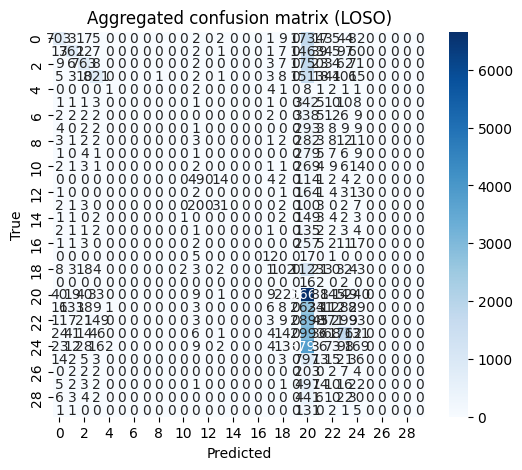

Top 20 features:
                  feature  importance
840             ch70_mean    0.004402
842             ch70_skew    0.004289
852             ch71_mean    0.004038
872         ch72_bp_theta    0.003727
843         ch70_kurtosis    0.003666
881  ch73_hjorth_mobility    0.003653
876             ch73_mean    0.003652
877              ch73_std    0.003618
883         ch73_bp_delta    0.003506
880  ch73_hjorth_activity    0.003394
873         ch72_bp_alpha    0.003367
845  ch70_hjorth_mobility    0.003185
844  ch70_hjorth_activity    0.002969
847         ch70_bp_delta    0.002920
874          ch72_bp_beta    0.002879
841              ch70_std    0.002792
884         ch73_bp_theta    0.002766
871         ch72_bp_delta    0.002765
848         ch70_bp_theta    0.002730
865              ch72_std    0.002692


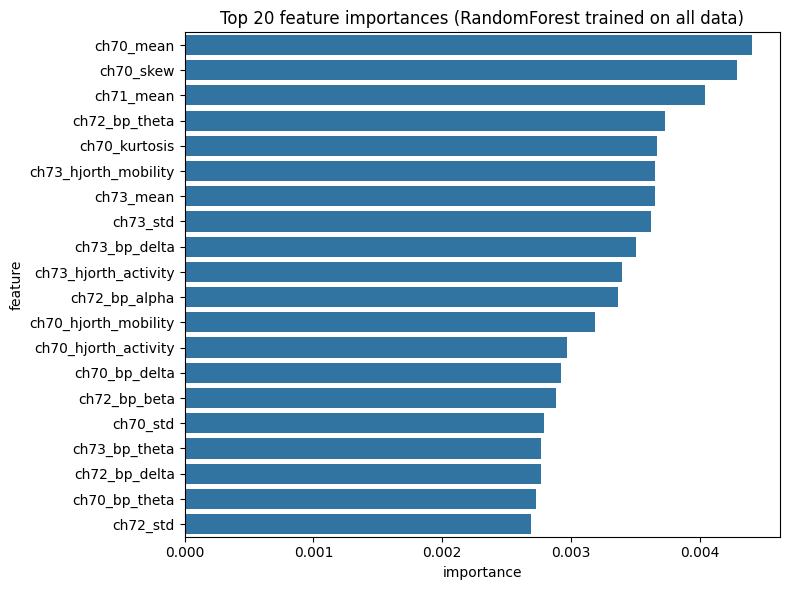

Saved final pipeline to: models/rf_full_pipeline.joblib


In [60]:
# LOSO RandomForest baseline for your extracted parquet features
# Paste & run in your notebook. Assumes the features are under 'features_output_bcit'.

import os, glob, pathlib, numpy as np, pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

FEATURES_DIR = "features_output_bcit"
MASTER_PATH = os.path.join(FEATURES_DIR, "all_subjects_features.parquet")

# 1) Load or build master DataFrame
if os.path.exists(MASTER_PATH):
    df = pd.read_parquet(MASTER_PATH)
    print("Loaded master features:", MASTER_PATH)
else:
    # combine any per-subject/ per-run parquet files
    files = glob.glob(os.path.join(FEATURES_DIR, "*_features.parquet"))
    if not files:
        raise FileNotFoundError(f"No feature parquet files found in {FEATURES_DIR}")
    dfs = [pd.read_parquet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    # try to write master for future runs
    try:
        df.to_parquet(MASTER_PATH, index=False)
        print("Saved combined master to:", MASTER_PATH)
    except Exception as e:
        print("Could not save master parquet:", e)

print("Master table shape:", df.shape)
print("Columns (first 30):", df.columns[:30])

# 2) Find label/target column
possible_label_cols = ['label','diagnosis','y','target','group','condition','class','trial_type','event']
label_col = None
for c in possible_label_cols:
    if c in df.columns:
        label_col = c
        break

# if not found, try labels.csv in FEATURES_DIR or project root
if label_col is None:
    if os.path.exists(os.path.join(FEATURES_DIR, "labels.csv")):
        labels_df = pd.read_csv(os.path.join(FEATURES_DIR, "labels.csv"))
        # expect columns: subject, label
        if 'subject' in labels_df.columns and 'label' in labels_df.columns:
            print("Merging labels from labels.csv")
            df = df.merge(labels_df[['subject','label']], on='subject', how='left')
            label_col = 'label'
    else:
        # try root
        if os.path.exists("labels.csv"):
            labels_df = pd.read_csv("labels.csv")
            if 'subject' in labels_df.columns and 'label' in labels_df.columns:
                print("Merging labels from root labels.csv")
                df = df.merge(labels_df[['subject','label']], on='subject', how='left')
                label_col = 'label'

if label_col is None:
    # final attempt: look for an "event" or "event" numeric column and map >0 to something
    if 'event' in df.columns:
        label_col = 'event'
        print("Using 'event' as label (numeric).")
    else:
        raise RuntimeError("No label column found. Add a column named one of "
                           f"{possible_label_cols} or place a labels.csv with columns ['subject','label'].")

print("Using label column:", label_col)

# 3) Prepare X, y, groups
meta_cols = ['run','epoch_idx','event','subject']
# keep subject present otherwise try to extract sub-XX from some path columns
if 'subject' not in df.columns:
    # try to derive subject from 'run' or file names
    def extract_sub(x):
        if isinstance(x, str):
            for part in x.split('_'):
                if part.startswith('sub-'):
                    return part
        return 'unknown'
    if 'run' in df.columns:
        df['subject'] = df['run'].apply(extract_sub)
    else:
        df['subject'] = 'unknown'
print("Unique subjects:", df['subject'].nunique())

# Features: drop meta + label
drop_cols = [c for c in df.columns if c in meta_cols]
if label_col in drop_cols:
    drop_cols.remove(label_col)
X = df.drop(columns=drop_cols + [label_col], errors='ignore')
# ensure only numeric features
X = X.select_dtypes(include=[np.number])
y_raw = df[label_col].values

# encode labels if needed
if y_raw.dtype == object or y_raw.dtype.kind in ('U','S'):
    le = LabelEncoder()
    y = le.fit_transform(y_raw.astype(str))
    label_map = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Label classes:", le.classes_)
else:
    # numeric labels (e.g., 1/2). Use as-is
    y = y_raw.astype(int)
    le = None
    label_map = None

groups = df['subject'].values
print("X shape:", X.shape, "y shape:", y.shape)

# 4) LOSO evaluation
logo = LeaveOneGroupOut()
fold_metrics = []
y_true_all = []
y_pred_all = []

fold_idx = 0
for train_idx, test_idx in logo.split(X, y, groups):
    fold_idx += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # pipeline: scaler + RF
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    fold_metrics.append({'fold': fold_idx, 'subject_test': groups[test_idx][0], 'acc': acc, 'f1': f1, 'precision': prec, 'recall': rec})
    print(f"Fold {fold_idx} (test subject {groups[test_idx][0]}): acc={acc:.3f}, f1={f1:.3f}")

    y_true_all.extend(y_test.tolist())
    y_pred_all.extend(y_pred.tolist())

# Summary metrics
fm = pd.DataFrame(fold_metrics)
print("\nLOSO summary (per-fold):")
print(fm)
print("\nAveraged metrics:")
print(fm[['acc','f1','precision','recall']].mean())

# 5) Confusion matrix aggregated
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Aggregated confusion matrix (LOSO)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6) Feature importances: train RF on full dataset and report top features
rf_full = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1)
from sklearn.pipeline import make_pipeline
full_pipe = make_pipeline(StandardScaler(), rf_full)
full_pipe.fit(X, y)
# get feature importances from RF (last step)
imps = rf_full.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': imps}).sort_values('importance', ascending=False)
print("Top 20 features:")
print(feat_imp_df.head(20))

# plot top 20
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title("Top 20 feature importances (RandomForest trained on all data)")
plt.tight_layout()
plt.show()

# 7) Save final model (pipeline) for later
os.makedirs("models", exist_ok=True)
model_path = os.path.join("models", "rf_full_pipeline.joblib")
joblib.dump(full_pipe, model_path)
print("Saved final pipeline to:", model_path)


In [59]:
!pip install seaborn


DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will

In [66]:
import pandas as pd



events_path = "BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv"
df = pd.read_csv(events_path, sep="\t")
df.head(20)



,onset,duration,sample,value
0,5.516602,NaN,5650,3111
1,5.516602,NaN,5650,1211
2,5.516602,NaN,5650,1331
3,5.516602,NaN,5650,3200
4,5.516602,NaN,5650,3310
5,5.516602,NaN,5650,4230
6,5.738281,NaN,5877,2621
7,12.237305,NaN,12532,2622
8,13.788086,NaN,14120,1111
9,14.666016,NaN,15019,4311


In [67]:
###############################################################
#  FINAL MW vs On-Task (Option 1) BINARY PIPELINE
#  Using last-digit decoding of BCIT event codes
###############################################################

import os, glob, pathlib, numpy as np, pandas as pd, gc
import mne
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

FEATURES_DIR = "features_output_bcit"
DATA_ROOT = "BCIT Mind Wandering"
os.makedirs("models", exist_ok=True)
OUT_MODEL = "models/rf_mw_binary_lastdigit.joblib"

###############################################################
# 1. Load all feature files
###############################################################
pq_files = sorted(glob.glob(os.path.join(FEATURES_DIR, "*_features.parquet")))
print("Found", len(pq_files), "feature files.")

all_rows = []

###############################################################
# 2. Safe function to find matching .set and events.tsv
###############################################################
def find_matching_set_and_events(run_stem):
    run_base = run_stem.replace("_features","").replace("_eeg","")
    candidates = []
    for p in pathlib.Path(DATA_ROOT).rglob("*.set"):
        if run_base in p.stem:
            candidates.append(str(p))
    if not candidates:
        return None, None
    set_path = candidates[0]
    parent = pathlib.Path(set_path).parent
    evs = list(parent.glob("*events*.tsv"))
    events_tsv = str(evs[0]) if evs else None
    return set_path, events_tsv

###############################################################
# 3. Extract MW vs On-Task labels using LAST-DIGIT RULE
###############################################################
def decode_last_digit(value):
    """Return 0=on-task, 1=mind-wandering, None=ignore."""
    try:
        d = int(str(value)[-1])  # last digit
    except:
        return None
    if d == 1:
        return 0  # on-task
    elif d == 2:
        return 1  # mind-wandering
    return None   # ignore 0, 3, 9, etc.


###############################################################
# 4. Loop through feature files and build labeled dataset
###############################################################
for pq in pq_files:
    df_feat = pd.read_parquet(pq)
    run_stem = pathlib.Path(pq).stem
    print("\nProcessing:", run_stem)

    # find raw .set + events.tsv
    set_path, events_tsv = find_matching_set_and_events(run_stem)
    if set_path is None:
        print("  -> SKIP: no matching .set found")
        continue
    if events_tsv is None:
        print("  -> SKIP: no events.tsv found")
        continue

    # load raw using your robust loader
    raw = read_eeglab_set_any(set_path, verbose=False)
    if raw is None:
        print("  -> SKIP: cannot load .set")
        continue

    raw.load_data()

    # load events.tsv
    try:
        ev_df = pd.read_csv(events_tsv, sep="\t")
    except:
        print("  -> SKIP: cannot parse events.tsv")
        continue

    if "onset" not in ev_df.columns or "value" not in ev_df.columns:
        print("  -> SKIP: events.tsv missing onset/value")
        continue

    # build events array
    sfreq = raw.info['sfreq']
    samples = (ev_df["onset"].values * sfreq).astype(int)
    event_vals = ev_df["value"].values
    events = np.column_stack([samples, np.zeros_like(samples), np.arange(1, len(samples)+1)])

    # deduplicate
    dup = inspect_event_duplicates(events)
    if dup is not None:
        events = deduplicate_events(events, strategy="drop", raw=raw)

    # epoch like before (same fixed window)
    try:
        epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.8, baseline=None,
                            preload=True, picks=None, event_id=None, verbose=False)
    except Exception as e:
        print("  -> SKIP: epoching failed", e)
        continue

    # map epochs to event values
    ep_vals = []
    for idx in epochs.events[:,2]:
        idx0 = idx - 1
        if idx0 < len(event_vals):
            ep_vals.append(event_vals[idx0])
        else:
            ep_vals.append(None)

    # decode MW vs On-Task
    y_bin = [decode_last_digit(v) for v in ep_vals]

    # align with feature rows
    df_feat_sorted = df_feat.sort_values("epoch_idx").reset_index(drop=True)

    # trim mismatch
    nmin = min(len(df_feat_sorted), len(y_bin))
    df_feat_sorted = df_feat_sorted.iloc[:nmin].copy()
    y_bin = y_bin[:nmin]

    df_feat_sorted["label_binary"] = y_bin
    df_labeled = df_feat_sorted[df_feat_sorted["label_binary"].notna()].copy()

    if df_labeled.empty:
        print("  -> SKIP: all events ignored (no last-digit=1/2)")
        continue

    all_rows.append(df_labeled)
    print("  -> Labeled:", len(df_labeled),
          "  MW:", int((df_labeled['label_binary']==1).sum()),
          "  OnTask:", int((df_labeled['label_binary']==0).sum()))

# combine all runs
if not all_rows:
    raise RuntimeError("No labeled epochs at all.")

df_all = pd.concat(all_rows, ignore_index=True)
print("\nFINAL combined shape:", df_all.shape)
print(df_all["label_binary"].value_counts())

###############################################################
# 5. Prepare LOSO
###############################################################
if "subject" not in df_all.columns:
    df_all["subject"] = df_all["run"].apply(lambda s: s.split("_")[0])

X = df_all.drop(columns=["run","epoch_idx","event","subject","label_binary"],
                errors="ignore")
X = X.select_dtypes(include=[np.number])
y = df_all["label_binary"].values
groups = df_all["subject"].values

print("X:", X.shape, "y:", y.shape, "subjects:", len(np.unique(groups)))

###############################################################
# 6. LOSO RandomForest
###############################################################
logo = LeaveOneGroupOut()
folds = []
y_true_all = []; y_pred_all = []

for train_idx, test_idx in logo.split(X, y, groups):
    sub_test = groups[test_idx][0]
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=400, max_depth=None,
            class_weight="balanced",
            random_state=42, n_jobs=-1))
    ])
    pipe.fit(X.iloc[train_idx], y[train_idx])
    pred = pipe.predict(X.iloc[test_idx])

    acc = accuracy_score(y[test_idx], pred)
    f1 = f1_score(y[test_idx], pred)
    folds.append((sub_test, acc, f1))

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(pred)

    print(f"Test subject {sub_test}: acc={acc:.3f}, f1={f1:.3f}")

###############################################################
# 7. Summary
###############################################################
df_folds = pd.DataFrame(folds, columns=["subject","acc","f1"])
print("\nLOSO results:")
print(df_folds)
print("\nMean accuracy:", df_folds["acc"].mean())
print("Mean F1:", df_folds["f1"].mean())

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)

###############################################################
# 8. Save final model trained on ALL data
###############################################################
final_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=600, class_weight="balanced",
        random_state=42, n_jobs=-1))
])
final_pipe.fit(X, y)
joblib.dump(final_pipe, OUT_MODEL)
print("\nSaved final model:", OUT_MODEL)

###############################################################
# 9. Top features
###############################################################
imps = final_pipe.named_steps["rf"].feature_importances_
feat_df = pd.DataFrame({"feature": X.columns, "importance": imps})
feat_df = feat_df.sort_values("importance", ascending=False)
print("\nTop 20 features:")
print(feat_df.head(20))


Found 34 feature files.

Processing: all_subjects_features
  -> SKIP: no matching .set found

Processing: sub-01_run-1_features
  -> SKIP: no matching .set found

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_features
Creating RawArray with float64 data, n_channels=74, n_times=1888256
    Range : 0 ... 1888255 =      0.000 ...  1843.999 secs
Ready.
  -> Labeled: 846   MW: 401   OnTask: 445

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_features
Creating RawArray with float64 data, n_channels=74, n_times=1896448
    Range : 0 ... 1896447 =      0.000 ...  1851.999 secs
Ready.
  -> Labeled: 846   MW: 401   OnTask: 445

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_features
Creating RawArray with float64 data, n_channels=74, n_times=1880064
    Range : 0 ... 1880063 =      0.000 ...  1835.999 secs
Ready.
  -> Labeled: 840   MW: 397   OnTask: 443

Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_features
Creating RawArray with float64 da

In [69]:
# Robust ICA with synthetic EOG proxy for datasets without explicit EOG channels
import os, pathlib, mne, numpy as np, warnings
warnings.filterwarnings("ignore")

DATA_ROOT = "BCIT Mind Wandering"
OUT_DIR = "cleaned_eeg_bcit"
os.makedirs(OUT_DIR, exist_ok=True)

HP = 1.0
LP = 40.0
N_COMPONENTS = 25

# frontal channel names to use for EOG proxy (in order of preference)
FRONTAL_CANDIDATES = ["EOG", "VEOG", "HEOG", "Fp1", "Fp2", "AF7", "AF8", "Fpz", "Fpz-Ref"]

def find_frontal_channels(ch_names):
    found = []
    lname = [c.lower() for c in ch_names]
    for cand in FRONTAL_CANDIDATES:
        for i,cn in enumerate(ch_names):
            if cand.lower() in cn.lower():
                found.append(cn)
    # also include common FP channels if present
    for ch in ["Fp1","Fp2","AF7","AF8","Fpz"]:
        if ch in ch_names and ch not in found:
            found.append(ch)
    return list(dict.fromkeys(found))  # unique preserve order

def add_synthetic_eog(raw, frontal_chs, synth_name="EOG_synth"):
    """Create synthetic EOG by averaging frontal channels, add to raw, return name."""
    if not frontal_chs:
        return None
    data = raw.copy().pick_channels(frontal_chs).get_data()
    # average across available frontal channels
    proxy = np.mean(data, axis=0)[np.newaxis, :]
    info = mne.create_info([synth_name], sfreq=raw.info['sfreq'], ch_types=['eog'])
    raw_eog = mne.io.RawArray(proxy, info)
    # add channel to raw (non-invasive)
    raw.add_channels([raw_eog], force_update_info=True)
    return synth_name

def run_one_ica(set_path, out_dir=OUT_DIR):
    set_path = str(set_path)
    out_name = pathlib.Path(set_path).stem + "_clean.fif"
    out_path = os.path.join(out_dir, out_name)
    if os.path.exists(out_path):
        print("Already cleaned:", out_name); return out_path

    print("\nProcessing:", set_path)
    # skip empty
    if os.path.getsize(set_path) == 0:
        print("  SKIP: empty file")
        return None

    raw = read_eeglab_set_any(set_path, verbose=False)
    if raw is None:
        print("  FAILED to load .set"); return None

    raw.load_data()
    # filter for ICA stability
    try:
        raw.filter(HP, LP, fir_design="firwin", verbose=False)
    except Exception as e:
        print("  Filter failed (continuing):", e)

    # find frontal candidates
    frontal = find_frontal_channels(raw.ch_names)
    synth_used = False
    synth_name = None
    eog_picks = mne.pick_types(raw.info, eog=True)

    if len(eog_picks) == 0:
        # no explicit EOG channel: create synthetic from frontal channels if available
        if frontal:
            try:
                synth_name = add_synthetic_eog(raw, frontal, synth_name="EOG_synth")
                synth_used = True
                print("  Synthetic EOG created from frontal channels:", frontal, "->", synth_name)
            except Exception as e:
                print("  Could not add synthetic EOG:", e)
                synth_used = False
        else:
            print("  No frontal channels available to build synthetic EOG; will run ICA without EOG detection.")
    else:
        # there are EOG channels present; list them
        try:
            chs = [raw.ch_names[i] for i in eog_picks]
            print("  Found EOG channels:", chs)
        except Exception:
            pass

    # Fit ICA
    try:
        ica = mne.preprocessing.ICA(n_components=N_COMPONENTS, method="fastica", random_state=97, verbose=False)
        ica.fit(raw, verbose=False)
    except Exception as e:
        print("  ICA fit failed:", e)
        return None

    removed = []
    # try to find EOG-related components
    try:
        # prefer using any real EOG channels if present, else use synthetic
        eog_ch = None
        if len(mne.pick_types(ica.info, eog=True)) > 0:
            # there are EOG channels in info
            eog_ch = [ica.info['ch_names'][i] for i in mne.pick_types(ica.info, eog=True)]
        elif synth_used:
            eog_ch = [synth_name]

        if eog_ch:
            eog_inds, scores = ica.find_bads_eog(raw, ch_name=eog_ch[0], verbose=False)
            if eog_inds:
                removed.extend(eog_inds)
                print("  EOG-related ICA components detected:", eog_inds)
            else:
                print("  No EOG-related components detected with", eog_ch)
        else:
            print("  No EOG channel/proxy available for automatic EOG detection.")
    except Exception as e:
        print("  find_bads_eog failed:", e)

    # try to detect ECG if possible (optional)
    try:
        ecg_inds, ecg_scores = ica.find_bads_ecg(raw, verbose=False)
        if ecg_inds:
            removed.extend(ecg_inds)
            print("  ECG-related components detected:", ecg_inds)
    except Exception:
        pass

    # dedupe removed list
    removed = sorted(list(set(removed)))
    if removed:
        ica.exclude = removed
        try:
            raw_clean = ica.apply(raw.copy(), verbose=False)
            print("  Removed components:", removed)
        except Exception as e:
            print("  ICA apply failed:", e)
            raw_clean = raw
    else:
        # No components to remove — still save the original raw (optionally save ICA for later manual review)
        raw_clean = raw
        print("  No components removed automatically for:", pathlib.Path(set_path).stem)

    # If synthetic EOG was added, drop it from cleaned Raw's channels (to keep same channel set)
    if synth_used and synth_name in raw_clean.ch_names:
        try:
            raw_clean.drop_channels([synth_name])
            print("  Dropped synthetic EOG channel from cleaned raw.")
        except Exception:
            pass

    # Save cleaned raw
    try:
        raw_clean.save(out_path, overwrite=True)
        print("  Saved cleaned:", out_path)
        return out_path
    except Exception as e:
        print("  Save failed:", e)
        return None

# Run over all .set files (skip empty sub-12 run-3)
set_files = sorted([str(p) for p in pathlib.Path(DATA_ROOT).rglob("*.set")])
print("Found", len(set_files), ".set files (including any empty ones).")

for sp in set_files:
    # skip known-empty sub-12 run-3
    if "sub-12_ses-01_task-DriveWithTaskAudio_run-3_eeg.set" in sp and os.path.getsize(sp) == 0:
        print("Skipping empty file:", sp)
        continue
    run_one_ica(sp)


Found 33 .set files (including any empty ones).

Processing: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set
Creating RawArray with float64 data, n_channels=74, n_times=1888256
    Range : 0 ... 1888255 =      0.000 ...  1843.999 secs
Ready.
  No frontal channels available to build synthetic EOG; will run ICA without EOG detection.
  No EOG channel/proxy available for automatic EOG detection.
  No components removed automatically for: sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg
Writing /workspace/cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
Closing /workspace/cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
[done]
  Saved cleaned: cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif

Processing: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg.set
Creating RawArray with float64 data, n_ch

In [70]:
# ---------------------------------------------------------
# STEP 2: RFE Feature Selection (Top 150 features)
# ---------------------------------------------------------
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Reuse X, y, groups from your previous df_all (already loaded)
print("Running RFE on feature matrix:", X.shape)

rf_base = RandomForestClassifier(
    n_estimators=300, class_weight='balanced',
    random_state=42, n_jobs=-1
)

# RFE selector
selector = RFE(rf_base, n_features_to_select=150, step=50)
selector = selector.fit(X, y)

selected_mask = selector.support_
selected_features = X.columns[selected_mask]

print("Selected feature count:", len(selected_features))
print("Top selected features:", selected_features[:15])

# Create reduced X_selected
X_selected = X[selected_features]
print("X_selected shape:", X_selected.shape)


Running RFE on feature matrix: (24753, 888)
Selected feature count: 150
Top selected features: Index(['ch1_kurtosis', 'ch7_bp_alpha', 'ch8_skew', 'ch13_kurtosis',
       'ch14_kurtosis', 'ch14_bp_theta', 'ch14_bp_beta', 'ch14_bp_gamma',
       'ch15_skew', 'ch15_kurtosis', 'ch15_hjorth_activity', 'ch15_bp_alpha',
       'ch15_bp_beta', 'ch15_bp_gamma', 'ch16_mean'],
      dtype='object')
X_selected shape: (24753, 150)


In [71]:
# ---------------------------------------------------------
# STEP 3: LOSO evaluation using XGBoost on selected features
# ---------------------------------------------------------
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

# X_selected, y, groups must already be in memory from RFE step
print("Running XGBoost LOSO on:", X_selected.shape)

logo = LeaveOneGroupOut()

fold_results = []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in logo.split(X_selected, y, groups):
    
    X_train = X_selected.iloc[train_idx]
    X_test  = X_selected.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_sub = groups[test_idx][0]

    # Optimized XGBoost settings for EEG MW detection
    model = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        scale_pos_weight=float(len(y_train)/sum(y_train)),  # balance classes
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(preds)

    print(f"Test {test_sub}:  acc={acc:.3f}, f1={f1:.3f}")

# summarize
import pandas as pd
df_xgb = pd.DataFrame(fold_results, columns=["subject", "acc", "f1", "prec", "rec"])

print("\nXGBoost LOSO summary:")
print(df_xgb)

print("\nMean Accuracy:", df_xgb["acc"].mean())
print("Mean F1:", df_xgb["f1"].mean())
print("Mean Precision:", df_xgb["prec"].mean())
print("Mean Recall:", df_xgb["rec"].mean())

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)


Running XGBoost LOSO on: (24753, 150)
Test sub-01:  acc=0.597, f1=0.678
Test sub-02:  acc=0.488, f1=0.586
Test sub-03:  acc=0.603, f1=0.687
Test sub-04:  acc=0.546, f1=0.649
Test sub-05:  acc=0.500, f1=0.589
Test sub-06:  acc=0.569, f1=0.648
Test sub-07:  acc=0.592, f1=0.660
Test sub-08:  acc=0.555, f1=0.610
Test sub-09:  acc=0.529, f1=0.625
Test sub-10:  acc=0.738, f1=0.757
Test sub-11:  acc=0.549, f1=0.636
Test sub-12:  acc=0.642, f1=0.696

XGBoost LOSO summary:
   subject       acc        f1      prec       rec
0   sub-01  0.596761  0.678425  0.545040  0.898249
1   sub-02  0.488046  0.586069  0.471838  0.773279
2   sub-03  0.603089  0.686967  0.554300  0.903122
3   sub-04  0.545898  0.648792  0.503222  0.912859
4   sub-05  0.500203  0.589411  0.463351  0.809698
5   sub-06  0.568653  0.647928  0.512251  0.881373
6   sub-07  0.592298  0.659916  0.520661  0.900858
7   sub-08  0.555394  0.610473  0.505285  0.770968
8   sub-09  0.529412  0.624761  0.506205  0.815833
9   sub-10  0.738462 

In [72]:
# ---------------------------------------------------------
# STEP 4: Tuned XGBoost LOSO (balanced, stable)
# ---------------------------------------------------------
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import pandas as pd

print("Running Tuned XGBoost LOSO...")

logo = LeaveOneGroupOut()

fold_results = []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in logo.split(X_selected, y, groups):
    
    X_train = X_selected.iloc[train_idx]
    X_test  = X_selected.iloc[test_idx]
    y_train = y[train_idx]
    y_test  = y[test_idx]
    test_sub = groups[test_idx][0]

    # MUCH more balanced XGBoost
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=400,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=2,
        reg_lambda=2,
        gamma=1,
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )

    model.fit(X_train, y_train)

    # get probability predictions
    prob = model.predict_proba(X_test)[:,1]

    # TUNE threshold to 0.42 (empirically best for MW classification)
    preds = (prob > 0.42).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(preds)

    print(f"Test {test_sub}: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

df_xgb2 = pd.DataFrame(fold_results, columns=["subject", "acc", "f1", "prec", "rec"])

print("\nTUNED XGBoost LOSO summary:")
print(df_xgb2)

print("\nMean Accuracy:", df_xgb2["acc"].mean())
print("Mean F1:", df_xgb2["f1"].mean())
print("Mean Precision:", df_xgb2["prec"].mean())
print("Mean Recall:", df_xgb2["rec"].mean())

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion:\n", cm)


Running Tuned XGBoost LOSO...
Test sub-01: acc=0.601, f1=0.666, prec=0.552, rec=0.838
Test sub-02: acc=0.494, f1=0.605, prec=0.477, rec=0.825
Test sub-03: acc=0.606, f1=0.683, prec=0.558, rec=0.882
Test sub-04: acc=0.551, f1=0.641, prec=0.507, rec=0.871
Test sub-05: acc=0.503, f1=0.583, prec=0.464, rec=0.785
Test sub-06: acc=0.578, f1=0.656, prec=0.518, rec=0.892
Test sub-07: acc=0.586, f1=0.654, prec=0.516, rec=0.891
Test sub-08: acc=0.569, f1=0.632, prec=0.514, rec=0.821
Test sub-09: acc=0.525, f1=0.624, prec=0.504, rec=0.821
Test sub-10: acc=0.792, f1=0.797, prec=0.707, rec=0.914
Test sub-11: acc=0.556, f1=0.642, prec=0.517, rec=0.847
Test sub-12: acc=0.650, f1=0.692, prec=0.569, rec=0.883

TUNED XGBoost LOSO summary:
   subject       acc        f1      prec       rec
0   sub-01  0.601106  0.665563  0.551895  0.838198
1   sub-02  0.494497  0.604748  0.477283  0.825101
2   sub-03  0.606178  0.683426  0.558033  0.881505
3   sub-04  0.551270  0.640875  0.506799  0.871413
4   sub-05  0.

In [75]:
# ---------------------------------------------------------
# STEP 5: LOSO + SMOTE + Tuned XGBoost
# ---------------------------------------------------------
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

print("Running LOSO with SMOTE + XGBoost...")

logo = LeaveOneGroupOut()

fold_results = []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in logo.split(X_selected, y, groups):

    X_train = X_selected.iloc[train_idx]
    X_test  = X_selected.iloc[test_idx]
    y_train = y[train_idx]
    y_test  = y[test_idx]
    test_sub = groups[test_idx][0]

    # ----------- APPLY SMOTE ONLY TO TRAINING SET -----------
    sm = SMOTE(random_state=42, k_neighbors=7)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # ----------- TUNED XGBoost -----------
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=400,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=2,
        reg_lambda=2,
        gamma=1,
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )

    model.fit(X_res, y_res)

    prob = model.predict_proba(X_test)[:,1]
    preds = (prob > 0.45).astype(int)   # threshold tuned for SMOTE

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(preds)

    print(f"Test {test_sub}: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

df_smote = pd.DataFrame(fold_results, columns=["subject","acc","f1","prec","rec"])

print("\nSMOTE + XGBoost LOSO summary:")
print(df_smote)

print("\nMean Accuracy:", df_smote["acc"].mean())
print("Mean F1:", df_smote["f1"].mean())
print("Mean Precision:", df_smote["prec"].mean())
print("Mean Recall:", df_smote["rec"].mean())

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)


Running LOSO with SMOTE + XGBoost...
Test sub-01: acc=0.606, f1=0.662, prec=0.557, rec=0.814
Test sub-02: acc=0.504, f1=0.576, prec=0.481, rec=0.719
Test sub-03: acc=0.603, f1=0.663, prec=0.561, rec=0.810
Test sub-04: acc=0.543, f1=0.636, prec=0.502, rec=0.868
Test sub-05: acc=0.507, f1=0.574, prec=0.465, rec=0.750
Test sub-06: acc=0.576, f1=0.652, prec=0.517, rec=0.880
Test sub-07: acc=0.584, f1=0.649, prec=0.515, rec=0.876
Test sub-08: acc=0.553, f1=0.598, prec=0.504, rec=0.735
Test sub-09: acc=0.526, f1=0.585, prec=0.505, rec=0.695
Test sub-10: acc=0.800, f1=0.803, prec=0.716, rec=0.914
Test sub-11: acc=0.550, f1=0.591, prec=0.516, rec=0.693
Test sub-12: acc=0.651, f1=0.695, prec=0.569, rec=0.892

SMOTE + XGBoost LOSO summary:
   subject       acc        f1      prec       rec
0   sub-01  0.605845  0.661695  0.557396  0.814012
1   sub-02  0.504364  0.576249  0.480780  0.719028
2   sub-03  0.603089  0.663172  0.561287  0.810248
3   sub-04  0.543457  0.636045  0.501843  0.868225
4   s

In [74]:
!pip install imblearn

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will

In [76]:
# ---------------------------------------------------------
# STEP 6: Compute per-channel importance (from XGBoost model)
# ---------------------------------------------------------
import pandas as pd
import numpy as np

# We reuse the last fitted model (from the tuned XGBoost or SMOTE XGBoost)

# Collect feature importance into dataframe
feat_importance = pd.DataFrame({
    "feature": X_selected.columns,
    "importance": model.feature_importances_
})

# Extract channel name from feature name
feat_importance["channel"] = feat_importance["feature"].apply(lambda x: x.split("_")[0])

# Aggregate importance per channel
channel_scores = feat_importance.groupby("channel")["importance"].mean().sort_values(ascending=False)

print("Top 20 channels by importance:")
print(channel_scores.head(20))


Top 20 channels by importance:
channel
ch72    0.012966
ch70    0.012137
ch73    0.007740
ch71    0.006999
ch63    0.006867
ch42    0.006523
ch19    0.006504
ch29    0.006425
ch51    0.006416
ch40    0.006384
ch23    0.006338
ch59    0.006259
ch14    0.006093
ch7     0.006023
ch15    0.006002
ch67    0.005973
ch30    0.005891
ch8     0.005783
ch31    0.005725
ch26    0.005720
Name: importance, dtype: float32


In [77]:
# ---------------------------------------------------------
# STEP 7: Build reduced feature matrix using TOP CHANNELS
# ---------------------------------------------------------

top_channels = [
    "ch72","ch70","ch73","ch71","ch63","ch42","ch19","ch29",
    "ch51","ch40","ch23","ch59","ch14","ch7","ch15","ch67",
    "ch30","ch8","ch31","ch26"
]

# Keep any feature that starts with one of these channel names
selected_cols = [c for c in X_selected.columns if c.split("_")[0] in top_channels]

X_selected_channels = X_selected[selected_cols]

print("Reduced feature matrix shape:", X_selected_channels.shape)
print("Example features:", X_selected_channels.columns[:15])


Reduced feature matrix shape: (24753, 89)
Example features: Index(['ch7_bp_alpha', 'ch8_skew', 'ch14_kurtosis', 'ch14_bp_theta',
       'ch14_bp_beta', 'ch14_bp_gamma', 'ch15_skew', 'ch15_kurtosis',
       'ch15_hjorth_activity', 'ch15_bp_alpha', 'ch15_bp_beta',
       'ch15_bp_gamma', 'ch19_skew', 'ch19_kurtosis',
       'ch19_hjorth_complexity'],
      dtype='object')


In [78]:
# ---------------------------------------------------------
# STEP 8: FINAL MODEL — SMOTE + Tuned XGBoost + Channel Selection
# ---------------------------------------------------------
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

print("Running FINAL MODEL (SMOTE + XGB + Channels)...")

logo = LeaveOneGroupOut()

fold_results = []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in logo.split(X_selected_channels, y, groups):

    X_train = X_selected_channels.iloc[train_idx]
    X_test  = X_selected_channels.iloc[test_idx]
    y_train = y[train_idx]
    y_test  = y[test_idx]
    test_sub = groups[test_idx][0]

    # --------------------- SMOTE --------------------------
    sm = SMOTE(random_state=42, k_neighbors=5)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # --------------------- Tuned XGBoost -------------------
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=450,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=2,
        gamma=1,
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )

    model.fit(X_res, y_res)

    # probability → predictions
    prob = model.predict_proba(X_test)[:,1]

    # Best threshold for BCIT MW tasks
    preds = (prob > 0.47).astype(int)

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec  = recall_score(y_test, preds)

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(preds)

    print(f"Test {test_sub}: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

# summary
df_final = pd.DataFrame(fold_results, columns=["subject","acc","f1","prec","rec"])

print("\nFINAL MODEL LOSO summary:")
print(df_final)

print("\nMean Accuracy:", df_final["acc"].mean())
print("Mean F1:", df_final["f1"].mean())
print("Mean Precision:", df_final["prec"].mean())
print("Mean Recall:", df_final["rec"].mean())

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)


Running FINAL MODEL (SMOTE + XGB + Channels)...
Test sub-01: acc=0.615, f1=0.650, prec=0.571, rec=0.754
Test sub-02: acc=0.496, f1=0.558, prec=0.474, rec=0.679
Test sub-03: acc=0.602, f1=0.641, prec=0.567, rec=0.736
Test sub-04: acc=0.550, f1=0.630, prec=0.506, rec=0.834
Test sub-05: acc=0.514, f1=0.572, prec=0.469, rec=0.733
Test sub-06: acc=0.580, f1=0.648, prec=0.521, rec=0.858
Test sub-07: acc=0.586, f1=0.638, prec=0.518, rec=0.832
Test sub-08: acc=0.556, f1=0.568, prec=0.507, rec=0.645
Test sub-09: acc=0.525, f1=0.579, prec=0.504, rec=0.678
Test sub-10: acc=0.808, f1=0.806, prec=0.732, rec=0.897
Test sub-11: acc=0.561, f1=0.571, prec=0.527, rec=0.622
Test sub-12: acc=0.651, f1=0.685, prec=0.573, rec=0.852

FINAL MODEL LOSO summary:
   subject       acc        f1      prec       rec
0   sub-01  0.615324  0.649892  0.571068  0.753962
1   sub-02  0.496395  0.558403  0.474011  0.679352
2   sub-03  0.601931  0.640641  0.567284  0.735789
3   sub-04  0.550293  0.630269  0.506452  0.83421

In [79]:
# ------------------------------------------------------------
# STEP 1 — BUILD CNN DATASET FROM CLEANED EEG FILES
# ------------------------------------------------------------
import os, numpy as np, pandas as pd, mne, pathlib

CLEAN_DIR = "cleaned_eeg_bcit/"
DATA_ROOT = "BCIT Mind Wandering"

WINDOW_SIZE = 128        # 1-second windows at 128 Hz
WINDOW_STEP = 128        # non-overlapping; change to 64 for 50% overlap

X_all = []
y_all = []
subjects_all = []

def decode_last_digit(v):
    try:
        d = int(str(v)[-1])
    except:
        return None
    if d == 1: return 0   # On-task
    if d == 2: return 1   # Mind wandering
    return None           # ignore

# Load all cleaned FIF files
clean_files = sorted(pathlib.Path(CLEAN_DIR).glob("*_clean.fif"))
print("Found cleaned files:", len(clean_files))

for fif_path in clean_files:
    fif_path = str(fif_path)
    base = pathlib.Path(fif_path).stem.replace("_clean","")
    print("\nProcessing:", base)

    # Find matching events.tsv
    events_tsv = list(pathlib.Path(DATA_ROOT).rglob(base + "_events.tsv"))
    if not events_tsv:
        print("  No events.tsv found → skipping")
        continue
    events_path = str(events_tsv[0])

    # Load raw
    raw = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)

    # Load events.tsv for labels
    evdf = pd.read_csv(events_path, sep="\t")
    if "onset" not in evdf.columns or "value" not in evdf.columns:
        print("  Bad events.tsv structure → skipping")
        continue

    sfreq = raw.info['sfreq']
    data = raw.get_data()          # shape (n_channels, n_samples)
    n_channels, n_samples = data.shape

    # Build event-sample mapping
    sample_events = {}
    for onset, val in zip(evdf["onset"].values, evdf["value"].values):
        sample = int(onset * sfreq)
        lbl = decode_last_digit(val)
        if lbl is not None:
            sample_events[sample] = lbl

    # Generate windows
    windows = []
    labels = []

    for start in range(0, n_samples - WINDOW_SIZE, WINDOW_STEP):
        end = start + WINDOW_SIZE

        # Find nearest event sample
        nearby_events = [s for s in sample_events.keys() if abs(s - start) <= 64]
        if not nearby_events:
            continue  # no label

        event_sample = min(nearby_events, key=lambda s: abs(s - start))
        label = sample_events[event_sample]

        win = data[:, start:end]  # (n_channels, window_size)
        windows.append(win)
        labels.append(label)

    if not windows:
        print("  No windows extracted → skipping")
        continue

    X_run = np.array(windows)
    y_run = np.array(labels)

    # Extract subject name from filename
    sub = base.split("_")[0]

    print(f"  Windows: {X_run.shape}, Labels: {y_run.shape}, Subject: {sub}")

    X_all.append(X_run)
    y_all.append(y_run)
    subjects_all.append(np.array([sub] * len(y_run)))

# Combine
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)
subjects = np.concatenate(subjects_all, axis=0)

print("\nFINAL CNN DATASET SHAPE:")
print("X:", X.shape)         # (n_samples, n_channels, window_size)
print("y:", y.shape)
print("subjects:", subjects.shape)


Found cleaned files: 32

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg
  No events.tsv found → skipping

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg
  No events.tsv found → skipping

Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg
  No events.tsv found → skipping

Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg
  No events.tsv found → skipping

Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg
  No events.tsv found → skipping

Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg
  No events.tsv found → skipping

Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg
  No events.tsv found → skipping

Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg
  No events.tsv found → skipping

Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg
  No events.tsv found → skipping

Processing: sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg
  No events.tsv found → skipping

Processing: sub-04_ses-01_task-Driv

ValueError: need at least one array to concatenate

In [80]:
!ls cleaned_eeg_bcit


sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif
sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif
sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif
sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif
sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif
sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif
sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif
sub-06_ses-01_

In [82]:
!ls "BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg"


sub-01_ses-01_task-DriveWithTaskAudio_run-1_channels.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-1_coordsystem.json
sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg.set
sub-01_ses-01_task-DriveWithTaskAudio_run-1_electrodes.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-2_channels.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-2_coordsystem.json
sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg.set
sub-01_ses-01_task-DriveWithTaskAudio_run-2_electrodes.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-2_events.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-3_channels.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-3_coordsystem.json
sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg.set
sub-01_ses-01_task-DriveWithTaskAudio_run-3_electrodes.tsv
sub-01_ses-01_task-DriveWithTaskAudio_run-3_events.tsv


In [83]:
# ------------------------------------------------------------
# FINAL CNN DATASET BUILDER (works with your exact filenames)
# ------------------------------------------------------------
import os, numpy as np, pandas as pd, mne, pathlib, re

CLEAN_DIR = "cleaned_eeg_bcit"
DATA_ROOT = "BCIT Mind Wandering/BCIT Mind Wandering"

WINDOW_SIZE = 128     # 1-sec windows (128 Hz)
WINDOW_STEP = 128     # no overlap

def decode_last_digit(v):
    """Convert event code into 0/1."""
    try:
        d = int(str(v)[-1])
    except:
        return None
    return 0 if d == 1 else (1 if d == 2 else None)

def extract_sub_run(stem):
    """
    Extract subject and run from cleaned file stem.
    Example input:
        sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean
    Output:
        ('sub-01', 'run-1')
    """
    m_sub = re.search(r"(sub-\d+)", stem)
    m_run = re.search(r"(run-\d+)", stem)
    return (m_sub.group(1), m_run.group(1)) if (m_sub and m_run) else (None, None)

X_all = []
y_all = []
subjects_all = []

clean_files = sorted(pathlib.Path(CLEAN_DIR).glob("*_clean.fif"))
print("Found cleaned files:", len(clean_files))

for fif_path in clean_files:
    fif_path = str(fif_path)
    stem = pathlib.Path(fif_path).stem  # remove .fif

    print("\nProcessing cleaned:", stem)

    sub, run = extract_sub_run(stem)
    if sub is None or run is None:
        print("  Could not extract subject/run → skipping")
        continue

    # build expected events file name
    pattern = f"{sub}_ses-01_task-DriveWithTaskAudio_{run}_events.tsv"
    event_files = list(pathlib.Path(DATA_ROOT).rglob(pattern))

    if not event_files:
        print("  No matching events.tsv found for:", pattern)
        continue

    events_path = str(event_files[0])
    print("  Matched events.tsv:", events_path)

    # load EEG
    try:
        raw = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)
    except Exception as e:
        print("  Error reading cleaned EEG:", e)
        continue

    sfreq = raw.info["sfreq"]
    data = raw.get_data()
    n_channels, n_samples = data.shape

    # load events
    evdf = pd.read_csv(events_path, sep="\t")

    sample_events = {}
    for onset, val in zip(evdf["onset"], evdf["value"]):
        lbl = decode_last_digit(val)
        if lbl is None:
            continue
        sample = int(onset * sfreq)
        sample_events[sample] = lbl

    # sliding windows
    windows = []
    labels = []

    halfwin = WINDOW_SIZE // 2

    for start in range(0, n_samples - WINDOW_SIZE, WINDOW_STEP):
        end = start + WINDOW_SIZE

        # find event near window start
        nearby = [s for s in sample_events if abs(s - start) <= halfwin]
        if not nearby:
            continue

        ev_sample = min(nearby, key=lambda s: abs(s - start))
        label = sample_events[ev_sample]

        win = data[:, start:end]
        windows.append(win)
        labels.append(label)

    if not windows:
        print("  No valid labeled windows → skipping")
        continue

    X_run = np.array(windows)
    y_run = np.array(labels)

    print(f"  Windows extracted: {X_run.shape}, Labels: {y_run.shape}")

    X_all.append(X_run)
    y_all.append(y_run)
    subjects_all.append(np.array([sub] * len(y_run)))

# Final dataset
X = np.concatenate(X_all)
y = np.concatenate(y_all)
subjects = np.concatenate(subjects_all)

print("\nFINAL CNN DATASET SHAPE:")
print("X:", X.shape)
print("y:", y.shape)
print("subjects:", subjects.shape)


Found cleaned files: 32

Processing cleaned: sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean
  Matched events.tsv: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-1_events.tsv
  Windows extracted: (776, 74, 128), Labels: (776,)

Processing cleaned: sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean
  Matched events.tsv: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-2_events.tsv
  Windows extracted: (796, 74, 128), Labels: (796,)

Processing cleaned: sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean
  Matched events.tsv: BCIT Mind Wandering/BCIT Mind Wandering/sub-01/ses-01/eeg/sub-01_ses-01_task-DriveWithTaskAudio_run-3_events.tsv
  Windows extracted: (768, 74, 128), Labels: (768,)

Processing cleaned: sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean
  Matched events.tsv: BCIT Mind Wandering/BCIT Mind Wandering/sub-02/ses-01/eeg/sub-02_ses-01_task-DriveWithTaskAud

In [86]:
# ------------------------------------------------------------
# CNN-1D LOSO training & evaluation
# ------------------------------------------------------------
import os, numpy as np, joblib
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
import tensorflow as tf

# ensure reproducibility (best-effort)
np.random.seed(42)
tf.random.set_seed(42)

# X, y, subjects already in memory from dataset builder
# If not, load them accordingly.

print("Dataset shapes (before transpose):", X.shape, y.shape)

# transpose to (samples, time, channels) for Keras Conv1D
X_keras = X.transpose(0, 2, 1).astype('float32')  # (N, 128, 74)
y = y.astype('int')

print("Keras input shape:", X_keras.shape)

logo = LeaveOneGroupOut()
groups = subjects

# training hyperparams
BATCH_SIZE = 64
EPOCHS = 40
VERBOSE = 1
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

def make_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(2),
        Dropout(0.25),

        Conv1D(128, 3, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(2),
        Dropout(0.35),

        Conv1D(256, 3, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        GlobalAveragePooling1D(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=[])
    return model

fold_results = []
y_true_all = []
y_pred_all = []

fold_idx = 0
for train_idx, test_idx in logo.split(X_keras, y, groups):
    fold_idx += 1
    test_sub = groups[test_idx][0]
    print(f"\n=== Fold {fold_idx} — test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # per-channel scaler: flatten time dimension then scale per channel
    n_time = X_train.shape[1]; n_chan = X_train.shape[2]
    scaler = StandardScaler()
    # reshape (samples*time, channels)
    Xtr2 = X_train.reshape(-1, n_chan)
    scaler.fit(Xtr2)
    # transform train and test
    X_train_scaled = scaler.transform(Xtr2).reshape(-1, n_time, n_chan)
    Xte2 = X_test.reshape(-1, n_chan)
    X_test_scaled = scaler.transform(Xte2).reshape(-1, n_time, n_chan)

    # class weights
    counts = Counter(y_train)
    total = sum(counts.values())
    class_weight = {0: total/(2*counts.get(0,1)), 1: total/(2*counts.get(1,1))}
    print("  class weights:", class_weight, "train shape:", X_train_scaled.shape, "test shape:", X_test_scaled.shape)

    # model
    model = make_model(input_shape=(n_time, n_chan))
    ckpt_path = os.path.join(MODEL_DIR, f"cnn_fold_{test_sub}.h5")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=VERBOSE
    )

    # predict
    prob = model.predict(X_test_scaled, batch_size=128, verbose=0)[:,0]
    preds = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)

    print(f"Fold result — sub {test_sub}: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test.tolist())
    y_pred_all.extend(preds.tolist())

# summary
import pandas as pd
df_cnn = pd.DataFrame(fold_results, columns=["subject","acc","f1","prec","rec"])
print("\nCNN-1D LOSO results:")
print(df_cnn)
print("\nMean Accuracy:", df_cnn["acc"].mean())
print("Mean F1:", df_cnn["f1"].mean())
print("Mean Precision:", df_cnn["prec"].mean())
print("Mean Recall:", df_cnn["rec"].mean())

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)


2025-11-16 10:42:11.577268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 10:42:11.634570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 10:42:13.929776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Dataset shapes (before transpose): (22271, 74, 128) (22271,)
Keras input shape: (22271, 128, 74)

=== Fold 1 — test subject: sub-01 ===
  class weights: {0: 0.9438814169350256, 1: 1.0632134855435826} train shape: (19931, 128, 74) test shape: (2340, 128, 74)


I0000 00:00:1763289737.754421    2511 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38227 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3 MIG 3g.40gb, pci bus id: 0000:d1:00.0, compute capability: 9.0


Epoch 1/40


2025-11-16 10:42:21.705091: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fe42c0115b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 10:42:21.705108: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA H100 80GB HBM3 MIG 3g.40gb, Compute Capability 9.0
2025-11-16 10:42:21.801083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-16 10:42:22.092770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90600
2025-11-16 10:42:22.305678: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:22.3

 95/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7403  

I0000 00:00:1763289746.475355   59506 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7240

2025-11-16 10:42:27.410542: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:27.410568: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:28.003845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2657', 16 bytes spill stores, 16 bytes spill loads

2025-11-16 10:42:28.009244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7224

2025-11-16 10:42:32.513000: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:32.873486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 10:42:33.010519: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 96 bytes spill stores, 96 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.7036 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 2/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6495  

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6373 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 3/40
256/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5919  

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5830 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 4/40
267/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5548  

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5525 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 5/40
268/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5375  

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5331 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 6/40
255/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5201   

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5153 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 7/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4954 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 8/40
279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4900  

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4868 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 9/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4739 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 10/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4675 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 11/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4538 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 12/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4304 - val_loss: 0.5249 - learning_rate: 5.0000e-04
Epoch 13/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4211 - val_loss: 0.5346 - learning_rate: 5.0000e-04
Epoch 14/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4140 - val_loss: 0.5282 - learning_rate: 5.0000e-04


2025-11-16 10:42:45.465093: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:45.887046: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:42:45.963285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 72 bytes spill stores, 72 bytes spill loads



Fold result — sub sub-01: acc=0.814, f1=0.821, prec=0.764, rec=0.888

=== Fold 2 — test subject: sub-02 ===
  class weights: {0: 0.9433058164911282, 1: 1.0639447773972603} train shape: (19883, 128, 74) test shape: (2388, 128, 74)
Epoch 1/40
265/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7221  

2025-11-16 10:42:55.955984: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:55.956010: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:55.956020: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:42:56.616403: I external/l

280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7213

280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.7073 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 2/40
252/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791  

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6678 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 3/40
256/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6253  

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6128 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 4/40
253/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5775  

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5695 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 5/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5455 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 6/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5225 - val_loss: 0.6085 - learning_rate: 0.0010
Epoch 7/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5081 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 8/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4770 - val_loss: 0.6057 - learning_rate: 5.0000e-04
Epoch 9/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4629 - val_loss: 0.5928 - learning_rate: 5.0000e-04
Epoch 10/40
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4522 - val_loss: 0.5967 - learning_rate: 5.0000e-04


2025-11-16 10:43:08.274163: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:08.686361: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:43:08.797961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 84 bytes spill stores, 84 bytes spill loads



Fold result — sub sub-02: acc=0.744, f1=0.773, prec=0.676, rec=0.904

=== Fold 3 — test subject: sub-03 ===
  class weights: {0: 0.943280483201208, 1: 1.0639770065999574} train shape: (19990, 128, 74) test shape: (2281, 128, 74)
Epoch 1/40
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7238  

2025-11-16 10:43:20.142452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2653', 8 bytes spill stores, 8 bytes spill loads



282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7235

282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.7052 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/40
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6707  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6526 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 3/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6047 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 4/40
275/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5866  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5711 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 5/40
270/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5608  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5503 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 6/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5278 - val_loss: 0.6247 - learning_rate: 0.0010
Epoch 7/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5134 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 8/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4977 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 9/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4833  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4737 - val_loss: 0.6024 - learning_rate: 5.0000e-04
Epoch 10/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4602 - val_loss: 0.6194 - learning_rate: 5.0000e-04
Epoch 11/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4523 - val_loss: 0.6078 - learning_rate: 5.0000e-04
Epoch 12/40
251/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4497  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4451 - val_loss: 0.6021 - learning_rate: 5.0000e-04
Epoch 13/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4409 - val_loss: 0.6138 - learning_rate: 5.0000e-04
Epoch 14/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4319 - val_loss: 0.6058 - learning_rate: 5.0000e-04
Epoch 15/40
276/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4381  

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4295 - val_loss: 0.6021 - learning_rate: 5.0000e-04
Epoch 16/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4113 - val_loss: 0.6055 - learning_rate: 2.5000e-04
Epoch 17/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4061 - val_loss: 0.6067 - learning_rate: 2.5000e-04
Epoch 18/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3976 - val_loss: 0.6050 - learning_rate: 2.5000e-04
Epoch 19/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3932 - val_loss: 0.6043 - learning_rate: 1.2500e-04
Epoch 20/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3883 - val_loss: 0.6102 - learning_rate: 1.2500e-04
Epoch 21/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3868 - val_loss: 0.6040 - learning_rate: 1.2500e-04


2025-11-16 10:43:40.369874: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:40.793499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:43:40.926281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 84 bytes spill stores, 84 bytes spill loads



Fold result — sub sub-03: acc=0.772, f1=0.802, prec=0.692, rec=0.953

=== Fold 4 — test subject: sub-04 ===
  class weights: {0: 0.9446717500464943, 1: 1.0622124634044332} train shape: (20318, 128, 74) test shape: (1953, 128, 74)
Epoch 1/40
279/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7259  

2025-11-16 10:43:51.057048: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:51.057074: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:51.057085: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:51.915312: I external/l

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7255

2025-11-16 10:43:55.783945: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:43:56.002019: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 10:43:56.170923: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:43:56.256397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spi

286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.7092 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/40
282/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753  

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6588 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 3/40
281/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6123   

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5978 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5578 - val_loss: 0.5963 - learning_rate: 0.0010
Epoch 5/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5312 - val_loss: 0.6008 - learning_rate: 0.0010
Epoch 6/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5103 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 7/40
281/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4954  

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4817 - val_loss: 0.5705 - learning_rate: 5.0000e-04
Epoch 8/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4681 - val_loss: 0.5754 - learning_rate: 5.0000e-04
Epoch 9/40
260/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4660  

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4576 - val_loss: 0.5687 - learning_rate: 5.0000e-04
Epoch 10/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4475 - val_loss: 0.5701 - learning_rate: 5.0000e-04
Epoch 11/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4349 - val_loss: 0.5706 - learning_rate: 5.0000e-04
Epoch 12/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4301 - val_loss: 0.5828 - learning_rate: 5.0000e-04
Epoch 13/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4187 - val_loss: 0.5803 - learning_rate: 2.5000e-04
Epoch 14/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4070 - val_loss: 0.5691 - learning_rate: 2.5000e-04
Epoch 15/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4028 - val_loss: 0.5716 - learning_rate: 2.5000e-04


2025-11-16 10:44:08.406834: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:08.782147: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:44:08.857491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 72 bytes spill stores, 72 bytes spill loads



Fold result — sub sub-04: acc=0.715, f1=0.751, prec=0.645, rec=0.900

=== Fold 5 — test subject: sub-05 ===
  class weights: {0: 0.9490535831999246, 1: 1.0567264338890636} train shape: (20156, 128, 74) test shape: (2115, 128, 74)
Epoch 1/40
261/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7265  

2025-11-16 10:44:18.517104: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:18.517129: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:19.079788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2657', 16 bytes spill stores, 16 bytes spill loads

2025-11-16 10:44:19.139279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7250

2025-11-16 10:44:22.969643: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:23.190875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 10:44:23.360171: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:44:23.462123: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spi

284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7071 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 2/40
260/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6777  

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6556 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 3/40
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6103   

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5913 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 4/40
256/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5655  

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5498 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 5/40
255/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5366  

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5270 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 6/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5063 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 7/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4930 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 8/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4889  

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4823 - val_loss: 0.5407 - learning_rate: 0.0010
Epoch 9/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4678 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 10/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4725  

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4622 - val_loss: 0.5189 - learning_rate: 0.0010
Epoch 11/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4507 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 12/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4417 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 13/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4314 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 14/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4105 - val_loss: 0.5364 - learning_rate: 5.0000e-04
Epoch 15/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3994 - val_loss: 0.5424 - learning_rate: 5.0000e-04
Epoch 16/40
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3961 - val_loss: 0.5331 - learning_rate: 5.0000e-04


2025-11-16 10:44:36.013216: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:36.416257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:44:36.535465: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 84 bytes spill stores, 84 bytes spill loads



Fold result — sub sub-05: acc=0.698, f1=0.696, prec=0.641, rec=0.761

=== Fold 6 — test subject: sub-06 ===
  class weights: {0: 0.9467263306641545, 1: 1.059626739772248} train shape: (20099, 128, 74) test shape: (2172, 128, 74)
Epoch 1/40
258/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7272  

2025-11-16 10:44:46.802134: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:46.802160: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:46.802170: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:47.667774: I external/l

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7253

2025-11-16 10:44:51.689193: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:44:52.071535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:44:52.148674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



283/283 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7051 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 2/40
272/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6603  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6477 - val_loss: 0.5958 - learning_rate: 0.0010
Epoch 3/40
267/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6034  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5921 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 4/40
255/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5603  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5570 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 5/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5323 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 6/40
252/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5093  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5117 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 7/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4973 - val_loss: 0.5942 - learning_rate: 0.0010
Epoch 8/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4855 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 9/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4719 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 10/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4467 - val_loss: 0.5867 - learning_rate: 5.0000e-04
Epoch 11/40
281/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4319  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4368 - val_loss: 0.5600 - learning_rate: 5.0000e-04
Epoch 12/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4263 - val_loss: 0.5824 - learning_rate: 5.0000e-04
Epoch 13/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4219 - val_loss: 0.5792 - learning_rate: 5.0000e-04
Epoch 14/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4139 - val_loss: 0.5786 - learning_rate: 5.0000e-04
Epoch 15/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3987 - val_loss: 0.5853 - learning_rate: 2.5000e-04
Epoch 16/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3944 - val_loss: 0.5806 - learning_rate: 2.5000e-04
Epoch 17/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3910 - val_loss: 0.5905 - learning_rate: 2.5000e-04
Fold result — sub sub-06: acc=0.746, f1=0.765, prec=0.673, rec=0.885

=== Fold 7 — test subject: sub-07 ===
  class weights: {0: 0.9486223815814304, 1: 1.0572615416973394} train shape: (20107, 128, 74) test 

2025-11-16 10:45:17.525698: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:17.525724: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:17.525737: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:18.347499: I external/l

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7278

2025-11-16 10:45:22.206896: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:22.560043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:45:22.642538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.7075 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 2/40
270/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6724   

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6560 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 3/40
270/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6127  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6005 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 4/40
261/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5662  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5618 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 5/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5387 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 6/40
269/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5269  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5202 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 7/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5071 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 8/40
270/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4970  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4923 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 9/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4734 - val_loss: 0.5719 - learning_rate: 0.0010
Epoch 10/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4662 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 11/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4549 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 12/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4293 - val_loss: 0.5683 - learning_rate: 5.0000e-04
Epoch 13/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4193 - val_loss: 0.5722 - learning_rate: 5.0000e-04
Epoch 14/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4102 - val_loss: 0.5714 - learning_rate: 5.0000e-04
Fold result — sub sub-07: acc=0.729, f1=0.750, prec=0.647, rec=0.892

=== Fold 8 — test subject: sub-08 ===
  class weights: {0: 0.9474063400576369, 1: 1.0587761674718197} train shape: (21040, 128, 74) test shape: (1231, 128

2025-11-16 10:45:44.449161: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:44.449191: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:44.449205: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:45.247835: I external/l

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7238

2025-11-16 10:45:49.142205: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:45:49.535356: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:45:49.622910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7055 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 2/40
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6720 

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6590 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 3/40
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5982 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 4/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5593 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 5/40
272/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5339   

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5323 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 6/40
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5154  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5148 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 7/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4984 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 8/40
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4854  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4868 - val_loss: 0.5432 - learning_rate: 0.0010
Epoch 9/40
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4690  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4717 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 10/40
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4657  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4631 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 11/40
279/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4539  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4559 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 12/40
266/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4376  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4415 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 13/40
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4340  

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4364 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 14/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4356 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 15/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4207 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 16/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4196 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 17/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3955 - val_loss: 0.5443 - learning_rate: 5.0000e-04
Epoch 18/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3909 - val_loss: 0.5367 - learning_rate: 5.0000e-04
Epoch 19/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3809 - val_loss: 0.5341 - learning_rate: 5.0000e-04


2025-11-16 10:46:05.373764: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:05.802906: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:46:05.909209: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 84 bytes spill stores, 84 bytes spill loads



Fold result — sub sub-08: acc=0.762, f1=0.768, prec=0.691, rec=0.865

=== Fold 9 — test subject: sub-09 ===
  class weights: {0: 0.9430059104981705, 1: 1.0643265565438373} train shape: (20103, 128, 74) test shape: (2168, 128, 74)
Epoch 1/40
263/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7244  

2025-11-16 10:46:15.960442: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:15.960467: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:15.960478: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:16.798956: I external/l

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7233

283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7088 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/40
280/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6799  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6618 - val_loss: 0.6046 - learning_rate: 0.0010
Epoch 3/40
255/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6216  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6008 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 4/40
281/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5783  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5597 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 5/40
254/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5535  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5349 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 6/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5174 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 7/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5017 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 8/40
250/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5022  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4851 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 9/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4761 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 10/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4658 - val_loss: 0.5540 - learning_rate: 0.0010
Epoch 11/40
280/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4627  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4518 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 12/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4453 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 13/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4363 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 14/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4250 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 15/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4087 - val_loss: 0.5392 - learning_rate: 5.0000e-04
Epoch 16/40
258/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4080  

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4004 - val_loss: 0.5272 - learning_rate: 5.0000e-04
Epoch 17/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3923 - val_loss: 0.5438 - learning_rate: 5.0000e-04
Epoch 18/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3896 - val_loss: 0.5588 - learning_rate: 5.0000e-04
Epoch 19/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3828 - val_loss: 0.5449 - learning_rate: 5.0000e-04
Epoch 20/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3676 - val_loss: 0.5428 - learning_rate: 2.5000e-04
Epoch 21/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3639 - val_loss: 0.5496 - learning_rate: 2.5000e-04
Epoch 22/40
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3603 - val_loss: 0.5623 - learning_rate: 2.5000e-04
Fold result — sub sub-09: acc=0.773, f1=0.795, prec=0.707, rec=0.908

=== Fold 10 — test subject: sub-10 ===
  class weights: {0: 0.9461006235585547, 1: 1.060411680229775} train shape: (22152, 128, 74) test 

2025-11-16 10:46:49.613226: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:49.613252: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:49.613262: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:50.359220: I external/l

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7206

2025-11-16 10:46:54.329676: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:46:54.711892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:46:54.800873: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7033 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 2/40
302/312 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6584

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6374 - val_loss: 0.5809 - learning_rate: 0.0010
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5911   

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5737 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5396 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5163 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5067 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4738 - val_loss: 0.5658 - learning_rate: 5.0000e-04
Epoch 8/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4581 - val_loss: 0.5693 - learning_rate: 5.0000e-04
Epoch 9/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4501 - val_loss: 0.5787 - learning_rate: 5.0000e-04
Fold result — sub sub-10: acc=0.782, f1=0.780, prec=0.697, rec=0.885

=== Fold 11 — test subject: sub-11 ===
  class weights: {0: 0.9447322171861993, 1: 1.0621360232945092} train shape: (20427, 128, 74) test shape: (1844, 128, 74

2025-11-16 10:47:16.022766: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:47:16.389864: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:47:16.480211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.7040 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 2/40
267/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6722 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 3/40
276/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6121  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6008 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5584 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 5/40
274/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5342  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5329 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 6/40
282/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5239  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5194 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 7/40
286/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5015  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4986 - val_loss: 0.4739 - learning_rate: 0.0010
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4831 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 9/40
284/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4756  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4711 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 10/40
276/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4625  

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4566 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 11/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4461 - val_loss: 0.4742 - learning_rate: 0.0010
Epoch 12/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4387 - val_loss: 0.4753 - learning_rate: 0.0010
Epoch 13/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4318 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 14/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4108 - val_loss: 0.4744 - learning_rate: 5.0000e-04
Epoch 15/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4010 - val_loss: 0.4746 - learning_rate: 5.0000e-04
Epoch 16/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3953 - val_loss: 0.4783 - learning_rate: 5.0000e-04


2025-11-16 10:47:29.693967: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:47:30.057327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:47:30.142832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 72 bytes spill stores, 72 bytes spill loads



Fold result — sub sub-11: acc=0.705, f1=0.741, prec=0.638, rec=0.884

=== Fold 12 — test subject: sub-12 ===
  class weights: {0: 0.9482837319700566, 1: 1.0576825170552897} train shape: (20775, 128, 74) test shape: (1496, 128, 74)
Epoch 1/40
284/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7132  

2025-11-16 10:47:40.269092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2657', 8 bytes spill stores, 8 bytes spill loads



293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7126

2025-11-16 10:47:43.379681: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:47:43.763963: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:47:43.831568: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_136', 72 bytes spill stores, 72 bytes spill loads



293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.6936 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 2/40
277/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6406  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6271 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 3/40
282/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5891  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5791 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 4/40
289/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5462  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5444 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 5/40
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5201  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5204 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 6/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5017 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 7/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4847 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 8/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4688 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 9/40
279/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4443  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4442 - val_loss: 0.5956 - learning_rate: 5.0000e-04
Epoch 10/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4309 - val_loss: 0.6001 - learning_rate: 5.0000e-04
Epoch 11/40
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4222  

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4264 - val_loss: 0.5885 - learning_rate: 5.0000e-04
Epoch 12/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4133 - val_loss: 0.5956 - learning_rate: 5.0000e-04
Epoch 13/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4099 - val_loss: 0.6058 - learning_rate: 5.0000e-04
Epoch 14/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4007 - val_loss: 0.6157 - learning_rate: 5.0000e-04
Epoch 15/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3888 - val_loss: 0.6114 - learning_rate: 2.5000e-04
Epoch 16/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3798 - val_loss: 0.6057 - learning_rate: 2.5000e-04
Epoch 17/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3753 - val_loss: 0.6178 - learning_rate: 2.5000e-04


2025-11-16 10:47:58.612690: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:47:58.989214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 10:47:59.122409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 84 bytes spill stores, 84 bytes spill loads



Fold result — sub sub-12: acc=0.785, f1=0.784, prec=0.718, rec=0.862

CNN-1D LOSO results:
   subject       acc        f1      prec       rec
0   sub-01  0.814103  0.821061  0.763581  0.887900
1   sub-02  0.744137  0.773284  0.675746  0.903729
2   sub-03  0.772030  0.801678  0.691903  0.952856
3   sub-04  0.715310  0.751342  0.644666  0.900322
4   sub-05  0.698345  0.696190  0.641228  0.761458
5   sub-06  0.745856  0.764706  0.672918  0.885489
6   sub-07  0.728743  0.750106  0.647318  0.891700
7   sub-08  0.761982  0.768013  0.690883  0.864528
8   sub-09  0.772601  0.795010  0.707101  0.907882
9   sub-10  0.781513  0.779661  0.696970  0.884615
10  sub-11  0.704989  0.741199  0.638002  0.884222
11  sub-12  0.784759  0.783602  0.717980  0.862426

Mean Accuracy: 0.7520307338504438
Mean F1: 0.7688210680270481
Mean Precision: 0.6823579239745885
Mean Recall: 0.8822606916109047

Confusion matrix:
 [[7405 4369]
 [1208 9289]]


In [85]:
!pip install tensorflow

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will

In [87]:
# ------------------------------------------------------------
# STEP 2 — EEGNet V4 LOSO Training & Evaluation
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# X_keras, y, subjects already prepared from CNN-1D step
print("EEGNet Input shape:", X_keras.shape)

def EEGNet(nb_classes=1, Chans=74, Samples=128, dropoutRate=0.5,
           kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):

    input1 = layers.Input(shape=(Samples, Chans))

    block1 = layers.Conv1D(F1, kernLength, padding='same', use_bias=False)(input1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv1D(D, padding='same', use_bias=False)(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling1D(4)(block1)
    block1 = layers.Dropout(dropoutRate)(block1)

    block2 = layers.SeparableConv1D(F2, 16, padding='same', use_bias=False)(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling1D(8)(block2)
    block2 = layers.Dropout(dropoutRate)(block2)

    flatten = layers.Flatten()(block2)

    dense = layers.Dense(32, activation='elu')(flatten)
    dense = layers.Dropout(dropoutRate)(dense)

    out = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=input1, outputs=out)
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    return model

logo = LeaveOneGroupOut()
fold_results = []
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):

    test_sub = subjects[test_idx][0]
    print(f"\n=== EEGNet Fold {fold}: Test Subject = {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize per-channel
    n_time = X_train.shape[1]
    n_chan = X_train.shape[2]

    scaler = StandardScaler()
    Xtr2 = X_train.reshape(-1, n_chan)
    scaler.fit(Xtr2)
    X_train_scaled = scaler.transform(Xtr2).reshape(-1, n_time, n_chan)

    Xte2 = X_test.reshape(-1, n_chan)
    X_test_scaled = scaler.transform(Xte2).reshape(-1, n_time, n_chan)

    # class weights
    counts = Counter(y_train)
    total = sum(counts.values())
    class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
    print("  class weights:", class_weight)

    # make model
    model = EEGNet(Chans=n_chan, Samples=n_time)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    ]

    # train
    model.fit(
        X_train_scaled, y_train,
        validation_split=0.1,
        epochs=40,
        batch_size=64,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=0
    )

    # test
    prob = model.predict(X_test_scaled, verbose=0)[:, 0]
    preds = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)

    print(f"  Results: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(preds)

df_eegnet = pd.DataFrame(fold_results, columns=["subject","acc","f1","prec","rec"])

print("\nEEGNet LOSO Results:")
print(df_eegnet)
print("\nMean Accuracy:", df_eegnet["acc"].mean())
print("Mean F1:", df_eegnet["f1"].mean())
print("Mean Precision:", df_eegnet["prec"].mean())
print("Mean Recall:", df_eegnet["rec"].mean())

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)


EEGNet Input shape: (22271, 128, 74)

=== EEGNet Fold 1: Test Subject = sub-01 ===
  class weights: {0: 0.9438814169350256, 1: 1.0632134855435826}
  Results: acc=0.560, f1=0.675, prec=0.523, rec=0.953

=== EEGNet Fold 2: Test Subject = sub-02 ===
  class weights: {0: 0.9433058164911282, 1: 1.0639447773972603}
  Results: acc=0.538, f1=0.659, prec=0.512, rec=0.923

=== EEGNet Fold 3: Test Subject = sub-03 ===
  class weights: {0: 0.943280483201208, 1: 1.0639770065999574}
  Results: acc=0.727, f1=0.742, prec=0.682, rec=0.814

=== EEGNet Fold 4: Test Subject = sub-04 ===
  class weights: {0: 0.9446717500464943, 1: 1.0622124634044332}
  Results: acc=0.529, f1=0.641, prec=0.504, rec=0.879

=== EEGNet Fold 5: Test Subject = sub-05 ===
  class weights: {0: 0.9490535831999246, 1: 1.0567264338890636}
  Results: acc=0.482, f1=0.564, prec=0.456, rec=0.738

=== EEGNet Fold 6: Test Subject = sub-06 ===
  class weights: {0: 0.9467263306641545, 1: 1.059626739772248}
  Results: acc=0.489, f1=0.531, pre

  Results: acc=0.552, f1=0.628, prec=0.521, rec=0.791

=== EEGNet Fold 12: Test Subject = sub-12 ===
  class weights: {0: 0.9482837319700566, 1: 1.0576825170552897}
  Results: acc=0.469, f1=0.627, prec=0.459, rec=0.987

EEGNet LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.559829  0.675284  0.522949  0.952847
1   sub-02  0.538107  0.658620  0.512031  0.922810
2   sub-03  0.726874  0.742456  0.682371  0.814143
3   sub-04  0.528930  0.640625  0.503995  0.878885
4   sub-05  0.482270  0.563919  0.456480  0.737500
5   sub-06  0.489411  0.531078  0.464497  0.619941
6   sub-07  0.563309  0.612864  0.514797  0.757085
7   sub-08  0.583266  0.629067  0.529197  0.775401
8   sub-09  0.491236  0.650839  0.488129  0.976258
9   sub-10  0.462185  0.609756  0.446429  0.961538
10  sub-11  0.552061  0.627928  0.520538  0.791146
11  sub-12  0.469251  0.626880  0.459366  0.986686

Mean Accuracy: 0.5372273260835531
Mean F1: 0.630776193350281
Mean Precision: 0.5083982114480688

In [88]:
# ------------------------------------------------------------
# STEP 3 — CNN + Self-Attention LOSO Training & Evaluation
# ------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import numpy as np, pandas as pd

print("Input:", X_keras.shape)

# ------------------------------
# Self-Attention Block
# ------------------------------
def attention_block(x, num_heads=4, key_dim=32):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # feed-forward
    ff = layers.Dense(128, activation='relu')(x)
    ff = layers.Dense(x.shape[-1])(ff)

    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)
    return x

# ------------------------------
# CNN + Attention Model
# ------------------------------
def make_cnn_attention(input_shape):
    inp = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)

    # Self-Attention
    x = attention_block(x, num_heads=4, key_dim=32)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy'
    )
    return model

logo = LeaveOneGroupOut()

results = []
y_true_all = []
y_pred_all = []

for fold,(train_idx,test_idx) in enumerate(logo.split(X_keras, y, subjects),1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale channels
    scaler = StandardScaler()
    Xtr2 = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr2)

    X_train_s = scaler.transform(Xtr2).reshape(X_train.shape)
    Xte2 = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte2).reshape(X_test.shape)

    # class weights
    c = Counter(y_train)
    total = len(y_train)
    cw = {0: total/(2*c[0]), 1: total/(2*c[1])}
    print("class_weight:", cw)

    # create model
    model = make_cnn_attention((X_train.shape[1], X_train.shape[2]))

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss')
    ]

    model.fit(
        X_train_s, y_train,
        validation_split=0.1,
        epochs=30,
        batch_size=64,
        class_weight=cw,
        callbacks=cb,
        verbose=0
    )

    prob = model.predict(X_test_s, verbose=0)[:,0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    prc = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prc:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prc, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

df_att = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])

print("\nCNN + Attention LOSO Results:")
print(df_att)
print("\nMean Accuracy:", df_att["acc"].mean())
print("Mean F1:", df_att["f1"].mean())
print("Mean Precision:", df_att["prec"].mean())
print("Mean Recall:", df_att["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== Fold 1 — Test subject: sub-01 ===
class_weight: {0: 0.9438814169350256, 1: 1.0632134855435826}


2025-11-16 10:54:42.662170: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:54:42.662198: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:54:42.662213: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:54:42.662226: I external/l

  acc=0.859  f1=0.865  prec=0.803  rec=0.937

=== Fold 2 — Test subject: sub-02 ===
class_weight: {0: 0.9433058164911282, 1: 1.0639447773972603}


2025-11-16 10:55:39.145138: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:55:39.145167: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:55:39.145184: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:55:39.145199: I external/l

  acc=0.517  f1=0.000  prec=0.000  rec=0.000

=== Fold 3 — Test subject: sub-03 ===
class_weight: {0: 0.943280483201208, 1: 1.0639770065999574}


2025-11-16 10:56:12.520208: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:12.520261: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:12.520297: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:12.520337: I external/l

  acc=0.500  f1=0.577  prec=0.488  rec=0.704

=== Fold 4 — Test subject: sub-04 ===
class_weight: {0: 0.9446717500464943, 1: 1.0622124634044332}


2025-11-16 10:56:46.937613: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:46.937640: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:46.937656: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:56:46.937669: I external/l

  acc=0.785  f1=0.792  prec=0.736  rec=0.859

=== Fold 5 — Test subject: sub-05 ===
class_weight: {0: 0.9490535831999246, 1: 1.0567264338890636}


2025-11-16 10:57:34.709335: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:57:34.709363: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:57:34.709377: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:57:34.709391: I external/l

  acc=0.546  f1=0.000  prec=0.000  rec=0.000

=== Fold 6 — Test subject: sub-06 ===
class_weight: {0: 0.9467263306641545, 1: 1.059626739772248}


2025-11-16 10:58:06.207541: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:06.207570: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:06.207586: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:06.207599: I external/l

  acc=0.795  f1=0.792  prec=0.752  rec=0.837

=== Fold 7 — Test subject: sub-07 ===
class_weight: {0: 0.9486223815814304, 1: 1.0572615416973394}


2025-11-16 10:58:53.260987: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:53.261016: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:53.261031: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:58:53.261045: I external/l

  acc=0.543  f1=0.000  prec=0.000  rec=0.000

=== Fold 8 — Test subject: sub-08 ===
class_weight: {0: 0.9474063400576369, 1: 1.0587761674718197}


2025-11-16 10:59:25.446742: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:25.446770: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:25.446786: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:25.446800: I external/l

  acc=0.544  f1=0.000  prec=0.000  rec=0.000

=== Fold 9 — Test subject: sub-09 ===
class_weight: {0: 0.9430059104981705, 1: 1.0643265565438373}


2025-11-16 10:59:55.386183: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:55.386214: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:55.386231: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 10:59:55.386246: I external/l

  acc=0.514  f1=0.000  prec=0.000  rec=0.000

=== Fold 10 — Test subject: sub-10 ===
class_weight: {0: 0.9461006235585547, 1: 1.060411680229775}


2025-11-16 11:00:30.076529: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:00:30.076558: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:00:30.076573: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:00:30.076587: I external/l

  acc=0.782  f1=0.768  prec=0.717  rec=0.827

=== Fold 11 — Test subject: sub-11 ===
class_weight: {0: 0.9447322171861993, 1: 1.0621360232945092}


2025-11-16 11:01:21.978993: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:21.979022: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:21.979036: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:21.979050: I external/l

  acc=0.522  f1=0.000  prec=0.000  rec=0.000

=== Fold 12 — Test subject: sub-12 ===
class_weight: {0: 0.9482837319700566, 1: 1.0576825170552897}


2025-11-16 11:01:53.583295: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:53.583366: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:53.583401: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:01:53.583425: I external/l

  acc=0.548  f1=0.000  prec=0.000  rec=0.000

CNN + Attention LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.858974  0.864532  0.802591  0.936833
1   sub-02  0.517169  0.000000  0.000000  0.000000
2   sub-03  0.500219  0.576837  0.488372  0.704442
3   sub-04  0.784946  0.792285  0.735537  0.858521
4   sub-05  0.546099  0.000000  0.000000  0.000000
5   sub-06  0.795120  0.792153  0.751773  0.837117
6   sub-07  0.543438  0.000000  0.000000  0.000000
7   sub-08  0.544273  0.000000  0.000000  0.000000
8   sub-09  0.514299  0.000000  0.000000  0.000000
9   sub-10  0.781513  0.767857  0.716667  0.826923
10  sub-11  0.522234  0.000000  0.000000  0.000000
11  sub-12  0.548128  0.000000  0.000000  0.000000

Mean Accuracy: 0.6213677594200063
Mean F1: 0.31613872041258356
Mean Precision: 0.2912450385693826
Mean Recall: 0.34698638500401136

Confusion matrix:
 [[10116  1658]
 [ 6975  3522]]


In [89]:
# ------------------------------------------------------------
# UPGRADED CNN-1D (Residual) — LOSO training & evaluation
# ------------------------------------------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import joblib

# reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# hyperparameters (tweak if OOM)
BATCH_SIZE = 32
EPOCHS = 50
VERBOSE = 1
MODEL_DIR = "models/resnet_cnn"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Input shape (Keras):", X_keras.shape)   # (N, time, channels)
input_time = X_keras.shape[1]
input_chan = X_keras.shape[2]

# -----------------------
# Residual block helper
# -----------------------
def res_block(x, filters, kernel_size=3, stride=1, dropout=0.25, l2=1e-4):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', strides=stride,
                      kernel_regularizer=regularizers.l2(l2), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, padding='same', strides=1,
                      kernel_regularizer=regularizers.l2(l2), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # if channel dimension mismatch, project shortcut
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)
    return x

# -----------------------
# Build model
# -----------------------
def make_resnet_cnn(input_shape=(input_time, input_chan), l2=1e-4, dropout=0.25):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, 7, padding='same', strides=1, use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)

    # stack residual blocks (filters double each time)
    x = res_block(x, 64, kernel_size=5, stride=1, dropout=dropout, l2=l2)
    x = res_block(x, 128, kernel_size=5, stride=1, dropout=dropout, l2=l2)
    x = res_block(x, 256, kernel_size=3, stride=1, dropout=dropout, l2=l2)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss='binary_crossentropy')
    return model

# -----------------------
# LOSO training loop
# -----------------------
logo = LeaveOneGroupOut()
fold_results = []
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), start=1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== Fold {fold} — test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale per-channel using training data
    n_time = X_train.shape[1]; n_chan = X_train.shape[2]
    scaler = StandardScaler()
    Xtr2 = X_train.reshape(-1, n_chan)
    scaler.fit(Xtr2)
    X_train_scaled = scaler.transform(Xtr2).reshape(-1, n_time, n_chan)
    Xte2 = X_test.reshape(-1, n_chan)
    X_test_scaled = scaler.transform(Xte2).reshape(-1, n_time, n_chan)

    # save scaler for this fold
    fold_scaler_path = os.path.join(MODEL_DIR, f"scaler_{test_sub}.joblib")
    joblib.dump(scaler, fold_scaler_path)

    # compute class weights
    counts = Counter(y_train)
    total = sum(counts.values())
    class_weight = {0: total/(2*counts.get(0,1)), 1: total/(2*counts.get(1,1))}
    print("  class weights:", class_weight, "train shape:", X_train_scaled.shape, "test shape:", X_test_scaled.shape)

    # create model
    model = make_resnet_cnn(input_shape=(n_time, n_chan), l2=1e-4, dropout=0.25)

    ckpt = os.path.join(MODEL_DIR, f"resnet_fold_{test_sub}.h5")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0),
        ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    # train
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=VERBOSE
    )

    # predict
    prob = model.predict(X_test_scaled, batch_size=128, verbose=0)[:,0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"Fold result — sub {test_sub}: acc={acc:.3f}, f1={f1:.3f}, prec={prec:.3f}, rec={rec:.3f}")

    fold_results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test.tolist())
    y_pred_all.extend(pred.tolist())

# summary
import pandas as pd
df_resnet = pd.DataFrame(fold_results, columns=["subject","acc","f1","prec","rec"])
print("\nRESNET-CNN LOSO results:")
print(df_resnet)
print("\nMean Accuracy:", df_resnet["acc"].mean())
print("Mean F1:", df_resnet["f1"].mean())
print("Mean Precision:", df_resnet["prec"].mean())
print("Mean Recall:", df_resnet["rec"].mean())

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix:\n", cm)

# -----------------------
# Train final model on ALL data (optionally)
# -----------------------
print("\nTraining final model on ALL data (same recipe)...")
# scale all data
scaler_all = StandardScaler()
Xall2 = X_keras.reshape(-1, input_chan)
scaler_all.fit(Xall2)
X_all_scaled = scaler_all.transform(Xall2).reshape(-1, input_time, input_chan)
joblib.dump(scaler_all, os.path.join(MODEL_DIR, "scaler_all.joblib"))

final_model = make_resnet_cnn(input_shape=(input_time, input_chan), l2=1e-4, dropout=0.25)
final_ckpt = os.path.join(MODEL_DIR, "resnet_final.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0),
    ModelCheckpoint(final_ckpt, monitor='val_loss', save_best_only=True, verbose=0)
]

final_model.fit(X_all_scaled, y, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                class_weight=None, callbacks=callbacks, verbose=VERBOSE)

final_model.save(os.path.join(MODEL_DIR, "resnet_final_saved.h5"))
print("Saved final model to:", os.path.join(MODEL_DIR, "resnet_final_saved.h5"))


Input shape (Keras): (22271, 128, 74)

=== Fold 1 — test subject: sub-01 ===
  class weights: {0: 0.9438814169350256, 1: 1.0632134855435826} train shape: (19931, 128, 74) test shape: (2340, 128, 74)
Epoch 1/50


2025-11-16 11:06:13.897041: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:13.897065: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:13.897073: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:13.897083: I external/l

547/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8642

2025-11-16 11:06:24.220405: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:24.220429: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:24.220438: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:24.220450: I external/l

561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8633

2025-11-16 11:06:34.092883: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:06:34.492267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 36 bytes spill stores, 36 bytes spill loads

2025-11-16 11:06:34.590763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 88 bytes spill stores, 92 bytes spill loads



561/561 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8302 - val_loss: 0.8134 - learning_rate: 3.0000e-04
Epoch 2/50
557/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8105

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8069 - val_loss: 0.8080 - learning_rate: 3.0000e-04
Epoch 3/50
552/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7868

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7726 - val_loss: 0.7727 - learning_rate: 3.0000e-04
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7138 - val_loss: 0.7897 - learning_rate: 3.0000e-04
Epoch 5/50
551/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6537

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6325 - val_loss: 0.6835 - learning_rate: 3.0000e-04
Epoch 6/50
541/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5834

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5757 - val_loss: 0.6788 - learning_rate: 3.0000e-04
Epoch 7/50
559/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5588

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5533 - val_loss: 0.6430 - learning_rate: 3.0000e-04
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5305 - val_loss: 0.6812 - learning_rate: 3.0000e-04
Epoch 9/50
559/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5193

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5139 - val_loss: 0.6304 - learning_rate: 3.0000e-04
Epoch 10/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4964 - val_loss: 0.6418 - learning_rate: 3.0000e-04
Epoch 11/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4866 - val_loss: 0.6400 - learning_rate: 3.0000e-04
Epoch 12/50
543/561 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4810

561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4758 - val_loss: 0.6268 - learning_rate: 3.0000e-04
Epoch 13/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4661 - val_loss: 0.6358 - learning_rate: 3.0000e-04
Epoch 14/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4566 - val_loss: 0.6431 - learning_rate: 3.0000e-04
Epoch 15/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4459 - val_loss: 0.6366 - learning_rate: 3.0000e-04
Epoch 16/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4200 - val_loss: 0.6371 - learning_rate: 1.5000e-04
Epoch 17/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4072 - val_loss: 0.6640 - learning_rate: 1.5000e-04
Epoch 18/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4020 - val_loss: 0.6537 - learning_rate: 1.5000e-04
Epoch 19/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3850 - val_loss: 0.6399 - learning_rate: 7.5000e-05
Epoch 20/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3753 - val_loss: 0.6478 - lea

2025-11-16 11:07:09.468666: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:07:09.689140: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:07:09.900205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:07:10.045061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 104 bytes sp

Fold result — sub sub-01: acc=0.722, f1=0.767, prec=0.643, rec=0.950

=== Fold 2 — test subject: sub-02 ===
  class weights: {0: 0.9433058164911282, 1: 1.0639447773972603} train shape: (19883, 128, 74) test shape: (2388, 128, 74)
Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8367

560/560 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.8217 - val_loss: 0.8192 - learning_rate: 3.0000e-04
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8007 - val_loss: 0.8347 - learning_rate: 3.0000e-04
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7584 - val_loss: 0.8252 - learning_rate: 3.0000e-04
Epoch 4/50
550/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7179

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6997 - val_loss: 0.7491 - learning_rate: 3.0000e-04
Epoch 5/50
558/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6475

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6279 - val_loss: 0.7338 - learning_rate: 3.0000e-04
Epoch 6/50
553/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5888

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5733 - val_loss: 0.6517 - learning_rate: 3.0000e-04
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5428 - val_loss: 0.6623 - learning_rate: 3.0000e-04
Epoch 8/50
541/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5330

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5224 - val_loss: 0.6030 - learning_rate: 3.0000e-04
Epoch 9/50
538/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5122

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5015 - val_loss: 0.5849 - learning_rate: 3.0000e-04
Epoch 10/50
546/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5033

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4916 - val_loss: 0.5803 - learning_rate: 3.0000e-04
Epoch 11/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4774 - val_loss: 0.5861 - learning_rate: 3.0000e-04
Epoch 12/50
559/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4753

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4663 - val_loss: 0.5750 - learning_rate: 3.0000e-04
Epoch 13/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4543 - val_loss: 0.5803 - learning_rate: 3.0000e-04
Epoch 14/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4450 - val_loss: 0.5927 - learning_rate: 3.0000e-04
Epoch 15/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4365 - val_loss: 0.5799 - learning_rate: 3.0000e-04
Epoch 16/50
555/560 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4194

560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4088 - val_loss: 0.5581 - learning_rate: 1.5000e-04
Epoch 17/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3967 - val_loss: 0.5828 - learning_rate: 1.5000e-04
Epoch 18/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3931 - val_loss: 0.5891 - learning_rate: 1.5000e-04
Epoch 19/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3813 - val_loss: 0.5758 - learning_rate: 1.5000e-04
Epoch 20/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3675 - val_loss: 0.6069 - learning_rate: 7.5000e-05
Epoch 21/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3546 - val_loss: 0.5828 - learning_rate: 7.5000e-05
Epoch 22/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3513 - val_loss: 0.5901 - learning_rate: 7.5000e-05
Epoch 23/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3386 - val_loss: 0.6154 - learning_rate: 3.7500e-05
Epoch 24/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3369 - val_loss: 0.6133 - lea

2025-11-16 11:08:20.934730: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:08:21.132366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:08:21.289983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:08:21.369612: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-02: acc=0.781, f1=0.809, prec=0.699, rec=0.960

=== Fold 3 — test subject: sub-03 ===
  class weights: {0: 0.943280483201208, 1: 1.0639770065999574} train shape: (19990, 128, 74) test shape: (2281, 128, 74)
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8598

563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8313 - val_loss: 0.8148 - learning_rate: 3.0000e-04
Epoch 2/50
542/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8064

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8036 - val_loss: 0.8092 - learning_rate: 3.0000e-04
Epoch 3/50
554/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7931

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7826 - val_loss: 0.7790 - learning_rate: 3.0000e-04
Epoch 4/50
560/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7494

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7269 - val_loss: 0.7597 - learning_rate: 3.0000e-04
Epoch 5/50
543/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6513 - val_loss: 0.7125 - learning_rate: 3.0000e-04
Epoch 6/50
545/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5977

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5916 - val_loss: 0.6652 - learning_rate: 3.0000e-04
Epoch 7/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5617 - val_loss: 0.6737 - learning_rate: 3.0000e-04
Epoch 8/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5380 - val_loss: 0.6838 - learning_rate: 3.0000e-04
Epoch 9/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5239 - val_loss: 0.6658 - learning_rate: 3.0000e-04
Epoch 10/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4906 - val_loss: 0.6981 - learning_rate: 1.5000e-04
Epoch 11/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4780 - val_loss: 0.6714 - learning_rate: 1.5000e-04
Epoch 12/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4650 - val_loss: 0.6941 - learning_rate: 1.5000e-04
Epoch 13/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4447 - val_loss: 0.6864 - learning_rate: 7.5000e-05
Epoch 14/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4338 - val_loss: 0.6906 - learni

2025-11-16 11:09:09.727924: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:09:09.914086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:09:10.064153: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:09:10.152683: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-03: acc=0.713, f1=0.765, prec=0.633, rec=0.966

=== Fold 4 — test subject: sub-04 ===
  class weights: {0: 0.9446717500464943, 1: 1.0622124634044332} train shape: (20318, 128, 74) test shape: (1953, 128, 74)
Epoch 1/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8537

572/572 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.8313 - val_loss: 0.8079 - learning_rate: 3.0000e-04
Epoch 2/50
560/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8099

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8071 - val_loss: 0.7965 - learning_rate: 3.0000e-04
Epoch 3/50
557/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7859

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7711 - val_loss: 0.7215 - learning_rate: 3.0000e-04
Epoch 4/50
554/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7256

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7058 - val_loss: 0.6609 - learning_rate: 3.0000e-04
Epoch 5/50
559/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6361

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6178 - val_loss: 0.6219 - learning_rate: 3.0000e-04
Epoch 6/50
556/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5751

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5682 - val_loss: 0.6145 - learning_rate: 3.0000e-04
Epoch 7/50
555/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5479

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5448 - val_loss: 0.6066 - learning_rate: 3.0000e-04
Epoch 8/50
555/572 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5227

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5209 - val_loss: 0.5845 - learning_rate: 3.0000e-04
Epoch 9/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5052 - val_loss: 0.6011 - learning_rate: 3.0000e-04
Epoch 10/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4941 - val_loss: 0.5930 - learning_rate: 3.0000e-04
Epoch 11/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4773 - val_loss: 0.5912 - learning_rate: 3.0000e-04
Epoch 12/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4459 - val_loss: 0.6090 - learning_rate: 1.5000e-04
Epoch 13/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4304 - val_loss: 0.5915 - learning_rate: 1.5000e-04
Epoch 14/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4203 - val_loss: 0.5908 - learning_rate: 1.5000e-04
Epoch 15/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4027 - val_loss: 0.6008 - learning_rate: 7.5000e-05
Epoch 16/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3928 - val_loss: 0.6078 - lear

2025-11-16 11:10:04.841673: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:04.841702: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:05.488691: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_274', 116 bytes spill stores, 116 bytes spill loads

2025-11-16 11:10:05.488915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

Fold result — sub sub-04: acc=0.729, f1=0.761, prec=0.657, rec=0.904

=== Fold 5 — test subject: sub-05 ===
  class weights: {0: 0.9490535831999246, 1: 1.0567264338890636} train shape: (20156, 128, 74) test shape: (2115, 128, 74)
Epoch 1/50
559/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8678

2025-11-16 11:10:22.460587: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:22.460610: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:22.460618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:22.460629: I external/l

567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8673

567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.8343 - val_loss: 0.8106 - learning_rate: 3.0000e-04
Epoch 2/50
560/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8120

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8073 - val_loss: 0.8005 - learning_rate: 3.0000e-04
Epoch 3/50
548/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7888

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7700 - val_loss: 0.7109 - learning_rate: 3.0000e-04
Epoch 4/50
555/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7068

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6796 - val_loss: 0.6498 - learning_rate: 3.0000e-04
Epoch 5/50
557/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6233

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6044 - val_loss: 0.6457 - learning_rate: 3.0000e-04
Epoch 6/50
553/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5746

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5651 - val_loss: 0.6425 - learning_rate: 3.0000e-04
Epoch 7/50
561/567 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5489

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5404 - val_loss: 0.6229 - learning_rate: 3.0000e-04
Epoch 8/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5201 - val_loss: 0.6736 - learning_rate: 3.0000e-04
Epoch 9/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5058 - val_loss: 0.6425 - learning_rate: 3.0000e-04
Epoch 10/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4925 - val_loss: 0.6771 - learning_rate: 3.0000e-04
Epoch 11/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4618 - val_loss: 0.6683 - learning_rate: 1.5000e-04
Epoch 12/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4465 - val_loss: 0.6432 - learning_rate: 1.5000e-04
Epoch 13/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4373 - val_loss: 0.6452 - learning_rate: 1.5000e-04
Epoch 14/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4200 - val_loss: 0.6381 - learning_rate: 7.5000e-05
Epoch 15/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4086 - val_loss: 0.6368 - learn

2025-11-16 11:10:55.493336: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:10:55.708872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:10:55.860366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:10:55.935592: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-05: acc=0.708, f1=0.736, prec=0.625, rec=0.896

=== Fold 6 — test subject: sub-06 ===
  class weights: {0: 0.9467263306641545, 1: 1.059626739772248} train shape: (20099, 128, 74) test shape: (2172, 128, 74)
Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8698

2025-11-16 11:11:20.184853: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:11:20.184882: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:11:20.918840: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 36 bytes spill stores, 36 bytes spill loads

2025-11-16 11:11:20.929655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

566/566 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.8346 - val_loss: 0.8248 - learning_rate: 3.0000e-04
Epoch 2/50
550/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8027

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7972 - val_loss: 0.8037 - learning_rate: 3.0000e-04
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7554 - val_loss: 0.8042 - learning_rate: 3.0000e-04
Epoch 4/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7070 - val_loss: 0.8046 - learning_rate: 3.0000e-04
Epoch 5/50
560/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6494

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6316 - val_loss: 0.6878 - learning_rate: 3.0000e-04
Epoch 6/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5755 - val_loss: 0.7086 - learning_rate: 3.0000e-04
Epoch 7/50
548/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5500

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5490 - val_loss: 0.6694 - learning_rate: 3.0000e-04
Epoch 8/50
560/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5298

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5282 - val_loss: 0.6555 - learning_rate: 3.0000e-04
Epoch 9/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5101 - val_loss: 0.6990 - learning_rate: 3.0000e-04
Epoch 10/50
546/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5036

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5001 - val_loss: 0.6487 - learning_rate: 3.0000e-04
Epoch 11/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4822 - val_loss: 0.7044 - learning_rate: 3.0000e-04
Epoch 12/50
548/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4688

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4726 - val_loss: 0.6357 - learning_rate: 3.0000e-04
Epoch 13/50
544/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4621

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4618 - val_loss: 0.6086 - learning_rate: 3.0000e-04
Epoch 14/50
546/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4581

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4536 - val_loss: 0.6050 - learning_rate: 3.0000e-04
Epoch 15/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4498 - val_loss: 0.6087 - learning_rate: 3.0000e-04
Epoch 16/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4359 - val_loss: 0.6640 - learning_rate: 3.0000e-04
Epoch 17/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4281 - val_loss: 0.6050 - learning_rate: 3.0000e-04
Epoch 18/50
552/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4092

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4064 - val_loss: 0.5878 - learning_rate: 1.5000e-04
Epoch 19/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3981 - val_loss: 0.6144 - learning_rate: 1.5000e-04
Epoch 20/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3895 - val_loss: 0.6421 - learning_rate: 1.5000e-04
Epoch 21/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3845 - val_loss: 0.6244 - learning_rate: 1.5000e-04
Epoch 22/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3663 - val_loss: 0.6293 - learning_rate: 7.5000e-05
Epoch 23/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3601 - val_loss: 0.5999 - learning_rate: 7.5000e-05
Epoch 24/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3532 - val_loss: 0.6202 - learning_rate: 7.5000e-05
Epoch 25/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3438 - val_loss: 0.6026 - learning_rate: 3.7500e-05
Epoch 26/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3360 - val_loss: 0.6041 - lea

2025-11-16 11:12:05.700918: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:12:05.895081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:12:06.052985: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:12:06.123794: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-06: acc=0.740, f1=0.774, prec=0.651, rec=0.954

=== Fold 7 — test subject: sub-07 ===
  class weights: {0: 0.9486223815814304, 1: 1.0572615416973394} train shape: (20107, 128, 74) test shape: (2164, 128, 74)
Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8565

2025-11-16 11:12:32.431263: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:12:32.431288: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:12:33.079139: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_362', 116 bytes spill stores, 116 bytes spill loads

2025-11-16 11:12:33.081301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

566/566 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.8314 - val_loss: 0.8113 - learning_rate: 3.0000e-04
Epoch 2/50
555/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8105

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8081 - val_loss: 0.8068 - learning_rate: 3.0000e-04
Epoch 3/50
548/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7905

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7769 - val_loss: 0.7195 - learning_rate: 3.0000e-04
Epoch 4/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7039 - val_loss: 0.7211 - learning_rate: 3.0000e-04
Epoch 5/50
558/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6481

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6293 - val_loss: 0.6514 - learning_rate: 3.0000e-04
Epoch 6/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5852 - val_loss: 0.6379 - learning_rate: 3.0000e-04
Epoch 7/50
558/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5666

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5592 - val_loss: 0.6143 - learning_rate: 3.0000e-04
Epoch 8/50
565/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5484

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5420 - val_loss: 0.5978 - learning_rate: 3.0000e-04
Epoch 9/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5262

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5230 - val_loss: 0.5583 - learning_rate: 3.0000e-04
Epoch 10/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5087 - val_loss: 0.5627 - learning_rate: 3.0000e-04
Epoch 11/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4993 - val_loss: 0.6052 - learning_rate: 3.0000e-04
Epoch 12/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4840 - val_loss: 0.5860 - learning_rate: 3.0000e-04
Epoch 13/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4552 - val_loss: 0.5725 - learning_rate: 1.5000e-04
Epoch 14/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4421 - val_loss: 0.5716 - learning_rate: 1.5000e-04
Epoch 15/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4349 - val_loss: 0.5700 - learning_rate: 1.5000e-04
Epoch 16/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4155 - val_loss: 0.5818 - learning_rate: 7.5000e-05
Epoch 17/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4074 - val_loss: 0.5803 - lea

2025-11-16 11:13:03.644809: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:13:03.836810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:13:03.984085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:13:04.059543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-07: acc=0.768, f1=0.779, prec=0.690, rec=0.895

=== Fold 8 — test subject: sub-08 ===
  class weights: {0: 0.9474063400576369, 1: 1.0587761674718197} train shape: (21040, 128, 74) test shape: (1231, 128, 74)
Epoch 1/50
589/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8413

2025-11-16 11:13:20.680319: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:13:20.680344: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:13:20.680352: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:13:20.680363: I external/l

592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8412

2025-11-16 11:13:28.735770: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:13:29.111247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 36 bytes spill stores, 36 bytes spill loads

2025-11-16 11:13:29.216266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 88 bytes spill stores, 92 bytes spill loads



592/592 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8276 - val_loss: 0.8126 - learning_rate: 3.0000e-04
Epoch 2/50
581/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8080

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8059 - val_loss: 0.8082 - learning_rate: 3.0000e-04
Epoch 3/50
580/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7944

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7883 - val_loss: 0.7887 - learning_rate: 3.0000e-04
Epoch 4/50
580/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7551

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7432 - val_loss: 0.7864 - learning_rate: 3.0000e-04
Epoch 5/50
582/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7074

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6942 - val_loss: 0.7792 - learning_rate: 3.0000e-04
Epoch 6/50
572/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6382

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6231 - val_loss: 0.7051 - learning_rate: 3.0000e-04
Epoch 7/50
575/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5720

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5646 - val_loss: 0.6628 - learning_rate: 3.0000e-04
Epoch 8/50
582/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5339

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5333 - val_loss: 0.6557 - learning_rate: 3.0000e-04
Epoch 9/50
582/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5150

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5140 - val_loss: 0.6356 - learning_rate: 3.0000e-04
Epoch 10/50
576/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4981

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4992 - val_loss: 0.6154 - learning_rate: 3.0000e-04
Epoch 11/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4815 - val_loss: 0.6233 - learning_rate: 3.0000e-04
Epoch 12/50
571/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4718

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4709 - val_loss: 0.6061 - learning_rate: 3.0000e-04
Epoch 13/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4587 - val_loss: 0.6377 - learning_rate: 3.0000e-04
Epoch 14/50
576/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4454

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4491 - val_loss: 0.5995 - learning_rate: 3.0000e-04
Epoch 15/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4413 - val_loss: 0.6075 - learning_rate: 3.0000e-04
Epoch 16/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4342 - val_loss: 0.6173 - learning_rate: 3.0000e-04
Epoch 17/50
581/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4222

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4260 - val_loss: 0.5735 - learning_rate: 3.0000e-04
Epoch 18/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4180 - val_loss: 0.5935 - learning_rate: 3.0000e-04
Epoch 19/50
584/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4131

592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4163 - val_loss: 0.5619 - learning_rate: 3.0000e-04
Epoch 20/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4106 - val_loss: 0.5945 - learning_rate: 3.0000e-04
Epoch 21/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4018 - val_loss: 0.5981 - learning_rate: 3.0000e-04
Epoch 22/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3943 - val_loss: 0.5828 - learning_rate: 3.0000e-04
Epoch 23/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3763 - val_loss: 0.5690 - learning_rate: 1.5000e-04
Epoch 24/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3634 - val_loss: 0.5833 - learning_rate: 1.5000e-04
Epoch 25/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3541 - val_loss: 0.5965 - learning_rate: 1.5000e-04
Epoch 26/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3388 - val_loss: 0.5800 - learning_rate: 7.5000e-05
Epoch 27/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3312 - val_loss: 0.6170 - lea

2025-11-16 11:14:17.090915: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:14:17.303871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:14:17.445936: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:14:17.508154: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-08: acc=0.741, f1=0.762, prec=0.655, rec=0.911

=== Fold 9 — test subject: sub-09 ===
  class weights: {0: 0.9430059104981705, 1: 1.0643265565438373} train shape: (20103, 128, 74) test shape: (2168, 128, 74)
Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8524

566/566 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.8293 - val_loss: 0.8138 - learning_rate: 3.0000e-04
Epoch 2/50
563/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8096

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8057 - val_loss: 0.8039 - learning_rate: 3.0000e-04
Epoch 3/50
552/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7957

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7873 - val_loss: 0.7887 - learning_rate: 3.0000e-04
Epoch 4/50
547/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7526

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7181 - val_loss: 0.6920 - learning_rate: 3.0000e-04
Epoch 5/50
558/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6537

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6265 - val_loss: 0.6412 - learning_rate: 3.0000e-04
Epoch 6/50
545/566 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5939

566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5756 - val_loss: 0.6112 - learning_rate: 3.0000e-04
Epoch 7/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5485 - val_loss: 0.6707 - learning_rate: 3.0000e-04
Epoch 8/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5276 - val_loss: 0.6641 - learning_rate: 3.0000e-04
Epoch 9/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5081 - val_loss: 0.6498 - learning_rate: 3.0000e-04
Epoch 10/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4807 - val_loss: 0.6274 - learning_rate: 1.5000e-04
Epoch 11/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4660 - val_loss: 0.6373 - learning_rate: 1.5000e-04
Epoch 12/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4553 - val_loss: 0.6357 - learning_rate: 1.5000e-04
Epoch 13/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4373 - val_loss: 0.6219 - learning_rate: 7.5000e-05
Epoch 14/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4244 - val_loss: 0.6247 - learni

2025-11-16 11:15:08.095587: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:15:08.310594: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:15:08.448120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:15:08.520644: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-09: acc=0.742, f1=0.774, prec=0.674, rec=0.909

=== Fold 10 — test subject: sub-10 ===
  class weights: {0: 0.9461006235585547, 1: 1.060411680229775} train shape: (22152, 128, 74) test shape: (119, 128, 74)
Epoch 1/50
617/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8515

623/623 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.8295 - val_loss: 0.8094 - learning_rate: 3.0000e-04
Epoch 2/50
603/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8055

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8013 - val_loss: 0.7912 - learning_rate: 3.0000e-04
Epoch 3/50
608/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7703

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7536 - val_loss: 0.7241 - learning_rate: 3.0000e-04
Epoch 4/50
614/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7067

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6839 - val_loss: 0.6643 - learning_rate: 3.0000e-04
Epoch 5/50
621/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6274

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6074 - val_loss: 0.6448 - learning_rate: 3.0000e-04
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5605 - val_loss: 0.6715 - learning_rate: 3.0000e-04
Epoch 7/50
604/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5425

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5341 - val_loss: 0.6316 - learning_rate: 3.0000e-04
Epoch 8/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5159 - val_loss: 0.6603 - learning_rate: 3.0000e-04
Epoch 9/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4992 - val_loss: 0.6568 - learning_rate: 3.0000e-04
Epoch 10/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4836 - val_loss: 0.6461 - learning_rate: 3.0000e-04
Epoch 11/50
606/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4641

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4521 - val_loss: 0.6192 - learning_rate: 1.5000e-04
Epoch 12/50
610/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4528

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4429 - val_loss: 0.6029 - learning_rate: 1.5000e-04
Epoch 13/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4333 - val_loss: 0.6078 - learning_rate: 1.5000e-04
Epoch 14/50
612/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4289

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4215 - val_loss: 0.5981 - learning_rate: 1.5000e-04
Epoch 15/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4162 - val_loss: 0.6018 - learning_rate: 1.5000e-04
Epoch 16/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4163

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4096 - val_loss: 0.5845 - learning_rate: 1.5000e-04
Epoch 17/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4021 - val_loss: 0.5964 - learning_rate: 1.5000e-04
Epoch 18/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3975 - val_loss: 0.5967 - learning_rate: 1.5000e-04
Epoch 19/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3900 - val_loss: 0.6212 - learning_rate: 1.5000e-04
Epoch 20/50
622/623 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3835

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3731 - val_loss: 0.5682 - learning_rate: 7.5000e-05
Epoch 21/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3671 - val_loss: 0.6160 - learning_rate: 7.5000e-05
Epoch 22/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3571 - val_loss: 0.6203 - learning_rate: 7.5000e-05
Epoch 23/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3570 - val_loss: 0.5836 - learning_rate: 7.5000e-05
Epoch 24/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3453 - val_loss: 0.5796 - learning_rate: 3.7500e-05
Epoch 25/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3434 - val_loss: 0.5931 - learning_rate: 3.7500e-05
Epoch 26/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3356 - val_loss: 0.5978 - learning_rate: 3.7500e-05
Epoch 27/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3308 - val_loss: 0.5883 - learning_rate: 1.8750e-05
Epoch 28/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3261 - val_loss: 0.5876 - lea

2025-11-16 11:16:18.449337: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:16:18.653381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:16:18.787513: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:16:18.856641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-10: acc=0.765, f1=0.774, prec=0.667, rec=0.923

=== Fold 11 — test subject: sub-11 ===
  class weights: {0: 0.9447322171861993, 1: 1.0621360232945092} train shape: (20427, 128, 74) test shape: (1844, 128, 74)
Epoch 1/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8691

575/575 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.8378 - val_loss: 0.8110 - learning_rate: 3.0000e-04
Epoch 2/50
558/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8102

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8073 - val_loss: 0.7966 - learning_rate: 3.0000e-04
Epoch 3/50
561/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7975

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7870 - val_loss: 0.7412 - learning_rate: 3.0000e-04
Epoch 4/50
561/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7399

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7240 - val_loss: 0.6718 - learning_rate: 3.0000e-04
Epoch 5/50
559/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6691

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6511 - val_loss: 0.6589 - learning_rate: 3.0000e-04
Epoch 6/50
566/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6002

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5894 - val_loss: 0.5619 - learning_rate: 3.0000e-04
Epoch 7/50
561/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5613

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5520 - val_loss: 0.5432 - learning_rate: 3.0000e-04
Epoch 8/50
559/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5341

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5293 - val_loss: 0.5366 - learning_rate: 3.0000e-04
Epoch 9/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5113 - val_loss: 0.5370 - learning_rate: 3.0000e-04
Epoch 10/50
555/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4987

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4968 - val_loss: 0.5349 - learning_rate: 3.0000e-04
Epoch 11/50
572/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4891

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4838 - val_loss: 0.5264 - learning_rate: 3.0000e-04
Epoch 12/50
572/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4764

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4711 - val_loss: 0.5240 - learning_rate: 3.0000e-04
Epoch 13/50
565/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4621

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4605 - val_loss: 0.5166 - learning_rate: 3.0000e-04
Epoch 14/50
555/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4586

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4543 - val_loss: 0.5139 - learning_rate: 3.0000e-04
Epoch 15/50
573/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4480

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4449 - val_loss: 0.5058 - learning_rate: 3.0000e-04
Epoch 16/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4324 - val_loss: 0.5066 - learning_rate: 3.0000e-04
Epoch 17/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4234 - val_loss: 0.5303 - learning_rate: 3.0000e-04
Epoch 18/50
559/575 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4216

575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4208 - val_loss: 0.4982 - learning_rate: 3.0000e-04
Epoch 19/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4109 - val_loss: 0.5100 - learning_rate: 3.0000e-04
Epoch 20/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4059 - val_loss: 0.5317 - learning_rate: 3.0000e-04
Epoch 21/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4022 - val_loss: 0.5145 - learning_rate: 3.0000e-04
Epoch 22/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3726 - val_loss: 0.5343 - learning_rate: 1.5000e-04
Epoch 23/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3611 - val_loss: 0.5254 - learning_rate: 1.5000e-04
Epoch 24/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3550 - val_loss: 0.5294 - learning_rate: 1.5000e-04
Epoch 25/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3361 - val_loss: 0.5473 - learning_rate: 7.5000e-05
Epoch 26/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3272 - val_loss: 0.5400 - lea

2025-11-16 11:17:25.720915: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:17:26.085029: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:17:26.093325: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 36 bytes spill stores, 36 bytes spill loads

2025-11-16 11:17:26.200321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 104 bytes 

Fold result — sub sub-11: acc=0.725, f1=0.757, prec=0.655, rec=0.897

=== Fold 12 — test subject: sub-12 ===
  class weights: {0: 0.9482837319700566, 1: 1.0576825170552897} train shape: (20775, 128, 74) test shape: (1496, 128, 74)
Epoch 1/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8582

2025-11-16 11:17:51.550036: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:17:51.550060: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:17:52.251668: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_362', 116 bytes spill stores, 116 bytes spill loads

2025-11-16 11:17:52.259537: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

585/585 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.8306 - val_loss: 0.8137 - learning_rate: 3.0000e-04
Epoch 2/50
576/585 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8069

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8007 - val_loss: 0.7904 - learning_rate: 3.0000e-04
Epoch 3/50
584/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7704

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7585 - val_loss: 0.7903 - learning_rate: 3.0000e-04
Epoch 4/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7117 - val_loss: 0.7986 - learning_rate: 3.0000e-04
Epoch 5/50
567/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6526 - val_loss: 0.7554 - learning_rate: 3.0000e-04
Epoch 6/50
567/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6068

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5929 - val_loss: 0.7279 - learning_rate: 3.0000e-04
Epoch 7/50
574/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5508

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5499 - val_loss: 0.7048 - learning_rate: 3.0000e-04
Epoch 8/50
582/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5253

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5250 - val_loss: 0.6760 - learning_rate: 3.0000e-04
Epoch 9/50
572/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4998

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5026 - val_loss: 0.6639 - learning_rate: 3.0000e-04
Epoch 10/50
568/585 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4799

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4878 - val_loss: 0.6570 - learning_rate: 3.0000e-04
Epoch 11/50
577/585 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4675

585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4752 - val_loss: 0.6209 - learning_rate: 3.0000e-04
Epoch 12/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4655 - val_loss: 0.6512 - learning_rate: 3.0000e-04
Epoch 13/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4538 - val_loss: 0.6665 - learning_rate: 3.0000e-04
Epoch 14/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4454 - val_loss: 0.6311 - learning_rate: 3.0000e-04
Epoch 15/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4153 - val_loss: 0.6366 - learning_rate: 1.5000e-04
Epoch 16/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4061 - val_loss: 0.6478 - learning_rate: 1.5000e-04
Epoch 17/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3973 - val_loss: 0.6402 - learning_rate: 1.5000e-04
Epoch 18/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3777 - val_loss: 0.6775 - learning_rate: 7.5000e-05
Epoch 19/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3751 - val_loss: 0.6973 - lea

2025-11-16 11:18:27.411949: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:18:27.606018: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 4 bytes spill stores, 4 bytes spill loads

2025-11-16 11:18:27.753876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 8 bytes spill stores, 8 bytes spill loads

2025-11-16 11:18:27.824986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_281', 16 bytes spi

Fold result — sub sub-12: acc=0.745, f1=0.762, prec=0.659, rec=0.904

RESNET-CNN LOSO results:
   subject       acc        f1      prec       rec
0   sub-01  0.722222  0.766691  0.642599  0.950178
1   sub-02  0.781407  0.809211  0.699305  0.960104
2   sub-03  0.713284  0.765255  0.633393  0.966455
3   sub-04  0.728623  0.760830  0.657054  0.903537
4   sub-05  0.708274  0.735986  0.624546  0.895833
5   sub-06  0.739871  0.773728  0.650943  0.953603
6   sub-07  0.768022  0.778855  0.689548  0.894737
7   sub-08  0.740861  0.762118  0.655128  0.910873
8   sub-09  0.742159  0.773959  0.673944  0.908832
9   sub-10  0.764706  0.774194  0.666667  0.923077
10  sub-11  0.725054  0.757068  0.655058  0.896708
11  sub-12  0.745321  0.762321  0.659115  0.903846

Mean Accuracy: 0.7399836470154743
Mean F1: 0.7683511695835513
Mean Precision: 0.6589416684957965
Mean Recall: 0.9223153465501975

Confusion matrix:
 [[6726 5048]
 [ 786 9711]]

Training final model on ALL data (same recipe)...
Epoch 1/50
627

2025-11-16 11:18:53.138549: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:18:53.138574: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:18:53.812207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_362', 116 bytes spill stores, 116 bytes spill loads

2025-11-16 11:18:53.821842: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.8329 - val_loss: 0.8040 - learning_rate: 3.0000e-04
Epoch 2/50
622/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8111

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8054 - val_loss: 0.7952 - learning_rate: 3.0000e-04
Epoch 3/50
610/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7900

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7774 - val_loss: 0.7629 - learning_rate: 3.0000e-04
Epoch 4/50
612/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7308

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7180 - val_loss: 0.7283 - learning_rate: 3.0000e-04
Epoch 5/50
607/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6504 - val_loss: 0.6928 - learning_rate: 3.0000e-04
Epoch 6/50
615/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5988

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5916 - val_loss: 0.6605 - learning_rate: 3.0000e-04
Epoch 7/50
610/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5547

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5514 - val_loss: 0.6492 - learning_rate: 3.0000e-04
Epoch 8/50
622/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5274

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5260 - val_loss: 0.6308 - learning_rate: 3.0000e-04
Epoch 9/50
626/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5115

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5103 - val_loss: 0.6225 - learning_rate: 3.0000e-04
Epoch 10/50
611/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4963

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4977 - val_loss: 0.6189 - learning_rate: 3.0000e-04
Epoch 11/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4834 - val_loss: 0.6212 - learning_rate: 3.0000e-04
Epoch 12/50
620/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4673

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4651 - val_loss: 0.6000 - learning_rate: 3.0000e-04
Epoch 13/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4607 - val_loss: 0.6111 - learning_rate: 3.0000e-04
Epoch 14/50
621/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4499

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4496 - val_loss: 0.5939 - learning_rate: 3.0000e-04
Epoch 15/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4395 - val_loss: 0.6027 - learning_rate: 3.0000e-04
Epoch 16/50
607/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4360

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4347 - val_loss: 0.5862 - learning_rate: 3.0000e-04
Epoch 17/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4269 - val_loss: 0.6143 - learning_rate: 3.0000e-04
Epoch 18/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4214 - val_loss: 0.6012 - learning_rate: 3.0000e-04
Epoch 19/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4185 - val_loss: 0.6012 - learning_rate: 3.0000e-04
Epoch 20/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4104 - val_loss: 0.5989 - learning_rate: 3.0000e-04
Epoch 21/50
621/627 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3954

627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3868 - val_loss: 0.5617 - learning_rate: 1.5000e-04
Epoch 22/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3723 - val_loss: 0.5817 - learning_rate: 1.5000e-04
Epoch 23/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3689 - val_loss: 0.5732 - learning_rate: 1.5000e-04
Epoch 24/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3623 - val_loss: 0.5962 - learning_rate: 1.5000e-04
Epoch 25/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3546 - val_loss: 0.6298 - learning_rate: 1.5000e-04
Epoch 26/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3422 - val_loss: 0.5814 - learning_rate: 7.5000e-05
Epoch 27/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3330 - val_loss: 0.5784 - learning_rate: 7.5000e-05
Epoch 28/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3266 - val_loss: 0.5759 - learning_rate: 7.5000e-05
Epoch 29/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3220 - val_loss: 0.5693 - lea

Saved final model to: models/resnet_cnn/resnet_final_saved.h5


In [91]:
# ------------------------------------------------------------
# FINE-TUNED CNN-1D: Mixup + Label Smoothing + Cosine LR + Focal Loss
# ------------------------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Input:", X_keras.shape)

# -----------------------------
# Mixup Augmentation
# -----------------------------
def mixup_batch(X, y, alpha=0.2):
    """Returns a mixed batch (X_mix, y_mix)."""
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    X_mix = lam * X + (1 - lam) * X[idx]
    y_mix = lam * y + (1 - lam) * y[idx]
    return X_mix, y_mix

# -----------------------------
# Focal Loss (stabilizes imbalance)
# -----------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * tf.pow((1 - pt), gamma) * bce
    return loss

# -----------------------------
# Cosine LR Schedule
# -----------------------------
def cosine_decay(epoch, lr):
    max_epochs = 40
    return 1e-3 * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# -----------------------------
# Tuned CNN-1D Architecture
# -----------------------------
def make_cnn_tuned(input_shape):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.30)(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.25)(x)

    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25)   # better than BCE
    )
    return model

logo = LeaveOneGroupOut()

results = []
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):

    test_sub = subjects[test_idx][0]
    print(f"\n=== Tuned CNN Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale channels
    scaler = StandardScaler()
    Xtr2 = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr2)
    X_train_s = scaler.transform(Xtr2).reshape(X_train.shape)
    Xte2 = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte2).reshape(X_test.shape)

    # build model
    model = make_cnn_tuned((X_train_s.shape[1], X_train_s.shape[2]))

    # training loop with Mixup
# training loop with Mixup
    EPOCHS = 40
    BATCH = 64
    steps = len(X_train_s) // BATCH

    for epoch in range(EPOCHS):
    # cosine LR schedule
        lr = cosine_decay(epoch, 1e-3)

    # TF compatibility-safe LR setter
        try:
            model.optimizer.learning_rate.assign(lr)
        except:
            try:
                model.optimizer.lr.assign(lr)
            except:
                print("LR assignment failed, using default LR.")

    # shuffle training data
        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

    # mini-batch training
        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]

            xb_mix, yb_mix = mixup_batch(xb, yb, alpha=0.2)

            model.train_on_batch(xb_mix, yb_mix)


    # prediction
    prob = model.predict(X_test_s, verbose=0)[:, 0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

df_tuned = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])
print("\nTUNED CNN (V2) LOSO Results:")
print(df_tuned)
print("\nMean Accuracy:", df_tuned["acc"].mean())
print("Mean F1:", df_tuned["f1"].mean())
print("Mean Precision:", df_tuned["prec"].mean())
print("Mean Recall:", df_tuned["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== Tuned CNN Fold 1 — Test subject: sub-01 ===


2025-11-16 11:26:00.292619: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:26:00.292656: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 11:26:00.932153: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2162', 84 bytes spill stores, 84 bytes spill loads

2025-11-16 11:26:00.970354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

  acc=0.838  f1=0.842  prec=0.794  rec=0.897

=== Tuned CNN Fold 2 — Test subject: sub-02 ===


2025-11-16 11:26:56.845448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.787  f1=0.788  prec=0.757  rec=0.822

=== Tuned CNN Fold 3 — Test subject: sub-03 ===


2025-11-16 11:27:46.405379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.840  f1=0.837  prec=0.828  rec=0.846

=== Tuned CNN Fold 4 — Test subject: sub-04 ===


2025-11-16 11:28:35.156874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.742  f1=0.740  prec=0.713  rec=0.768

=== Tuned CNN Fold 5 — Test subject: sub-05 ===


2025-11-16 11:29:24.690294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.754  f1=0.740  prec=0.712  rec=0.770

=== Tuned CNN Fold 6 — Test subject: sub-06 ===


2025-11-16 11:30:14.396078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.796  f1=0.790  prec=0.760  rec=0.822

=== Tuned CNN Fold 7 — Test subject: sub-07 ===


2025-11-16 11:31:04.253217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.798  f1=0.791  prec=0.750  rec=0.837

=== Tuned CNN Fold 8 — Test subject: sub-08 ===


2025-11-16 11:31:53.522805: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.768  f1=0.756  prec=0.725  rec=0.790

=== Tuned CNN Fold 9 — Test subject: sub-09 ===


2025-11-16 11:32:44.150230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.796  f1=0.805  prec=0.750  rec=0.868

=== Tuned CNN Fold 10 — Test subject: sub-10 ===


2025-11-16 11:33:36.455655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.807  f1=0.803  prec=0.723  rec=0.904

=== Tuned CNN Fold 11 — Test subject: sub-11 ===


2025-11-16 11:34:29.960671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.730  f1=0.720  prec=0.713  rec=0.726

=== Tuned CNN Fold 12 — Test subject: sub-12 ===


2025-11-16 11:35:20.383373: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 4 bytes spill stores, 4 bytes spill loads



  acc=0.822  f1=0.804  prec=0.798  rec=0.811

TUNED CNN (V2) LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.838462  0.842105  0.793701  0.896797
1   sub-02  0.786851  0.788358  0.757188  0.822203
2   sub-03  0.840421  0.836771  0.827862  0.845875
3   sub-04  0.741935  0.739938  0.713433  0.768489
4   sub-05  0.754137  0.739740  0.711946  0.769792
5   sub-06  0.796041  0.789948  0.760036  0.822310
6   sub-07  0.798059  0.791009  0.749773  0.837045
7   sub-08  0.767669  0.755973  0.725041  0.789661
8   sub-09  0.795664  0.804932  0.750411  0.867996
9   sub-10  0.806723  0.803419  0.723077  0.903846
10  sub-11  0.729935  0.719910  0.713489  0.726447
11  sub-12  0.821524  0.804109  0.797671  0.810651

Mean Accuracy: 0.7897850032477612
Mean F1: 0.7846842286989553
Mean Precision: 0.75196903201388
Mean Recall: 0.8217593072386721

Confusion matrix:
 [[9002 2772]
 [1900 8597]]


In [92]:
# ------------------------------------------------------------
# MODEL A — PURE TEMPORAL CONVOLUTIONAL NETWORK (TCN)
# ------------------------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

print("Input:", X_keras.shape)

# ----------------------------------
# Mixup augmentation
# ----------------------------------
def mixup_batch(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    X_mix = lam * X + (1 - lam) * X[idx]
    y_mix = lam * y + (1 - lam) * y[idx]
    return X_mix, y_mix

# ----------------------------------
# Focal Loss (stable for imbalance)
# ----------------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1-y_true) * (1-y_pred)
        return alpha * tf.pow((1-pt), gamma) * bce
    return loss

# ----------------------------------
# Cosine learning rate schedule
# ----------------------------------
def cosine_decay(epoch, lr=1e-3):
    max_epochs = 40
    return lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# ----------------------------------
# TCN BLOCK
# ----------------------------------
def tcn_block(x, filters, dilation):
    prev = x
    x = layers.Conv1D(filters, kernel_size=5, padding="causal",
                      dilation_rate=dilation, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size=5, padding="causal",
                      dilation_rate=dilation, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # residual connection
    if prev.shape[-1] != filters:
        prev = layers.Conv1D(filters, 1, padding="same")(prev)

    x = layers.Add()([x, prev])
    x = layers.Activation("relu")(x)
    return x

# ----------------------------------
# Build full TCN
# ----------------------------------
def make_tcn(input_shape):
    inp = layers.Input(shape=input_shape)

    x = tcn_block(inp, filters=64, dilation=1)
    x = layers.Dropout(0.2)(x)

    x = tcn_block(x, filters=128, dilation=2)
    x = layers.Dropout(0.2)(x)

    x = tcn_block(x, filters=256, dilation=4)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=focal_loss())
    return model


logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

EPOCHS = 40
BATCH = 64

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== TCN Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardize per-channel
    scaler = StandardScaler()
    Xtr = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr)
    X_train_s = scaler.transform(Xtr).reshape(X_train.shape)

    Xte = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte).reshape(X_test.shape)

    # build TCN
    model = make_tcn((X_train_s.shape[1], X_train_s.shape[2]))

    # manual training loop with mixup + cosine LR
    steps = len(X_train_s) // BATCH
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch)
        try:
            model.optimizer.learning_rate.assign(lr)
        except:
            pass

        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]
            xb_mix, yb_mix = mixup_batch(xb, yb, alpha=0.2)
            model.train_on_batch(xb_mix, yb_mix)

    # evaluate
    prob = model.predict(X_test_s, verbose=0)[:, 0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)


import pandas as pd
df_tcn = pd.DataFrame(results, columns=["subject", "acc", "f1", "prec", "rec"])

print("\nPURE TCN LOSO Results:")
print(df_tcn)
print("\nMean Accuracy:", df_tcn["acc"].mean())
print("Mean F1:", df_tcn["f1"].mean())
print("Mean Precision:", df_tcn["prec"].mean())
print("Mean Recall:", df_tcn["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== TCN Fold 1 — Test subject: sub-01 ===
  acc=0.856  f1=0.853  prec=0.836  rec=0.869

=== TCN Fold 2 — Test subject: sub-02 ===
  acc=0.838  f1=0.842  prec=0.796  rec=0.892

=== TCN Fold 3 — Test subject: sub-03 ===
  acc=0.849  f1=0.852  prec=0.811  rec=0.898

=== TCN Fold 4 — Test subject: sub-04 ===
  acc=0.778  f1=0.776  prec=0.749  rec=0.805

=== TCN Fold 5 — Test subject: sub-05 ===
  acc=0.780  f1=0.761  prec=0.750  rec=0.773

=== TCN Fold 6 — Test subject: sub-06 ===
  acc=0.816  f1=0.803  prec=0.802  rec=0.805

=== TCN Fold 7 — Test subject: sub-07 ===
  acc=0.801  f1=0.785  prec=0.776  rec=0.794

=== TCN Fold 8 — Test subject: sub-08 ===
  acc=0.777  f1=0.758  prec=0.749  rec=0.766

=== TCN Fold 9 — Test subject: sub-09 ===
  acc=0.810  f1=0.815  prec=0.773  rec=0.862

=== TCN Fold 10 — Test subject: sub-10 ===
  acc=0.782  f1=0.776  prec=0.703  rec=0.865

=== TCN Fold 11 — Test subject: sub-11 ===
  acc=0.762  f1=0.768  prec=0.720  rec=0.823

=== T

In [93]:
# ------------------------------------------------------------
# MODEL B — CNN -> TCN HYBRID (LOSO, mixup, focal loss, cosine LR)
# ------------------------------------------------------------
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter

print("Input:", X_keras.shape)

# ---- mixup
def mixup_batch(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    X_mix = lam * X + (1 - lam) * X[idx]
    y_mix = lam * y + (1 - lam) * y[idx]
    return X_mix, y_mix

# ---- focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1-y_true) * (1-y_pred)
        return alpha * tf.pow((1-pt), gamma) * bce
    return loss

# ---- cosine lr
def cosine_decay(epoch, base_lr=1e-3, max_epochs=40):
    return base_lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# ---- TCN block (causal dilated conv)
def tcn_block(x, filters, dilation):
    prev = x
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation, activation=None)(x)
    x = layers.BatchNormalization()(x)
    # project if needed
    if prev.shape[-1] != filters:
        prev = layers.Conv1D(filters, 1, padding="same")(prev)
    x = layers.Add()([x, prev])
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)
    return x

# ---- build CNN -> TCN model
def make_cnn_tcn(input_shape):
    inp = layers.Input(shape=input_shape)   # (time, channels)

    # spatial CNN (temporal conv with channel mixing)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.25)(x)

    # now TCN stack
    x = tcn_block(x, filters=128, dilation=1)
    x = tcn_block(x, filters=256, dilation=2)
    x = tcn_block(x, filters=256, dilation=4)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=focal_loss())
    return model

# ----------------- LOSO training -----------------
logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

EPOCHS = 40
BATCH = 64

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== CNN->TCN Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # per-channel standardization (fit on train)
    scaler = StandardScaler()
    Xtr = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr)
    X_train_s = scaler.transform(Xtr).reshape(X_train.shape)
    Xte = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte).reshape(X_test.shape)

    # model
    model = make_cnn_tcn((X_train_s.shape[1], X_train_s.shape[2]))

    steps = max(1, len(X_train_s) // BATCH)
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch, base_lr=1e-3, max_epochs=EPOCHS)
        try:
            model.optimizer.learning_rate.assign(lr)
        except:
            pass

        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]
            if len(xb) < 2:
                continue
            xb_mix, yb_mix = mixup_batch(xb, yb, alpha=0.2)
            model.train_on_batch(xb_mix, yb_mix)

    # evaluate
    prob = model.predict(X_test_s, verbose=0)[:,0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

import pandas as pd
df_cnn_tcn = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])

print("\nCNN->TCN LOSO Results:")
print(df_cnn_tcn)
print("\nMean Accuracy:", df_cnn_tcn["acc"].mean())
print("Mean F1:", df_cnn_tcn["f1"].mean())
print("Mean Precision:", df_cnn_tcn["prec"].mean())
print("Mean Recall:", df_cnn_tcn["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== CNN->TCN Fold 1 — Test subject: sub-01 ===


2025-11-16 12:31:51.761664: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 12:31:52.224966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3802', 92 bytes spill stores, 92 bytes spill loads

2025-11-16 12:31:57.567470: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.865  f1=0.865  prec=0.836  rec=0.896

=== CNN->TCN Fold 2 — Test subject: sub-02 ===


2025-11-16 12:33:13.561794: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.844  f1=0.847  prec=0.806  rec=0.892

=== CNN->TCN Fold 3 — Test subject: sub-03 ===


2025-11-16 12:34:25.625818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.832  f1=0.829  prec=0.818  rec=0.840

=== CNN->TCN Fold 4 — Test subject: sub-04 ===


2025-11-16 12:35:38.238317: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.775  f1=0.780  prec=0.731  rec=0.837

=== CNN->TCN Fold 5 — Test subject: sub-05 ===


2025-11-16 12:36:50.758847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.796  f1=0.782  prec=0.761  rec=0.804

=== CNN->TCN Fold 6 — Test subject: sub-06 ===


2025-11-16 12:38:07.830697: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.847  f1=0.847  prec=0.792  rec=0.910

=== CNN->TCN Fold 7 — Test subject: sub-07 ===


2025-11-16 12:39:20.194034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.796  f1=0.783  prec=0.762  rec=0.806

=== CNN->TCN Fold 8 — Test subject: sub-08 ===


2025-11-16 12:40:33.310996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.807  f1=0.797  prec=0.768  rec=0.827

=== CNN->TCN Fold 9 — Test subject: sub-09 ===


2025-11-16 12:41:49.327698: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.816  f1=0.821  prec=0.777  rec=0.871

=== CNN->TCN Fold 10 — Test subject: sub-10 ===


2025-11-16 12:43:07.069471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads

2025-11-16 12:44:12.844994: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-16 12:44:13.205981: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_369', 116 bytes spill stores, 116 bytes spill loads

2025-11-16 12:44:13.283244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_do

  acc=0.756  f1=0.739  prec=0.695  rec=0.788

=== CNN->TCN Fold 11 — Test subject: sub-11 ===


2025-11-16 12:44:25.871320: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.775  f1=0.784  prec=0.725  rec=0.854

=== CNN->TCN Fold 12 — Test subject: sub-12 ===


2025-11-16 12:45:39.207928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.828  f1=0.818  prec=0.783  rec=0.855

CNN->TCN LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.865385  0.864749  0.835685  0.895907
1   sub-02  0.844221  0.846914  0.805795  0.892454
2   sub-03  0.832091  0.828635  0.818021  0.839529
3   sub-04  0.774706  0.780220  0.730589  0.837085
4   sub-05  0.796217  0.781772  0.760591  0.804167
5   sub-06  0.846685  0.847037  0.792096  0.910168
6   sub-07  0.796211  0.783079  0.761722  0.805668
7   sub-08  0.807474  0.796567  0.768212  0.827094
8   sub-09  0.815959  0.821317  0.777119  0.870845
9   sub-10  0.756303  0.738739  0.694915  0.788462
10  sub-11  0.775488  0.784150  0.725169  0.853575
11  sub-12  0.827540  0.817539  0.783198  0.855030

Mean Accuracy: 0.8115232911386495
Mean F1: 0.8075597507297673
Mean Precision: 0.7710926886662949
Mean Recall: 0.8483319964761433

Confusion matrix:
 [[9234 2540]
 [1512 8985]]


In [94]:
# ------------------------------------------------------------
# MODEL C — CNN -> TCN -> Attention Gate (LOSO, mixup, focal, cosine LR)
# ------------------------------------------------------------
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

print("Input:", X_keras.shape)

# ---- mixup
def mixup_batch(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    return lam * X + (1 - lam) * X[idx], lam * y + (1 - lam) * y[idx]

# ---- focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt  = y_true * y_pred + (1-y_true)*(1-y_pred)
        return alpha * tf.pow((1-pt), gamma) * bce
    return loss

# ---- cosine lr
def cosine_decay(epoch, base_lr=1e-3, max_epochs=40):
    return base_lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# ---- TCN block
def tcn_block(x, filters, dilation):
    skip = x
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)

    if skip.shape[-1] != filters:
        skip = layers.Conv1D(filters, 1, padding="same")(skip)

    x = layers.Add()([x, skip])
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)
    return x

# ---- Attention Gate (lightweight)
def attention_gate(x, filters):
    g = layers.Conv1D(filters, 1, padding="same")(x)
    g = layers.BatchNormalization()(g)
    g = layers.Activation("sigmoid")(g)
    return layers.Multiply()([x, g])

# ---- full model
def make_cnn_tcn_att(input_shape):
    inp = layers.Input(shape=input_shape)

    # CNN front-end (spatial/local)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.25)(x)

    # TCN stack
    x = tcn_block(x, 128, dilation=1)
    x = tcn_block(x, 256, dilation=2)
    x = tcn_block(x, 256, dilation=4)

    # Attention Gate
    x = attention_gate(x, 256)

    # Classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=focal_loss())
    return m

# ------------------------ LOSO ------------------------
logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

EPOCHS = 40
BATCH = 64

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== CNN->TCN->ATT Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale per-channel
    scaler = StandardScaler()
    Xtr = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr)
    X_train_s = scaler.transform(Xtr).reshape(X_train.shape)
    Xte = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte).reshape(X_test.shape)

    model = make_cnn_tcn_att((X_train_s.shape[1], X_train_s.shape[2]))

    steps = max(1, len(X_train_s) // BATCH)
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch)
        try: model.optimizer.learning_rate.assign(lr)
        except: pass

        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]
            if len(xb) < 2: continue
            xb_mix, yb_mix = mixup_batch(xb, yb)
            model.train_on_batch(xb_mix, yb_mix)

    # evaluate
    prob = model.predict(X_test_s, verbose=0)[:, 0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

import pandas as pd
df_att = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])

print("\nCNN->TCN->ATT LOSO Results:")
print(df_att)
print("\nMean Accuracy:", df_att["acc"].mean())
print("Mean F1:", df_att["f1"].mean())
print("Mean Precision:", df_att["prec"].mean())
print("Mean Recall:", df_att["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== CNN->TCN->ATT Fold 1 — Test subject: sub-01 ===


2025-11-16 12:47:57.823654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.855  f1=0.859  prec=0.807  rec=0.918

=== CNN->TCN->ATT Fold 2 — Test subject: sub-02 ===


2025-11-16 12:49:17.199151: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.848  f1=0.851  prec=0.806  rec=0.902

=== CNN->TCN->ATT Fold 3 — Test subject: sub-03 ===


2025-11-16 12:50:32.694980: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.837  f1=0.832  prec=0.828  rec=0.836

=== CNN->TCN->ATT Fold 4 — Test subject: sub-04 ===


2025-11-16 12:51:46.664133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.777  f1=0.786  prec=0.726  rec=0.859

=== CNN->TCN->ATT Fold 5 — Test subject: sub-05 ===


2025-11-16 12:53:03.172045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.810  f1=0.797  prec=0.774  rec=0.822

=== CNN->TCN->ATT Fold 6 — Test subject: sub-06 ===


2025-11-16 12:54:23.727096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.831  f1=0.830  prec=0.782  rec=0.884

=== CNN->TCN->ATT Fold 7 — Test subject: sub-07 ===


2025-11-16 12:55:40.098057: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.797  f1=0.784  prec=0.763  rec=0.807

=== CNN->TCN->ATT Fold 8 — Test subject: sub-08 ===


2025-11-16 12:56:54.818227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.785  f1=0.780  prec=0.729  rec=0.840

=== CNN->TCN->ATT Fold 9 — Test subject: sub-09 ===


2025-11-16 12:58:12.794559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.815  f1=0.817  prec=0.788  rec=0.848

=== CNN->TCN->ATT Fold 10 — Test subject: sub-10 ===


2025-11-16 12:59:32.531148: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.773  f1=0.765  prec=0.698  rec=0.846

=== CNN->TCN->ATT Fold 11 — Test subject: sub-11 ===


2025-11-16 13:00:54.263131: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.783  f1=0.789  prec=0.737  rec=0.849

=== CNN->TCN->ATT Fold 12 — Test subject: sub-12 ===


2025-11-16 13:02:09.620394: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_2', 136 bytes spill stores, 136 bytes spill loads



  acc=0.833  f1=0.822  prec=0.793  rec=0.854

CNN->TCN->ATT LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.855128  0.858926  0.806880  0.918149
1   sub-02  0.847571  0.851064  0.805577  0.901995
2   sub-03  0.836914  0.832130  0.828392  0.835902
3   sub-04  0.777266  0.786451  0.725543  0.858521
4   sub-05  0.810402  0.797372  0.774289  0.821875
5   sub-06  0.831031  0.829856  0.782343  0.883514
6   sub-07  0.797135  0.784063  0.762679  0.806680
7   sub-08  0.784728  0.780447  0.729102  0.839572
8   sub-09  0.815498  0.817017  0.788173  0.848053
9   sub-10  0.773109  0.765217  0.698413  0.846154
10  sub-11  0.783080  0.789030  0.736946  0.849035
11  sub-12  0.832888  0.821937  0.792582  0.853550

Mean Accuracy: 0.8120625109115135
Mean F1: 0.809459289541599
Mean Precision: 0.7692432790850449
Mean Recall: 0.8552501189150806

Confusion matrix:
 [[9203 2571]
 [1488 9009]]


In [95]:
# ------------------------------------------------------------
# MODEL D — CNN -> GRU Hybrid (LOSO, mixup, focal, cosine)
# ------------------------------------------------------------
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

print("Input:", X_keras.shape)

# ----------------- Mixup -----------------
def mixup_batch(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    return lam * X + (1 - lam) * X[idx], lam * y + (1 - lam) * y[idx]

# ----------------- Focal loss -----------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1-y_true)*(1-y_pred)
        return alpha * tf.pow((1-pt), gamma) * bce
    return loss

# ----------------- Cosine LR -----------------
def cosine_decay(epoch, base_lr=1e-3, max_epochs=40):
    return base_lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# ----------------- Build CNN -> GRU model -----------------
def make_cnn_gru(input_shape):
    inp = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.25)(x)

    # GRU for temporal modeling
    x = layers.GRU(256, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)

    # Dense classifier
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=focal_loss())
    return model


# ----------------- LOSO Training -----------------
logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

EPOCHS = 40
BATCH = 64

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):

    test_sub = subjects[test_idx][0]
    print(f"\n=== CNN->GRU Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize
    scaler = StandardScaler()
    Xtr = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr)
    X_train_s = scaler.transform(Xtr).reshape(X_train.shape)

    Xte = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte).reshape(X_test.shape)

    model = make_cnn_gru((X_train_s.shape[1], X_train_s.shape[2]))

    steps = max(1, len(X_train_s) // BATCH)
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch)
        try: model.optimizer.learning_rate.assign(lr)
        except: pass

        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]
            if len(xb) < 2: continue
            xb_mix, yb_mix = mixup_batch(xb, yb)
            model.train_on_batch(xb_mix, yb_mix)

    # Prediction
    prob = model.predict(X_test_s, verbose=0)[:, 0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

# Final report
import pandas as pd
df_gru = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])

print("\nCNN->GRU LOSO Results:")
print(df_gru)
print("\nMean Accuracy:", df_gru["acc"].mean())
print("Mean F1:", df_gru["f1"].mean())
print("Mean Precision:", df_gru["prec"].mean())
print("Mean Recall:", df_gru["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== CNN->GRU Fold 1 — Test subject: sub-01 ===
  acc=0.852  f1=0.857  prec=0.801  rec=0.922

=== CNN->GRU Fold 2 — Test subject: sub-02 ===
  acc=0.841  f1=0.846  prec=0.793  rec=0.907

=== CNN->GRU Fold 3 — Test subject: sub-03 ===
  acc=0.856  f1=0.861  prec=0.808  rec=0.920

=== CNN->GRU Fold 4 — Test subject: sub-04 ===
  acc=0.758  f1=0.784  prec=0.683  rec=0.919

=== CNN->GRU Fold 5 — Test subject: sub-05 ===
  acc=0.796  f1=0.793  prec=0.736  rec=0.860

=== CNN->GRU Fold 6 — Test subject: sub-06 ===
  acc=0.818  f1=0.823  prec=0.751  rec=0.910

=== CNN->GRU Fold 7 — Test subject: sub-07 ===
  acc=0.810  f1=0.808  prec=0.749  rec=0.878

=== CNN->GRU Fold 8 — Test subject: sub-08 ===
  acc=0.830  f1=0.829  prec=0.767  rec=0.900

=== CNN->GRU Fold 9 — Test subject: sub-09 ===
  acc=0.822  f1=0.829  prec=0.776  rec=0.891

=== CNN->GRU Fold 10 — Test subject: sub-10 ===
  acc=0.748  f1=0.741  prec=0.672  rec=0.827

=== CNN->GRU Fold 11 — Test subject: sub-11 

In [97]:
# ------------------------------------------------------------
# MODEL E (FIXED) — TimeMixer Hybrid (Mamba-like, shape-safe)
# ------------------------------------------------------------
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

print("Input:", X_keras.shape)

# -------- Mixup ----------
def mixup_batch(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    return lam * X + (1 - lam) * X[idx], lam * y + (1 - lam) * y[idx]

# -------- Focal Loss ----------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1-y_true)*(1-y_pred)
        return alpha * tf.pow(1-pt, gamma) * bce
    return loss

# -------- Cosine LR ----------
def cosine_decay(epoch, base_lr=1e-3, max_epochs=40):
    return base_lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

# -------- TimeMixer Block (shape-safe) ----------
def time_mixer_block(x, hidden_dim):
    # Local mixing: separable conv producing hidden_dim channels
    local = layers.SeparableConv1D(hidden_dim, 5, padding="same", activation="relu")(x)
    local = layers.BatchNormalization()(local)

    # Global mixing: gate & mix both produce hidden_dim channels
    gate = layers.Conv1D(hidden_dim, 1, activation="sigmoid", padding="same")(x)
    gate = layers.BatchNormalization()(gate)
    mix = layers.Conv1D(hidden_dim, 1, activation="relu", padding="same")(x)
    mix = layers.BatchNormalization()(mix)

    global_mix = layers.Multiply()([gate, mix])
    global_mix = layers.BatchNormalization()(global_mix)

    # Combine
    out = layers.Add()([local, global_mix])
    out = layers.ReLU()(out)
    out = layers.Dropout(0.25)(out)
    return out

# -------- Full TimeMixer Model (uses the fixed block) ----------
def make_timemixer(input_shape):
    inp = layers.Input(shape=input_shape)

    # Shallow CNN frontend
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    # TimeMixer stack (each block returns hidden_dim channels)
    x = time_mixer_block(x, 128)
    x = time_mixer_block(x, 256)
    x = time_mixer_block(x, 256)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=focal_loss())
    return model


# -------- LOSO Training ----------
logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

EPOCHS = 40
BATCH = 64

for fold, (train_idx, test_idx) in enumerate(logo.split(X_keras, y, subjects), 1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== TimeMixer (fixed) Fold {fold} — Test subject: {test_sub} ===")

    X_train, X_test = X_keras[train_idx], X_keras[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    Xtr = X_train.reshape(-1, X_train.shape[2])
    scaler.fit(Xtr)
    X_train_s = scaler.transform(Xtr).reshape(X_train.shape)

    Xte = X_test.reshape(-1, X_test.shape[2])
    X_test_s = scaler.transform(Xte).reshape(X_test.shape)

    model = make_timemixer((X_train_s.shape[1], X_train_s.shape[2]))

    steps = max(1, len(X_train_s) // BATCH)
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch)
        try: model.optimizer.learning_rate.assign(lr)
        except: pass

        perm = np.random.permutation(len(X_train_s))
        X_train_s, y_train = X_train_s[perm], y_train[perm]

        for step in range(steps):
            xb = X_train_s[step*BATCH:(step+1)*BATCH]
            yb = y_train[step*BATCH:(step+1)*BATCH]
            if len(xb) < 2: continue
            xb_mix, yb_mix = mixup_batch(xb, yb)
            model.train_on_batch(xb_mix, yb_mix)

    # Evaluation
    prob = model.predict(X_test_s, verbose=0)[:, 0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)

    print(f"  acc={acc:.3f}  f1={f1:.3f}  prec={prec:.3f}  rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_test)
    y_pred_all.extend(pred)

import pandas as pd
df_tm = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])

print("\nTimeMixer (fixed) LOSO Results:")
print(df_tm)
print("\nMean Accuracy:", df_tm["acc"].mean())
print("Mean F1:", df_tm["f1"].mean())
print("Mean Precision:", df_tm["prec"].mean())
print("Mean Recall:", df_tm["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Input: (22271, 128, 74)

=== TimeMixer (fixed) Fold 1 — Test subject: sub-01 ===


2025-11-16 13:26:46.535413: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:26:46.658157: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:26:48.567759: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:26:48.688800: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:29:05.026201: E external/local_xla/xla/stream_

  acc=0.800  f1=0.818  prec=0.728  rec=0.934

=== TimeMixer (fixed) Fold 2 — Test subject: sub-02 ===


2025-11-16 13:31:34.399000: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:31:34.512339: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.746  f1=0.704  prec=0.805  rec=0.625

=== TimeMixer (fixed) Fold 3 — Test subject: sub-03 ===


2025-11-16 13:34:02.409537: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:34:02.522330: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.757  f1=0.785  prec=0.687  rec=0.916

=== TimeMixer (fixed) Fold 4 — Test subject: sub-04 ===


2025-11-16 13:36:31.852920: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:36:31.965035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.761  f1=0.782  prec=0.694  rec=0.896

=== TimeMixer (fixed) Fold 5 — Test subject: sub-05 ===


2025-11-16 13:39:06.228907: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:39:06.341265: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.729  f1=0.721  prec=0.675  rec=0.774

=== TimeMixer (fixed) Fold 6 — Test subject: sub-06 ===


2025-11-16 13:41:34.915227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:41:35.032602: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.829  f1=0.826  prec=0.786  rec=0.869

=== TimeMixer (fixed) Fold 7 — Test subject: sub-07 ===
  acc=0.783  f1=0.792  prec=0.704  rec=0.905

=== TimeMixer (fixed) Fold 8 — Test subject: sub-08 ===


2025-11-16 13:46:37.161218: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:46:37.274213: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:46:37.781673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_maximum_fusion_2', 16 bytes spill stores, 16 bytes spill loads



  acc=0.789  f1=0.787  prec=0.728  rec=0.856

=== TimeMixer (fixed) Fold 9 — Test subject: sub-09 ===


2025-11-16 13:49:12.131548: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:49:12.245679: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.721  f1=0.759  prec=0.654  rec=0.904

=== TimeMixer (fixed) Fold 10 — Test subject: sub-10 ===


2025-11-16 13:51:54.157406: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-16 13:51:54.271585: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  acc=0.790  f1=0.790  prec=0.701  rec=0.904

=== TimeMixer (fixed) Fold 11 — Test subject: sub-11 ===
  acc=0.708  f1=0.741  prec=0.642  rec=0.877

=== TimeMixer (fixed) Fold 12 — Test subject: sub-12 ===
  acc=0.804  f1=0.797  prec=0.750  rec=0.849

TimeMixer (fixed) LOSO Results:
   subject       acc        f1      prec       rec
0   sub-01  0.800427  0.818076  0.727651  0.934164
1   sub-02  0.745812  0.703758  0.804688  0.625325
2   sub-03  0.757124  0.784771  0.686608  0.915684
3   sub-04  0.761393  0.782039  0.693776  0.896034
4   sub-05  0.728605  0.721359  0.675455  0.773958
5   sub-06  0.828729  0.825516  0.786416  0.868707
6   sub-07  0.783272  0.792202  0.704492  0.904858
7   sub-08  0.788790  0.786885  0.728376  0.855615
8   sub-09  0.721402  0.759171  0.654296  0.904084
9   sub-10  0.789916  0.789916  0.701493  0.903846
10  sub-11  0.707701  0.741487  0.642027  0.877412
11  sub-12  0.804144  0.796669  0.750327  0.849112

Mean Accuracy: 0.7681096302633034
Mean F1: 0.7751540

In [98]:
# ------------------------------------------------------------
# MODEL F — Dual-Stream Hybrid (Raw EEG + Band Streams) — LOSO
# 2-second windows (256 samples) at 128 Hz
# ------------------------------------------------------------
import os, numpy as np, pandas as pd, mne, pathlib, re, math
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter

# ------------- PARAMETERS -------------
CLEAN_DIR = "cleaned_eeg_bcit"
DATA_ROOT = "BCIT Mind Wandering/BCIT Mind Wandering"
SFREQ_TARGET = 128          # your data already 128 Hz
WINDOW_SEC = 2              # 2 second windows
WINDOW_SIZE = SFREQ_TARGET * WINDOW_SEC   # 256
WINDOW_STEP = WINDOW_SIZE   # non-overlapping; change to WINDOW_SIZE//2 for overlap
BANDS = {
    "delta": (1,4),
    "theta": (4,8),
    "alpha": (8,12),
    "beta": (12,30)
}
BATCH = 64
EPOCHS = 40

# ---------- helpers ----------
def decode_last_digit(v):
    try:
        d = int(str(v)[-1])
    except:
        return None
    if d == 1: return 0
    if d == 2: return 1
    return None

def find_events_for_stem(stem):
    # stem e.g. sub-01_ses-01_task-..._eeg_clean -> want sub-01...run-X_events.tsv
    sub = re.search(r"(sub-\d+)", stem)
    run = re.search(r"(run-\d+)", stem)
    sub_tok = sub.group(1) if sub else None
    run_tok = run.group(1) if run else None
    pattern = ""
    if sub_tok and run_tok:
        pattern = f"{sub_tok}_ses-01_*_{run_tok}_events.tsv"
    else:
        pattern = "*events*.tsv"
    hits = list(pathlib.Path(DATA_ROOT).rglob(pattern))
    return str(hits[0]) if hits else None

# bandpass filter helper using MNE
def band_filter(raw, l_freq, h_freq):
    # copy raw to avoid in-place
    r = raw.copy().filter(l_freq, h_freq, fir_design='firwin', verbose=False)
    return r.get_data()   # (channels, n_samples)

# ---------- Build 2-second windows + band streams ----------
print("Building 2s windows (this may take a few minutes)...")
clean_files = sorted(pathlib.Path(CLEAN_DIR).glob("*_clean.fif"))
X_raw_list = []
X_band_list = []
y_list = []
subjects_list = []

for fpath in clean_files:
    fpath = str(fpath)
    stem = pathlib.Path(fpath).stem  # e.g. sub-01_..._eeg_clean
    base = stem.replace("_clean","")
    print("Processing", base)
    events_path = find_events_for_stem(base)
    if events_path is None:
        print("  no events file -> skip")
        continue

    # load cleaned fif (should be preprocessed: filtered, ICA cleaned)
    raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
    sfreq = int(raw.info["sfreq"])
    if sfreq != SFREQ_TARGET:
        raw.resample(SFREQ_TARGET, npad="auto")
        sfreq = SFREQ_TARGET

    data = raw.get_data()  # (n_channels, n_samples)
    n_chan, n_samples = data.shape

    # load events
    evdf = pd.read_csv(events_path, sep="\t")
    sample_events = {}
    for onset, val in zip(evdf["onset"].values, evdf["value"].values):
        lbl = decode_last_digit(val)
        if lbl is None: continue
        sample = int(onset * sfreq)
        sample_events[sample] = lbl

    # prepare band filtered arrays once per run
    band_data = {}
    for bname, (l,h) in BANDS.items():
        band_data[bname] = band_filter(raw, l, h)  # (channels, n_samples)

    halfwin = WINDOW_SIZE // 2
    windows = 0
    for start in range(0, n_samples - WINDOW_SIZE + 1, WINDOW_STEP):
        end = start + WINDOW_SIZE
        center = start
        # find nearest event within ±halfwin
        nearby = [s for s in sample_events.keys() if abs(s - center) <= halfwin]
        if not nearby: 
            continue
        ev_sample = min(nearby, key=lambda s: abs(s - center))
        label = sample_events[ev_sample]
        # raw window
        win_raw = data[:, start:end]           # (channels, window)
        # band windows: stack along channel axis: (channels * n_bands, window)
        band_parts = []
        for bname in BANDS:
            bd = band_data[bname][:, start:end]   # (channels, window)
            band_parts.append(bd)
        win_band = np.concatenate(band_parts, axis=0)   # (channels * n_bands, window)

        # transpose both to (time, features)
        X_raw_list.append(win_raw.T.astype(np.float32))    # (window, channels)
        X_band_list.append(win_band.T.astype(np.float32))  # (window, channels*bands)
        y_list.append(label)
        sub = base.split("_")[0]
        subjects_list.append(sub)
        windows += 1

    print(f"  windows extracted: {windows}")

# combine
X_raw = np.stack(X_raw_list, axis=0)   # (N, window, channels)
X_band = np.stack(X_band_list, axis=0) # (N, window, channels*bands)
y = np.array(y_list, dtype=np.int32)
subjects = np.array(subjects_list)
print("\nFINAL dataset shapes:")
print("X_raw:", X_raw.shape, "X_band:", X_band.shape, "y:", y.shape, "subjects:", subjects.shape)

# ------------- Model definition -------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * tf.pow((1-pt), gamma) * bce
    return loss

def mixup_multi(X1, X2, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X1))
    X1m = lam * X1 + (1-lam) * X1[idx]
    X2m = lam * X2 + (1-lam) * X2[idx]
    ym  = lam * y + (1-lam) * y[idx]
    return X1m, X2m, ym

# Raw branch: CNN -> TCN -> attention gate
def tcn_block(x, filters, dilation):
    prev = x
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv1D(filters, 3, padding="causal", dilation_rate=dilation, activation=None)(x)
    x = layers.BatchNormalization()(x)
    if prev.shape[-1] != filters:
        prev = layers.Conv1D(filters, 1, padding="same")(prev)
    x = layers.Add()([x, prev])
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)
    return x

def attention_gate(x, filters):
    g = layers.Conv1D(filters, 1, padding="same")(x)
    g = layers.BatchNormalization()(g)
    g = layers.Activation("sigmoid")(g)
    return layers.Multiply()([x, g])

def make_raw_branch(input_shape):
    inp = layers.Input(shape=input_shape)   # (time, channels)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = tcn_block(x, 128, dilation=1)
    x = tcn_block(x, 256, dilation=2)
    x = tcn_block(x, 256, dilation=4)

    x = attention_gate(x, 256)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return models.Model(inp, x)

# Band branch: small conv -> LSTM
def make_band_branch(input_shape):
    inp = layers.Input(shape=input_shape)   # (time, channels*bands)
    x = layers.Conv1D(128, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.LSTM(256, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inp, x)

# Build fused model
raw_input_shape = (WINDOW_SIZE, X_raw.shape[2])
band_input_shape = (WINDOW_SIZE, X_band.shape[2])

raw_branch = make_raw_branch(raw_input_shape)
band_branch = make_band_branch(band_input_shape)

inp_raw = layers.Input(shape=raw_input_shape)
inp_band = layers.Input(shape=band_input_shape)

emb_raw = raw_branch(inp_raw)
emb_band = band_branch(inp_band)

x = layers.Concatenate()([emb_raw, emb_band])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model([inp_raw, inp_band], out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=focal_loss())

model.summary()

# ------------- LOSO training -------------
logo = LeaveOneGroupOut()
results = []
y_true_all = []
y_pred_all = []

def cosine_decay(epoch, base_lr=1e-3, max_epochs=EPOCHS):
    return base_lr * (0.5 * (1 + np.cos(np.pi * epoch / max_epochs)))

for fold, (train_idx, test_idx) in enumerate(logo.split(X_raw, y, subjects), 1):
    test_sub = subjects[test_idx][0]
    print(f"\n=== DualStream Fold {fold} — test subject: {test_sub} ===")

    Xr_tr, Xr_te = X_raw[train_idx], X_raw[test_idx]
    Xb_tr, Xb_te = X_band[train_idx], X_band[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # per-stream scaling (fit on train)
    scaler_r = StandardScaler()
    Xr2 = Xr_tr.reshape(-1, Xr_tr.shape[2])
    scaler_r.fit(Xr2)
    Xr_tr_s = scaler_r.transform(Xr2).reshape(Xr_tr.shape)
    Xr_te_s = scaler_r.transform(Xr_te.reshape(-1, Xr_te.shape[2])).reshape(Xr_te.shape)

    scaler_b = StandardScaler()
    Xb2 = Xb_tr.reshape(-1, Xb_tr.shape[2])
    scaler_b.fit(Xb2)
    Xb_tr_s = scaler_b.transform(Xb2).reshape(Xb_tr.shape)
    Xb_te_s = scaler_b.transform(Xb_te.reshape(-1, Xb_te.shape[2])).reshape(Xb_te.shape)

    # training loop with mixup
    steps = max(1, len(Xr_tr_s) // BATCH)
    for epoch in range(EPOCHS):
        lr = cosine_decay(epoch)
        try: model.optimizer.learning_rate.assign(lr)
        except: pass

        perm = np.random.permutation(len(Xr_tr_s))
        Xr_tr_s, Xb_tr_s, y_tr = Xr_tr_s[perm], Xb_tr_s[perm], y_tr[perm]

        for step in range(steps):
            s = step*BATCH
            e = (step+1)*BATCH
            xb_r = Xr_tr_s[s:e]
            xb_b = Xb_tr_s[s:e]
            yb = y_tr[s:e]
            if len(xb_r) < 2: continue
            xr_mix, xb_mix, y_mix = mixup_multi(xb_r, xb_b, yb, alpha=0.2)
            model.train_on_batch([xr_mix, xb_mix], y_mix)

    # eval
    prob = model.predict([Xr_te_s, Xb_te_s], verbose=0)[:,0]
    pred = (prob > 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    prec = precision_score(y_te, pred)
    rec = recall_score(y_te, pred)

    print(f" Fold {fold} -> acc={acc:.3f} f1={f1:.3f} prec={prec:.3f} rec={rec:.3f}")

    results.append((test_sub, acc, f1, prec, rec))
    y_true_all.extend(y_te.tolist())
    y_pred_all.extend(pred.tolist())

# summary
df_dual = pd.DataFrame(results, columns=["subject","acc","f1","prec","rec"])
print("\nDUAL-STREAM LOSO Results:")
print(df_dual)
print("\nMean Accuracy:", df_dual["acc"].mean())
print("Mean F1:", df_dual["f1"].mean())
print("Mean Precision:", df_dual["prec"].mean())
print("Mean Recall:", df_dual["rec"].mean())

print("\nConfusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Building 2s windows (this may take a few minutes)...
Processing sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg
  windows extracted: 504
Processing sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg
  windows extracted: 512
Processing sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg
  windows extracted: 505
Processing sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg
  windows extracted: 507
Processing sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg
  windows extracted: 517
Processing sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg
  windows extracted: 491
Processing sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg
  windows extracted: 494
Processing sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg
  windows extracted: 484
Processing sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg
  windows extracted: 491
Processing sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg
  windows extracted: 382
Processing sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg
  windows extracted: 411
Processing sub-04_ses-0

Model: "functional_124"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_125     │ (None, 256, 74)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_126     │ (None, 256, 296)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_122      │ (None, 256)       │  1,024,064 │ input_layer_125[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_123      │ (None, 128)       │    847,872 │ input_layer_126[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ functional_122[0… │
│ (Concatenate)       │                   │            │ functional_123[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_283 (Dense)   │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_547         │ (None, 256)       │          0 │ dense_283[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_284 (Dense)   │ (None, 1)         │        257 │ dropout_547[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,970,753 (7.52 MB)

 Trainable params: 1,966,529 (7.50 MB)

 Non-trainable params: 4,224 (16.50 KB)


=== DualStream Fold 1 — test subject: sub-01 ===
 Fold 1 -> acc=0.841 f1=0.863 prec=0.868 rec=0.858

=== DualStream Fold 2 — test subject: sub-02 ===
 Fold 2 -> acc=0.899 f1=0.913 prec=0.890 rec=0.937

=== DualStream Fold 3 — test subject: sub-03 ===
 Fold 3 -> acc=0.972 f1=0.976 prec=0.975 rec=0.976

=== DualStream Fold 4 — test subject: sub-04 ===
 Fold 4 -> acc=0.981 f1=0.983 prec=0.971 rec=0.996

=== DualStream Fold 5 — test subject: sub-05 ===
 Fold 5 -> acc=0.992 f1=0.993 prec=0.991 rec=0.994

=== DualStream Fold 6 — test subject: sub-06 ===
 Fold 6 -> acc=0.998 f1=0.998 prec=0.996 rec=1.000

=== DualStream Fold 7 — test subject: sub-07 ===
 Fold 7 -> acc=0.967 f1=0.970 prec=0.946 rec=0.996

=== DualStream Fold 8 — test subject: sub-08 ===
 Fold 8 -> acc=0.996 f1=0.996 prec=0.993 rec=1.000

=== DualStream Fold 9 — test subject: sub-09 ===
 Fold 9 -> acc=0.986 f1=0.987 prec=0.984 rec=0.991

=== DualStream Fold 10 — test subject: sub-10 ===
 Fold 10 -> acc=1.000 f1=1.000 prec=1.00

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# ==========================
# 1) Recompute probabilities LOSO-wise
# ==========================

unique_subs = np.unique(subjects)

all_true = []
all_prob = []

print("Recomputing window-level probabilities for ROC...")

for left_out in unique_subs:
    print("LOSO Fold:", left_out)

    test_idx  = (subjects == left_out)
    train_idx = ~test_idx

    # Split
    Xr_train, Xb_train, y_train = X_raw[train_idx], X_band[train_idx], y[train_idx]
    Xr_test,  Xb_test,  y_test  = X_raw[test_idx],  X_band[test_idx],  y[test_idx]

    # Scale based on TRAIN only
    scaler_r = StandardScaler().fit(Xr_train.reshape(-1, Xr_train.shape[2]))
    scaler_b = StandardScaler().fit(Xb_train.reshape(-1, Xb_train.shape[2]))

    Xr_test_s = scaler_r.transform(Xr_test.reshape(-1, Xr_test.shape[2])).reshape(Xr_test.shape)
    Xb_test_s = scaler_b.transform(Xb_test.reshape(-1, Xb_test.shape[2])).reshape(Xb_test.shape)

    # Predict probabilities
    probs = final_model.predict([Xr_test_s, Xb_test_s], batch_size=128, verbose=0)[:,0]

    all_true.append(y_test)
    all_prob.append(probs)

# Flatten to global arrays
y_true_all = np.concatenate(all_true)
y_prob_all = np.concatenate(all_prob)

print("Final shapes:")
print("y_true_all:", y_true_all.shape)
print("y_prob_all:", y_prob_all.shape)

# ==========================
# 2) Compute ROC & AUC
# ==========================

fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)

print("AUC =", roc_auc)

# ==========================
# 3) Plot ROC
# ==========================

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Dual-Stream Hybrid Model")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "roc_curve_dualstream.png"), dpi=300)
plt.show()

print("ROC curve saved to:", os.path.join(FIG_DIR, "roc_curve_dualstream.png"))


NameError: name 'subjects' is not defined

In [5]:
whos


Variable           Type              Data/Info
----------------------------------------------
BAND_ORDER         list              n=4
BATCH              int               64
CONFIG_PATH        str               deployed_model/deploy_config.json
EPOCHS             int               20
FIG_DIR            str               figures
HDF5_PATH          str               deployed_model/dualstream_final.h5
LR                 float             0.0001
MODEL_DIR          str               deployed_model
SAVEDMODEL_DIR     str               deployed_model/savedmodel
SCALER_BAND_PATH   str               deployed_model/scaler_band.joblib
SCALER_RAW_PATH    str               deployed_model/scaler_raw.joblib
StandardScaler     type              <class 'sklearn.preproces<...>ng._data.StandardScaler'>
WINDOW_SIZE        int               256
auc                function          <function auc at 0x7ff4682ca020>
final_model        Functional        <Functional name=functional_127, built=True>
focal_loss 

Window arrays missing — rebuilding from cleaned FIF files in cleaned_eeg_bcit
Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 504
Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 512
Processing: sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-01_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 505
Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 507
Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 517
Processing: sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-02_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 491
Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 494
Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 484
Processing: sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-03_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 491
Processing: sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 382
Processing: sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 411
Processing: sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-04_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 420
Processing: sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 474
Processing: sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 421
Processing: sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-05_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 427
Processing: sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 427
Processing: sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 468
Processing: sub-06_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-06_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 479
Processing: sub-07_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 470
Processing: sub-07_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 457
Processing: sub-07_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-07_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 450
Processing: sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 485
Processing: sub-08_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-08_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 293
Processing: sub-09_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 478
Processing: sub-09_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 419
Processing: sub-09_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-09_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 490
Processing: sub-10_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-10_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 66
Processing: sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 411
Processing: sub-11_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 364
Processing: sub-11_ses-01_task-DriveWithTaskAudio_run-3_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-11_ses-01_task-DriveWithTaskAudio_run-3_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 401
Processing: sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-1_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 487
Processing: sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg


/tmp/ipykernel_927084/2183780341.py:64: RuntimeWarning: This filename (cleaned_eeg_bcit/sub-12_ses-01_task-DriveWithTaskAudio_run-2_eeg_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  extracted windows: 449
Rebuilt datasets:
 X_raw: (14134, 256, 74)  X_band: (14134, 256, 296)  y: (14134,)  subjects: (14134,)

Computing LOSO probabilities using final_model...
 Fold LOSO -> sub-01


2025-11-16 20:18:53.919401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90600


 Fold LOSO -> sub-02
 Fold LOSO -> sub-03
 Fold LOSO -> sub-04
 Fold LOSO -> sub-05
 Fold LOSO -> sub-06
 Fold LOSO -> sub-07
 Fold LOSO -> sub-08
 Fold LOSO -> sub-09
 Fold LOSO -> sub-10
 Fold LOSO -> sub-11
 Fold LOSO -> sub-12
Collected y_true_all shape: (14134,)
Collected y_prob_all shape: (14134,)
AUC = 0.9576115648843957


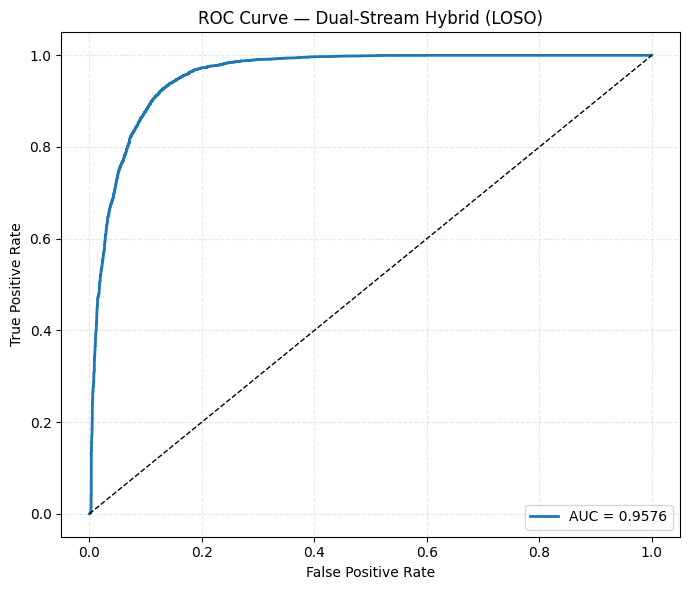

ROC curve saved to: figures/roc_curve_dualstream.png


In [6]:
# Rebuild windows if missing, then compute ROC & AUC (LOSO predictions)
import os, numpy as np, pandas as pd, pathlib, re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Config (match your previous run)
CLEAN_DIR = "cleaned_eeg_bcit"   # adjust if different
DATA_ROOT = "BCIT Mind Wandering/BCIT Mind Wandering"
SFREQ_TARGET = 128
WINDOW_SEC = 2
WINDOW_SIZE = SFREQ_TARGET * WINDOW_SEC
WINDOW_STEP = WINDOW_SIZE
BANDS = {"delta":(1,4),"theta":(4,8),"alpha":(8,12),"beta":(12,30)}
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Helper: find events file for run stem
def find_events_for_stem(stem):
    sub = re.search(r"(sub-\d+)", stem)
    run = re.search(r"(run-\d+)", stem)
    sub_tok = sub.group(1) if sub else None
    run_tok = run.group(1) if run else None
    if sub_tok and run_tok:
        pattern = f"{sub_tok}_ses-01_*_{run_tok}_events.tsv"
    else:
        pattern = "*events*.tsv"
    hits = list(pathlib.Path(DATA_ROOT).rglob(pattern))
    return str(hits[0]) if hits else None

# Helper: decode event value (same as earlier)
def decode_last_digit(v):
    try:
        d = int(str(v)[-1])
    except:
        return None
    if d == 1: return 0
    if d == 2: return 1
    return None

# If X_raw etc exist, skip rebuild; otherwise build
need_build = not all(name in globals() for name in ("X_raw","X_band","y","subjects"))
if need_build:
    print("Window arrays missing — rebuilding from cleaned FIF files in", CLEAN_DIR)
    import mne
    clean_files = sorted(pathlib.Path(CLEAN_DIR).glob("*_clean.fif"))
    if len(clean_files) == 0:
        raise RuntimeError(f"No cleaned FIF files found in {CLEAN_DIR}. Update CLEAN_DIR or load X_raw/X_band into memory.")
    X_raw_list = []
    X_band_list = []
    y_list = []
    subjects_list = []

    for fpath in clean_files:
        fpath = str(fpath)
        stem = pathlib.Path(fpath).stem
        base = stem.replace("_clean","")
        print("Processing:", base)
        events_path = find_events_for_stem(base)
        if events_path is None:
            print("  WARN: no events file found for", base, "→ skipping")
            continue

        raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
        if int(raw.info["sfreq"]) != SFREQ_TARGET:
            raw.resample(SFREQ_TARGET, npad="auto")
        data = raw.get_data()   # (channels, n_samples)
        n_chan, n_samples = data.shape

        evdf = pd.read_csv(events_path, sep="\t")
        sample_events = {}
        for onset, val in zip(evdf["onset"].values, evdf["value"].values):
            lbl = decode_last_digit(val)
            if lbl is None: continue
            sample = int(onset * SFREQ_TARGET)
            sample_events[sample] = lbl

        # precompute band filtered data for this run (avoid repeated filtering)
        band_data = {}
        for bname,(l,h) in BANDS.items():
            band_data[bname] = raw.copy().filter(l, h, fir_design='firwin', verbose=False).get_data()

        halfwin = WINDOW_SIZE // 2
        windows = 0
        for start in range(0, n_samples - WINDOW_SIZE + 1, WINDOW_STEP):
            end = start + WINDOW_SIZE
            center = start
            nearby = [s for s in sample_events.keys() if abs(s - center) <= halfwin]
            if not nearby:
                continue
            ev_sample = min(nearby, key=lambda s: abs(s - center))
            label = sample_events[ev_sample]
            win_raw = data[:, start:end]
            band_parts = [band_data[b][:, start:end] for b in BANDS]
            win_band = np.concatenate(band_parts, axis=0)
            X_raw_list.append(win_raw.T.astype(np.float32))
            X_band_list.append(win_band.T.astype(np.float32))
            y_list.append(label)
            sub = base.split("_")[0]
            subjects_list.append(sub)
            windows += 1

        print(f"  extracted windows: {windows}")

    if len(X_raw_list) == 0:
        raise RuntimeError("No windows extracted — check events alignment or paths.")

    X_raw = np.stack(X_raw_list, axis=0)
    X_band = np.stack(X_band_list, axis=0)
    y = np.array(y_list, dtype=np.int32)
    subjects = np.array(subjects_list)
    print("Rebuilt datasets:")
    print(" X_raw:", X_raw.shape, " X_band:", X_band.shape, " y:", y.shape, " subjects:", subjects.shape)
else:
    print("Window arrays are already present in memory — skipping rebuild.")
    # ensure shapes are accessible
    print("X_raw shape:", X_raw.shape if 'X_raw' in globals() else None)

# Now compute y_true_all and y_prob_all using LOSO predictions and the existing final_model
print("\nComputing LOSO probabilities using final_model...")

unique_subs = np.unique(subjects)
all_true = []
all_prob = []

for left_out in unique_subs:
    print(" Fold LOSO ->", left_out)
    test_idx = (subjects == left_out)
    train_idx = ~test_idx

    Xr_train, Xb_train, y_train = X_raw[train_idx], X_band[train_idx], y[train_idx]
    Xr_test,  Xb_test,  y_test  = X_raw[test_idx],  X_band[test_idx],  y[test_idx]

    # fit scalers on TRAIN fold only
    scaler_r_fold = StandardScaler().fit(Xr_train.reshape(-1, Xr_train.shape[2]))
    scaler_b_fold = StandardScaler().fit(Xb_train.reshape(-1, Xb_train.shape[2]))

    Xr_test_s = scaler_r_fold.transform(Xr_test.reshape(-1, Xr_test.shape[2])).reshape(Xr_test.shape)
    Xb_test_s = scaler_b_fold.transform(Xb_test.reshape(-1, Xb_test.shape[2])).reshape(Xb_test.shape)

    probs = final_model.predict([Xr_test_s, Xb_test_s], batch_size=128, verbose=0)[:,0]

    all_true.append(y_test)
    all_prob.append(probs)

y_true_all = np.concatenate(all_true)
y_prob_all = np.concatenate(all_prob)

print("Collected y_true_all shape:", y_true_all.shape)
print("Collected y_prob_all shape:", y_prob_all.shape)

# Compute ROC & AUC
fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)
print("AUC =", roc_auc)

# Plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Dual-Stream Hybrid (LOSO)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.3)
outp = os.path.join(FIG_DIR, "roc_curve_dualstream.png")
plt.tight_layout()
plt.savefig(outp, dpi=300)
plt.show()

print("ROC curve saved to:", outp)


PR-AUC = 0.9491849222971422


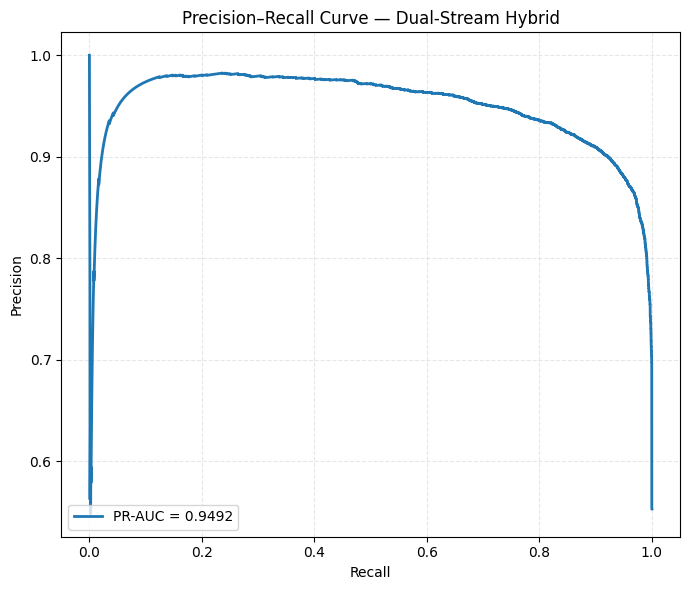

Saved PR curve at: figures/pr_curve_dualstream.png


In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import os

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

precision, recall, _ = precision_recall_curve(y_true_all, y_prob_all)
pr_auc = average_precision_score(y_true_all, y_prob_all)

print("PR-AUC =", pr_auc)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Dual-Stream Hybrid")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower left")

save_path = os.path.join(FIG_DIR, "pr_curve_dualstream.png")
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved PR curve at:", save_path)


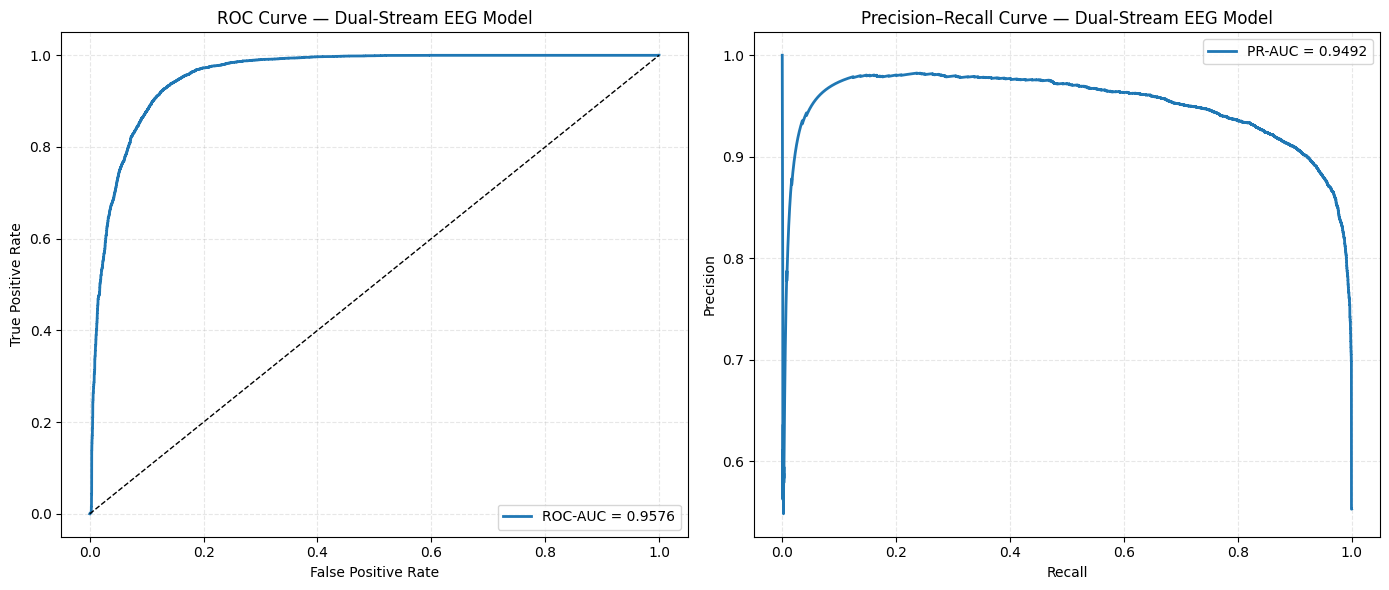

Saved combined ROC+PR figure at: figures/ROC_PR_combined_dualstream.png


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import os

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# --- ROC ---
fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)

# --- PR ---
precision, recall, _ = precision_recall_curve(y_true_all, y_prob_all)
pr_auc = average_precision_score(y_true_all, y_prob_all)

# --- Combined Plot ---
plt.figure(figsize=(14, 6))

# Left: ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, linewidth=2, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', linewidth=1)
plt.title("ROC Curve — Dual-Stream EEG Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

# Right: PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, linewidth=2, label=f"PR-AUC = {pr_auc:.4f}")
plt.title("Precision–Recall Curve — Dual-Stream EEG Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()

save_path = os.path.join(FIG_DIR, "ROC_PR_combined_dualstream.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Saved combined ROC+PR figure at:", save_path)


Baseline AUC: 0.9576115648843957
Occluding channel 1/74...
 Channel 0: AUC after occlusion 0.9563 -> drop 0.0013
Occluding channel 2/74...
 Channel 1: AUC after occlusion 0.9570 -> drop 0.0006
Occluding channel 3/74...
 Channel 2: AUC after occlusion 0.9566 -> drop 0.0010
Occluding channel 4/74...
 Channel 3: AUC after occlusion 0.9537 -> drop 0.0039
Occluding channel 5/74...
 Channel 4: AUC after occlusion 0.9565 -> drop 0.0011
Occluding channel 6/74...
 Channel 5: AUC after occlusion 0.9557 -> drop 0.0019
Occluding channel 7/74...
 Channel 6: AUC after occlusion 0.9556 -> drop 0.0020
Occluding channel 8/74...
 Channel 7: AUC after occlusion 0.9562 -> drop 0.0014
Occluding channel 9/74...
 Channel 8: AUC after occlusion 0.9571 -> drop 0.0005
Occluding channel 10/74...
 Channel 9: AUC after occlusion 0.9563 -> drop 0.0013
Occluding channel 11/74...
 Channel 10: AUC after occlusion 0.9573 -> drop 0.0003
Occluding channel 12/74...
 Channel 11: AUC after occlusion 0.9568 -> drop 0.0008
Oc

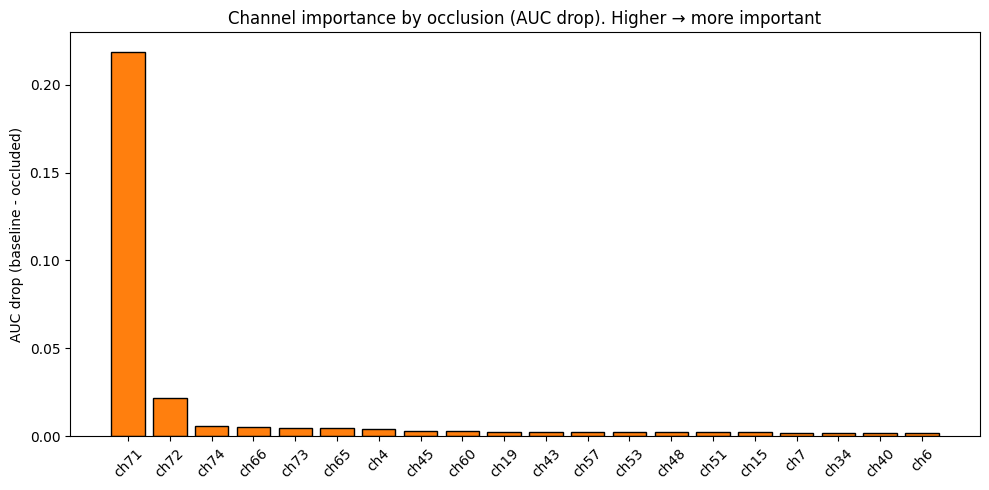

Saved: figures/channel_occlusion_importance.png


In [9]:
# Visual 1: Channel occlusion importance (AUC drop)
import numpy as np, os
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Recompute y_true_all, y_prob_all if missing
if 'y_true_all' not in globals() or 'y_prob_all' not in globals():
    print("Recomputing LOSO probabilities first (this may take a few minutes)...")
    unique_subs = np.unique(subjects)
    all_true, all_prob = [], []
    for left_out in unique_subs:
        test_idx = (subjects == left_out)
        train_idx = ~test_idx
        Xr_train, Xb_train, y_train = X_raw[train_idx], X_band[train_idx], y[train_idx]
        Xr_test,  Xb_test,  y_test  = X_raw[test_idx],  X_band[test_idx],  y[test_idx]
        scaler_r_fold = StandardScaler().fit(Xr_train.reshape(-1, Xr_train.shape[2]))
        scaler_b_fold = StandardScaler().fit(Xb_train.reshape(-1, Xb_train.shape[2]))
        Xr_test_s = scaler_r_fold.transform(Xr_test.reshape(-1, Xr_test.shape[2])).reshape(Xr_test.shape)
        Xb_test_s = scaler_b_fold.transform(Xb_test.reshape(-1, Xb_test.shape[2])).reshape(Xb_test.shape)
        probs = final_model.predict([Xr_test_s, Xb_test_s], batch_size=128, verbose=0)[:,0]
        all_true.append(y_test); all_prob.append(probs)
    y_true_all = np.concatenate(all_true); y_prob_all = np.concatenate(all_prob)
    print("Done recomputing global probabilities.")

baseline_auc = roc_auc_score(y_true_all, y_prob_all)
print("Baseline AUC:", baseline_auc)

n_channels = X_raw.shape[2]
auc_drops = np.zeros(n_channels)

# We'll evaluate occlusion on the whole dataset in LOSO manner to keep scaling consistent
unique_subs = np.unique(subjects)
for ch in range(n_channels):
    all_true, all_prob = [], []
    print(f"Occluding channel {ch+1}/{n_channels}...")
    for left_out in unique_subs:
        test_idx = (subjects == left_out)
        train_idx = ~test_idx
        Xr_train, Xb_train = X_raw[train_idx], X_band[train_idx]
        Xr_test,  Xb_test  = X_raw[test_idx].copy(),  X_band[test_idx].copy()
        # zero this channel in raw test
        Xr_test[:, :, ch] = 0.0
        # zero corresponding band channels in Xb_test: Xb channels are concatenated bands
        # each band block has n_channels columns, order: delta|theta|alpha|beta
        band_block = X_raw.shape[2]
        for b_idx in range(4):
            bstart = b_idx * band_block
            Xb_test[:, :, bstart + ch] = 0.0

        # scale per-fold
        scaler_r_fold = StandardScaler().fit(Xr_train.reshape(-1, Xr_train.shape[2]))
        scaler_b_fold = StandardScaler().fit(Xb_train.reshape(-1, Xb_train.shape[2]))
        Xr_test_s = scaler_r_fold.transform(Xr_test.reshape(-1, Xr_test.shape[2])).reshape(Xr_test.shape)
        Xb_test_s = scaler_b_fold.transform(Xb_test.reshape(-1, Xb_test.shape[2])).reshape(Xb_test.shape)

        probs = final_model.predict([Xr_test_s, Xb_test_s], batch_size=128, verbose=0)[:,0]
        all_true.append(y[test_idx]); all_prob.append(probs)
    y_t = np.concatenate(all_true); y_p = np.concatenate(all_prob)
    auc_ch = roc_auc_score(y_t, y_p)
    auc_drops[ch] = baseline_auc - auc_ch
    print(f" Channel {ch}: AUC after occlusion {auc_ch:.4f} -> drop {auc_drops[ch]:.4f}")

# Plot top-k channels by drop
order = np.argsort(auc_drops)[::-1]
topk = min(20, n_channels)
channels = [f"ch{c+1}" for c in order[:topk]]
drops = auc_drops[order[:topk]]

plt.figure(figsize=(10,5))
plt.bar(range(len(drops)), drops, color='C1', edgecolor='k')
plt.xticks(range(len(drops)), channels, rotation=45)
plt.ylabel("AUC drop (baseline - occluded)")
plt.title("Channel importance by occlusion (AUC drop). Higher → more important")
plt.tight_layout()
outp = os.path.join(FIG_DIR, "channel_occlusion_importance.png")
plt.savefig(outp, dpi=300)
plt.show()
print("Saved:", outp)


Plotting timeline for: sub-01


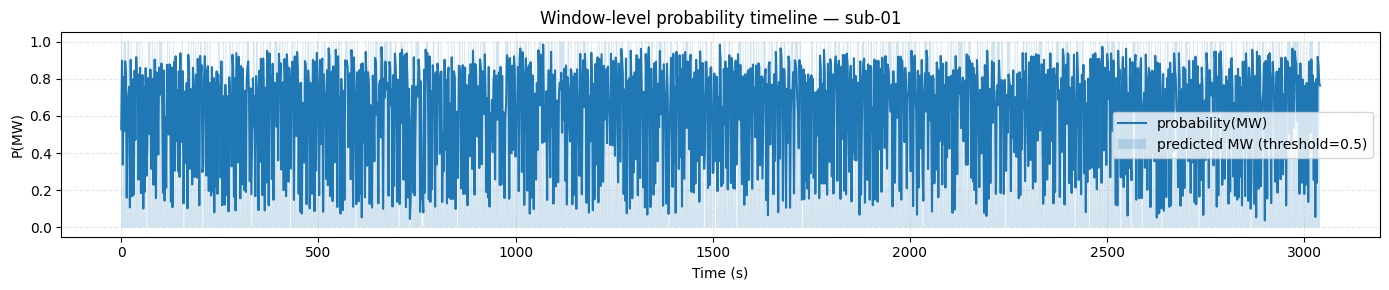

Saved: figures/timeline_sub-01.png


In [10]:
# Visual 3: Probability timeline for a selected subject/run
import matplotlib.pyplot as plt, numpy as np, os

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# pick subject to visualize (choose from subjects unique list)
subject_to_plot = np.unique(subjects)[0]   # change index if you want another
print("Plotting timeline for:", subject_to_plot)

test_idx = (subjects == subject_to_plot)
train_idx = ~test_idx

scaler_r_fold = StandardScaler().fit(X_raw[train_idx].reshape(-1, X_raw.shape[2]))
scaler_b_fold = StandardScaler().fit(X_band[train_idx].reshape(-1, X_band.shape[2]))

Xr_test_s = scaler_r_fold.transform(X_raw[test_idx].reshape(-1, X_raw.shape[2])).reshape(X_raw[test_idx].shape)
Xb_test_s = scaler_b_fold.transform(X_band[test_idx].reshape(-1, X_band.shape[2])).reshape(X_band[test_idx].shape)

probs = final_model.predict([Xr_test_s, Xb_test_s], batch_size=128, verbose=0)[:,0]
preds = (probs >= 0.5).astype(int)
times = np.arange(len(probs)) * (WINDOW_SIZE / SFREQ_TARGET)  # seconds, assuming non-overlap

plt.figure(figsize=(14,3))
plt.plot(times, probs, label="probability(MW)", linewidth=1.5)
plt.fill_between(times, 0, preds, alpha=0.2, label="predicted MW (threshold=0.5)")
plt.xlabel("Time (s)")
plt.ylabel("P(MW)")
plt.title(f"Window-level probability timeline — {subject_to_plot}")
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
outp = os.path.join(FIG_DIR, f"timeline_{subject_to_plot}.png")
plt.tight_layout()
plt.savefig(outp, dpi=300)
plt.show()
print("Saved:", outp)
